# first test of all code in `stancode_gallery2`
 * using all of the data for training (`i_test[:] = 0`)
 * **Note:** I accidentally used an outdated template for this notebook: Zinser reference `divrate` value is still 0.63 and not 0.69, error bar plot is not set up to handle `i_test[:] = 0` well, etc.
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
zinser = pd.read_csv('data/Zinser_Figure2A.csv')

# Extract cell counts from files
seaflow_counts = seaflow.values[:, 2:].T.astype(int)
zinser_counts = zinser.values[:, 1].astype(int) # cells A column
# zinser_counts = zinser.values[:, 2].astype(int) # cells B column
# zinser_counts = zinser.values[:, 1].astype(int) + zinser.values[:, 2].astype(int) # sum of both columns

# Replace SeaFlow values based on the 25-size class data with 32-size class data
data_gridded['seaflow']['m'] = seaflow_counts.shape[0]
data_gridded['seaflow']['size_bounds'] = seaflow.columns[2:].values.astype(float)/1000 # extract size classes from dataframe
data_gridded['seaflow']['v_min'] = data_gridded['seaflow']['size_bounds'][0] # note these seem to be on a different scale
data_gridded['seaflow']['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded['seaflow']['size_bounds'][1]/data_gridded['seaflow']['size_bounds'][0])))
data_gridded['seaflow']['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
data_gridded['seaflow']['counts'] = seaflow_counts
data_gridded['seaflow']['obs_time'] = np.empty(shape=seaflow_counts.shape[1])
ii = 0
for timestamp in np.asarray(seaflow['time'], dtype=str):
    datetime = dateutil.parser.isoparse(timestamp)
    if ii == 0:
        initial = datetime
    data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
    ii += 1

# Add counts to Zinser data
data_gridded['zinser']['counts'] = (data_gridded['zinser']['w_obs'] * zinser_counts[None, :]).astype(int)
data_gridded['zinser']['obs_time'] = data_gridded['zinser']['time']

/home/paul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


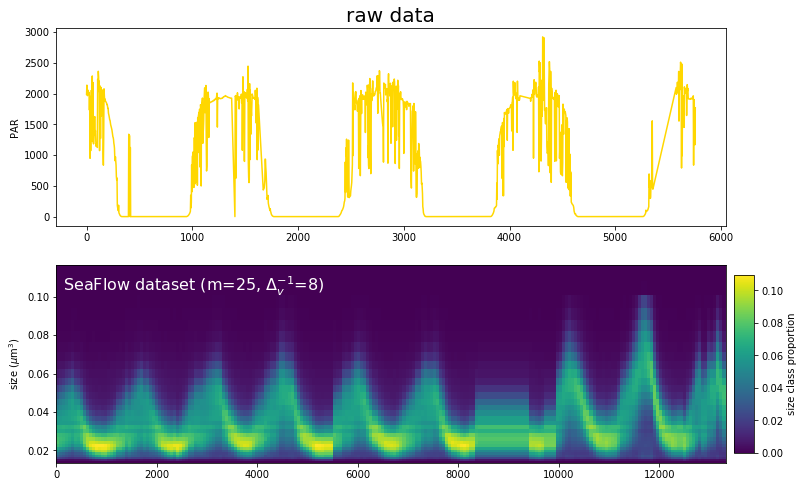

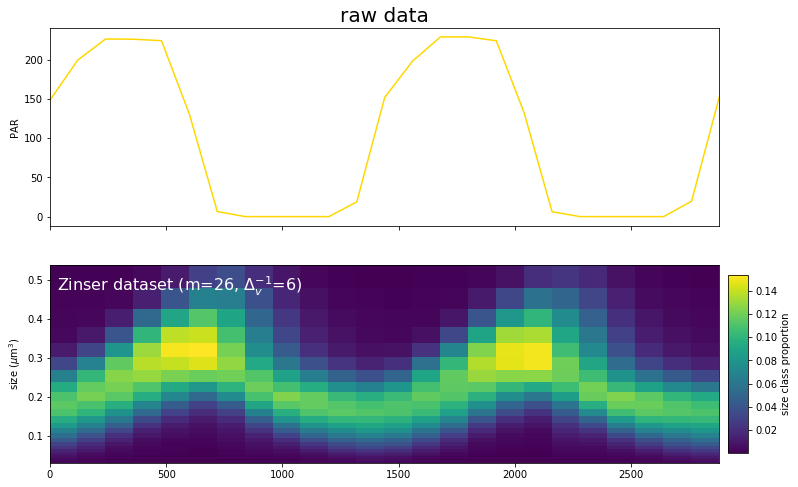

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    sharex_flag = 'none'
    if np.all(data_gridded[dataname]['time'] == data_gridded[dataname]['obs_time']):
        sharex_flag = True
    fig,axs = plt.subplots(nrows=nrows, sharex=sharex_flag, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        
        # new: average SeaFlow data in hourly bins
#         binsize = 60 # in minutes
#         numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
#         data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
#         data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
#         i = 0
#         for ibin in range(numbins):
#             binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
#                                     data_gridded[dataname]['time'] < (ibin+1)*binsize)
#             if np.any(binind):
#                 # TODO we may want to make this a sum when dealing with counts
#                 data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
#                 data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
#                 i += 1
        
#         data[dataname]['obs'] = data[dataname]['obs'][:,:i]
#         data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
#     data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))


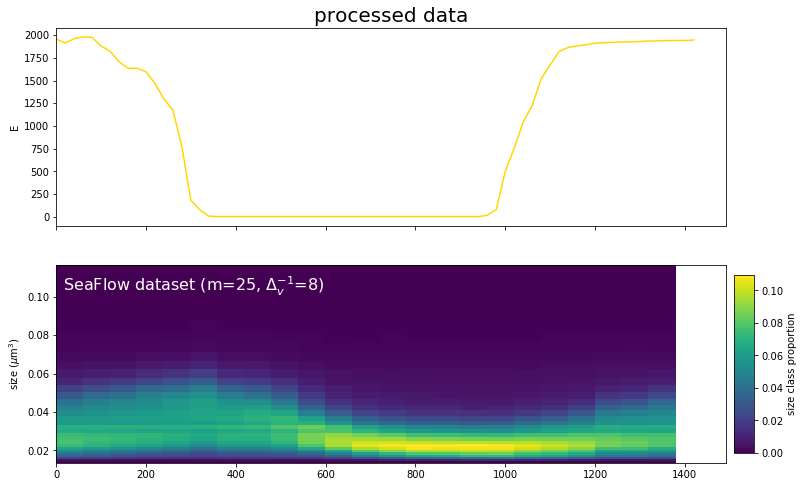

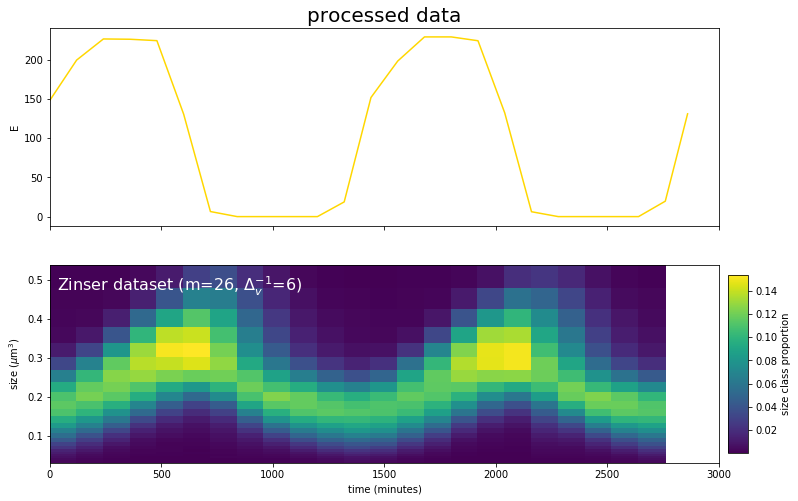

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'basic model, free deltas',
    's2':'basic model, monotonic deltas',
    's3':'size-dep growth (gammaiv6)',
    's4':'simple growth, simple respiration (respv1)',
    's5':'simple net growth-respiration (respv2)',
    's6':'size-dep net growth-respiration (respiv6)',
    's7':'size-dep growth, size-dep respiration (respiv7)',
    's8':'size-dep growth, size-dep respiration (respiv6), light-dep div',
    's9':'size-dep growth, size-dep respiration (respiv7), light-dep div',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

/home/paul/.local/lib/python3.6/site-packages/Cython/Distutils/old_build_ext.py:41: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s4 NOW.


s4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s8 NOW.


s8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            4.35    0.01   0.83   2.69    3.8   4.34   4.92   5.96   5674    1.0
delta_sigma         6.97    0.03   1.53   4.42    5.9    6.8   7.91  10.32   3433    1.0
delta[1]          3.3e-4  4.7e-6 3.4e-4 6.6e-6 8.4e-5 2.1e-4 4.5e-4 1.2e-3   5289    1.0
delta[2]            0.28  4.3e-4   0.03   0.23   0.26   0.28   0.29   0.33   3963    1.0
delta[3]            1.03  1.3e-3   0.07   0.91   0.98   1.03   1.08   1.17   2816    1.0
delta[4]            1.53  2.2e-3    0.1   1.34   1.46   1.53    1.6   1.73   2123    1.0
delta[5]             1.6  1.7e-3   0.11    1.4   1.53    1.6   1.67   1.82   4263    1.0
delta[6]            2.09  2.2e-3   0.13   1.84    2.0   2.09   2.18   2.36   3715    1.0
delta[7]            2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (basic model, free deltas)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu             3.4    0.03   0.92   1.61   2.77    3.4   4.01   5.15   1008    1.0
delta_sigma         8.58    0.03    1.4   6.22    7.6   8.45    9.4  11.76   2870    1.0
delta[1]            0.15  4.5e-3   0.14 4.9e-3   0.04   0.11   0.21   0.51    950    1.0
delta[2]            0.14  5.4e-3   0.12 2.6e-3   0.05   0.11    0.2   0.44    473    1.0
delta[3]            0.14  2.0e-3   0.11 4.8e-3   0.06   0.12   0.21   0.41   3087    1.0
delta[4]            0.17  2.0e-3   0.11 8.1e-3   0.08   0.16   0.25   0.44   3147    1.0
delta[5]            0.24  2.1e-3   0.12   0.04   0.15   0.23   0.31   0.49   3191    1.0
delta[6]            0.31  1.6e-3    0.1   0.12   0.24    0.3   0.37   0.52   3868    1.0
delta[7]            0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.18    0.28   8.15  21.69  28.57  33.19  38.37  53.15    859    1.0
gamma_max           1.48  1.5e-3   0.07   1.37   1.43   1.47   1.51   1.64   2051    1.0
rho_max             2.58    0.02    1.5   0.14   1.27   2.58   3.88   5.02   7164    1.0
E_star            192.43    4.15 158.23  42.71   82.4 133.04 253.87 618.14   1451    1.0
sigma             919.71    0.59   44.7 835.14 889.04 918.77 950.59 1008.8   5715    1.0
divrate             0.72  4.3e-4   0.02   0.67    0.7   0.72   0.74   0.77   3227    1.0
delta[1]          3.2e-4  3.8e-6 3.2e-4 8.5e-6 8.7e-5 2.2e-4 4.5e-4 1.2e-3   7047    1.0
delta[2]            0.28  4.3e-4   0.03   0.23   0.26   0.28    0.3   0.33   4037    1.0
delta[3]        

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (basic model, monotonic deltas)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          37.15    0.17   5.88   27.1  32.83  36.74  40.87  50.03   1163    1.0
gamma_max           8.21    0.01   0.52   6.92   7.95   8.35   8.61    8.8   1333    1.0
rho_max             4.36    0.05   2.53   0.24   2.22   4.27   6.55   8.59   2146    1.0
E_star            312.32    0.87  32.17 237.39 294.64 315.83 335.26 366.46   1355    1.0
sigma             192.16    0.25  11.71 169.71 184.31 192.27 200.01  215.5   2258    1.0
divrate             1.73  1.0e-3   0.06    1.6   1.68   1.72   1.77   1.85   3774    1.0
delta[1]            0.03  4.9e-4   0.03 7.8e-4   0.01   0.03   0.05   0.11   3712    1.0
delta[2]            0.07  7.3e-4   0.04   0.01   0.04   0.07    0.1   0.17   3246    1.0
delta[3]        

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (size-dep growth (gammaiv6))
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.33    0.19   7.92  22.32   28.5  33.19  38.99  52.66   1687    1.0
gamma_max           1.48  1.6e-3   0.07   1.37   1.44   1.48   1.52   1.64   2046    1.0
rho_max             2.62    0.02   1.48   0.17   1.32   2.64    3.9   5.04   9519    1.0
E_star            190.29    3.97  162.8  41.71  82.68 128.31 242.39 641.28   1683    1.0
sigma              920.0    0.47  45.67 833.06 888.87 918.98 949.62 1012.1   9316    1.0
xi                  0.04  9.7e-4    0.1  -0.15  -0.03   0.04   0.11   0.24  10516    1.0
divrate             0.72  4.3e-4   0.02   0.67    0.7   0.72   0.74   0.77   3378    1.0
delta[1]          3.2e-4  4.0e-6 3.3e-4 8.9e-6 9.2e-5 2.2e-4 4.5e-4 1.2e-3   6673    1.0
delta[2]           

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (size-dep growth (gammaiv6))
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          35.96    0.21   6.03  25.88  31.69  35.45  39.54   49.2    798    1.0
gamma_max           8.23    0.02   0.51   6.95   7.97   8.35   8.62    8.8    785    1.0
rho_max             4.36    0.05   2.56   0.18   2.12   4.36   6.55   8.59   2487    1.0
E_star             300.1    1.08  31.71 228.25 281.08  304.0 321.88 353.51    860    1.0
sigma             194.82    0.26  11.69 172.02 186.96 194.79 202.85 218.04   2021    1.0
xi                 -0.21  2.4e-3    0.1  -0.42  -0.28  -0.22  -0.15  -0.01   1931    1.0
divrate              1.7  1.1e-3   0.06   1.58   1.66    1.7   1.74   1.83   3085    1.0
delta[1]            0.04  6.2e-4   0.03 1.1e-3   0.01   0.03   0.05   0.12   2530    1.0
delta[2]           

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (simple growth, simple respiration (respv1))
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.04    0.21   7.94  21.28  28.44  33.13  38.59  52.19   1422    1.0
gamma_max           1.47  1.2e-3   0.06   1.37   1.43   1.47   1.51   1.61   2835    1.0
rho_max           6.4e-4  7.9e-6 6.1e-4 1.8e-5 1.9e-4 4.5e-4 8.8e-4 2.3e-3   6096    1.0
E_star             184.7    3.15  149.6  40.55  82.57 127.24 241.49 576.83   2250    1.0
sigma             917.71    0.49  45.48 830.54 885.53 917.18 948.99 1005.6   8575    1.0
divrate             0.72  3.7e-4   0.02   0.67    0.7   0.72   0.73   0.76   3964    1.0
delta[1]          3.2e-4  3.7e-6 3.1e-4 1.0e-5 9.7e-5 2.2e-4 4.6e-4 1.2e-3   7318    1.0
delta[2]            0.27  4.1e-4   0.03   0.22   0.26   0.27   0.29   0.33   4132    1.0
del

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (simple growth, simple respiration (respv1))
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          44.35    0.18   6.03  34.28  40.31  43.73  47.69  58.39   1174    1.0
gamma_max           8.03    0.01   0.61   6.62   7.65   8.17   8.54    8.8   2099    1.0
rho_max             1.28  1.0e-3   0.05   1.17   1.24   1.28   1.31   1.38   2858    1.0
E_star            222.82    0.67  30.29 154.74 204.21 228.37 245.92 267.59   2066    1.0
sigma              311.5    0.33  17.73 276.18 299.59 311.37 322.84 346.71   2944    1.0
divrate             0.86  7.7e-4   0.05   0.77   0.83   0.86   0.89   0.95   3625    1.0
delta[1]          6.4e-3  9.0e-5 6.2e-3 1.8e-4 1.9e-3 4.6e-3 8.8e-3   0.02   4737    1.0
delta[2]            0.01  1.2e-4 8.6e-3 1.7e-3 6.6e-3   0.01   0.02   0.03   4948    1.0
del

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (simple net growth-respiration (respv2))
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.18    0.26   8.15  21.62  28.35  32.86  38.64  53.87   1015   1.01
gamma_max           1.48  1.9e-3   0.07   1.37   1.43   1.47   1.51   1.63   1282    1.0
rho_max           7.2e-4  1.1e-5 7.3e-4 1.6e-5 2.0e-4 4.9e-4 1.0e-3 2.7e-3   4827    1.0
E_star            189.19    4.65 159.21  42.11  81.93  128.8 244.74 614.05   1172    1.0
sigma             915.57    0.71  45.69 828.44 884.48 914.57 946.29 1004.5   4140    1.0
divrate             0.72  4.4e-4   0.02   0.67    0.7   0.72   0.74   0.76   3041    1.0
delta[1]          3.3e-4  4.9e-6 3.4e-4 7.3e-6 9.7e-5 2.2e-4 4.6e-4 1.3e-3   4993    1.0
delta[2]            0.27  4.2e-4   0.03   0.22   0.26   0.27   0.29   0.33   4113    1.0
delta[3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5: in try 1/3 found Rhat=14.084, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (simple net growth-respiration (respv2))
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          23.65    0.16   5.38  16.19   20.1  22.71  25.92  37.32   1150    1.0
gamma_max           4.45  7.0e-3   0.32   4.05   4.25   4.39   4.58   5.22   2044    1.0
rho_max             1.56  1.1e-3   0.06   1.44   1.52   1.56   1.61   1.69   3525    1.0
E_star             86.46     0.5  22.75  53.38  71.36  83.22  97.31 139.27   2071    1.0
sigma             393.42    0.37  22.82 350.67 377.59 393.02 408.31 439.64   3784    1.0
divrate             0.61  6.8e-4   0.04   0.52   0.58   0.61   0.64   0.69   4103    1.0
delta[1]          8.5e-3  1.1e-4 7.4e-3 3.2e-4 2.8e-3 6.7e-3   0.01   0.03   5021    1.0
delta[2]            0.02  1.4e-4   0.01 2.6e-3 9.5e-3   0.02   0.02   0.04   5661    1.0
delta[3

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (size-dep net growth-respiration (respiv6))
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.44    0.21    8.3  21.82  28.51  33.23  38.88  54.26   1589    1.0
gamma_max           1.48  1.1e-3   0.06   1.37   1.44   1.48   1.51   1.63   3570    1.0
rho_max           7.0e-4  9.5e-6 7.2e-4 1.7e-5 2.0e-4 4.8e-4 9.5e-4 2.6e-3   5850    1.0
E_star            183.11    3.13 150.12  42.13  81.14  128.0 234.43 590.89   2304    1.0
sigma             918.66    0.53  46.91 828.79 885.82 917.91 950.75 1013.3   7870    1.0
xi                  0.04  9.9e-4    0.1  -0.16  -0.03   0.04   0.11   0.24  10265    1.0
xir               7.4e-4  8.8e-4    0.1  -0.19  -0.07 1.8e-3   0.07   0.19  12840    1.0
divrate             0.72  4.0e-4   0.02   0.67    0.7   0.72   0.74   0.76   3578    1.0
delt

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (size-dep net growth-respiration (respiv6))
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           2.71  7.4e-3    0.4   2.01   2.44   2.68   2.95   3.58   2972    1.0
gamma_max           5.26  4.6e-3    0.2   4.95   5.13   5.24   5.37   5.73   1839    1.0
rho_max             2.09  1.6e-3   0.08   1.94   2.04   2.09   2.14   2.25   2507    1.0
E_star             79.18    0.25  11.55  60.08  71.39   78.0  85.48 106.21   2170    1.0
sigma             625.45    0.66  37.22 551.85 601.37 625.12 649.76 700.03   3212    1.0
xi                 -1.15  1.5e-3   0.07  -1.31   -1.2  -1.15   -1.1  -1.01   2392    1.0
xir                 0.49  1.5e-3   0.08   0.33   0.43   0.49   0.54   0.65   2876    1.0
divrate             0.33  4.4e-4   0.03   0.28   0.32   0.33   0.35   0.38   3663    1.0
delt

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          34.07    0.19   7.99  21.68  28.34   33.0  38.61  53.03   1844    1.0
gamma_max           1.49  1.5e-3   0.07   1.38   1.44   1.48   1.52   1.64   2138    1.0
rho_max           6.3e-4  9.1e-6 6.6e-4 1.4e-5 1.7e-4 4.1e-4 8.7e-4 2.5e-3   5284    1.0
E_star            193.66    3.93 165.25   40.4   81.4 131.61 253.46 625.16   1769    1.0
sigma             917.89     0.6  46.33 832.96 886.03 916.62 948.76 1011.8   5900    1.0
xi                  0.04  1.2e-3    0.1  -0.16  -0.03   0.04   0.11   0.24   6782    1.0
xir              -5.9e-4  1.2e-3    0.1  -0.19  -0.06-2.2e-4   0.06   0.19   6936    1.0
divrate             0.72  4.0e-4   0.02   0.67    0.7   0.72   0.74   0.77   3801    1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (size-dep growth, size-dep respiration (respiv7))
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          37.14    0.15   6.01  27.11  33.07  36.54  40.48  51.05   1663    1.0
gamma_max           8.15    0.01   0.51   6.91   7.83   8.26   8.57   8.79   2263    1.0
rho_max              1.5  1.7e-3   0.09   1.34   1.44    1.5   1.56   1.68   2429    1.0
E_star            193.66    0.52  24.64 137.27 179.12 196.31 211.75  233.0   2283    1.0
sigma             343.55    0.36  20.07 305.36 329.81 343.55 356.75 383.41   3149    1.0
xi                 -0.55  1.7e-3   0.11  -0.76  -0.62  -0.55  -0.48  -0.34   4060    1.0
xir                 0.27  1.9e-3    0.1   0.06    0.2   0.27   0.33   0.46   2621    1.0
divrate             0.73  8.3e-4   0.05   0.63   0.69   0.73   0.76   0.83   3707    1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (size-dep growth, size-dep respiration (respiv6), light-dep div)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           10.9    0.07   2.84   7.08   8.95  10.33  12.25   17.9   1493    1.0
gamma_max           0.83  4.7e-3   0.24   0.61   0.67   0.74   0.92   1.48   2533    1.0
rho_max           6.1e-4  7.9e-6 6.1e-4 1.7e-5 1.7e-4 4.2e-4 8.3e-4 2.3e-3   6019    1.0
E_star            849.82   13.78 713.87  63.84 309.56 613.89 1200.0 2691.0   2683    1.0
sigma             1083.2    0.57  51.54 985.33 1048.7 1081.9 1118.6 1184.4   8117    1.0
xi                  0.02  9.7e-4    0.1  -0.17  -0.05   0.02   0.09   0.21  10383    1.0
xir               3.9e-4  9.0e-4    0.1   -0.2  -0.07 1.3e-3   0.07   0.19  12858    1.0
delta_lightthresh   4.39    0.09   5.67   0.08   0.96   2.39   5.06   21

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (size-dep growth, size-dep respiration (respiv6), light-dep div)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           5.68  8.7e-3   0.53   4.76   5.32   5.64    6.0   6.83   3710    1.0
gamma_max           3.83  2.1e-3   0.12   3.62   3.76   3.82    3.9   4.08   3218    1.0
rho_max             1.47  1.8e-3    0.1   1.27   1.39   1.46   1.54   1.68   3543    1.0
E_star             49.06    0.19   10.4  31.75  42.68  47.85  53.86  74.54   3139    1.0
sigma             770.81    0.86  49.04 678.49 738.41 769.94  804.2 870.12   3230    1.0
xi                 -1.32  1.2e-3   0.08  -1.47  -1.37  -1.32  -1.27  -1.17   4320    1.0
xir                 0.55  1.1e-3   0.08   0.38   0.49   0.55    0.6   0.72   6004    1.0
delta_lightthresh  49.67    0.11   6.97  37.62  44.83  49.05  54.15  64.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          11.06     0.1   3.05   7.04   8.98  10.52  12.41  18.83    852    1.0
gamma_max           0.83  5.9e-3   0.23   0.61   0.67   0.74   0.92   1.46   1516    1.0
rho_max           4.8e-4  6.2e-6 4.8e-4 1.7e-5 1.4e-4 3.3e-4 6.7e-4 1.8e-3   5995    1.0
E_star            843.26   17.67  702.2  49.54 307.88 630.51 1202.0 2621.0   1579    1.0
sigma             1081.5    0.78  55.18 979.63 1042.5 1079.7 1119.3 1191.7   5008    1.0
xi                  0.02  1.3e-3    0.1  -0.18  -0.05   0.02   0.09   0.22   6315    1.0
xir               3.0e-4  1.2e-3    0.1   -0.2  -0.07 3.9e-4   0.07    0.2   6599    1.0
delta_lightthresh   4.19    0.08    5.4   0.09   0.97    2.3   5.02  21.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (size-dep growth, size-dep respiration (respiv7), light-dep div)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          10.16    0.02   0.91   8.69   9.51  10.06  10.67  12.27   2521    1.0
gamma_max           7.64    0.02   0.92   5.38   7.12   7.86   8.36   8.78   2620    1.0
rho_max             0.01  2.0e-4   0.01 2.7e-4 3.4e-3 8.7e-3   0.02   0.05   4696    1.0
E_star            695.66    2.02 101.36 459.11 636.17 713.71  771.5 845.03   2529    1.0
sigma             428.96    0.72  33.29 367.17 406.25 427.51 451.15 497.25   2164    1.0
xi                 -1.41  2.3e-3   0.11  -1.63  -1.48  -1.41  -1.33  -1.18   2475    1.0
xir                 0.02  1.7e-3    0.1  -0.19  -0.05   0.02   0.09   0.22   3774    1.0
delta_lightthresh  11.35    0.13   4.72    1.0   8.47  11.78  14.58   19

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

/home/paul/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paul/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


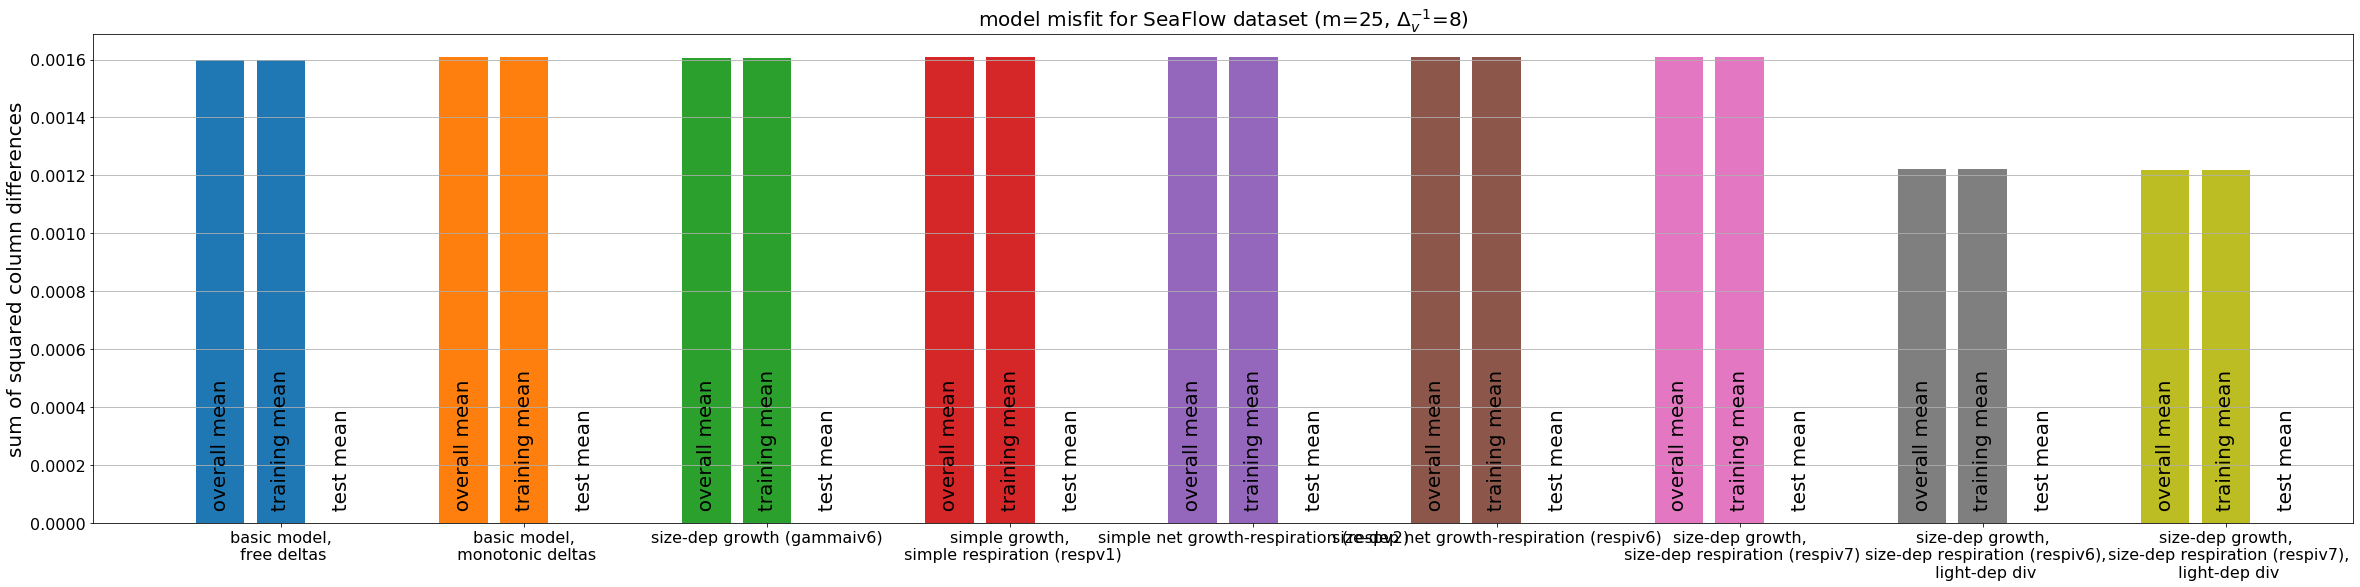

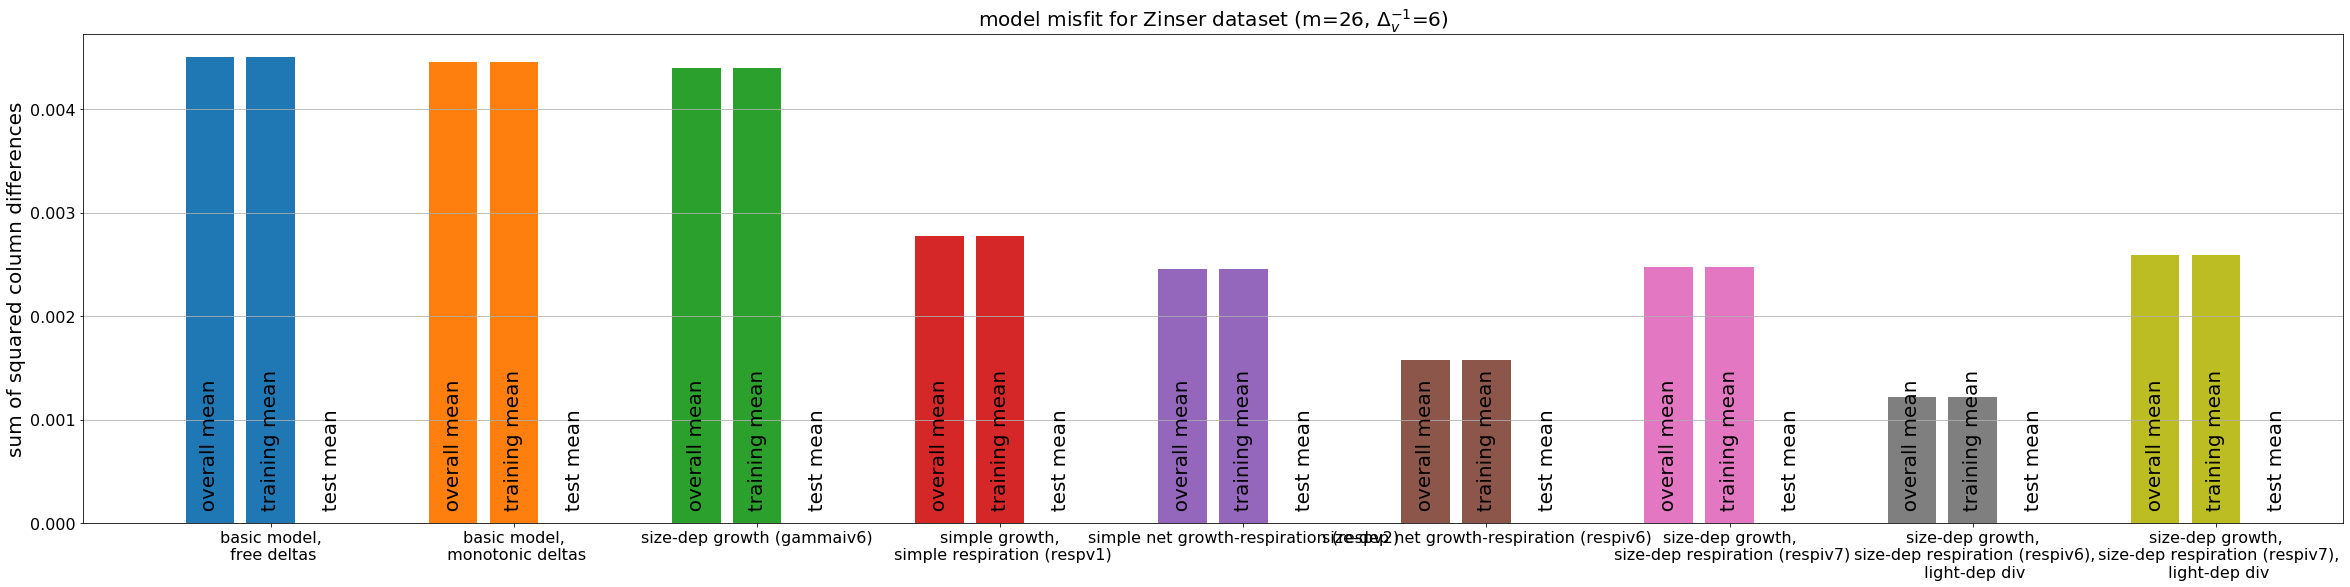

In [9]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

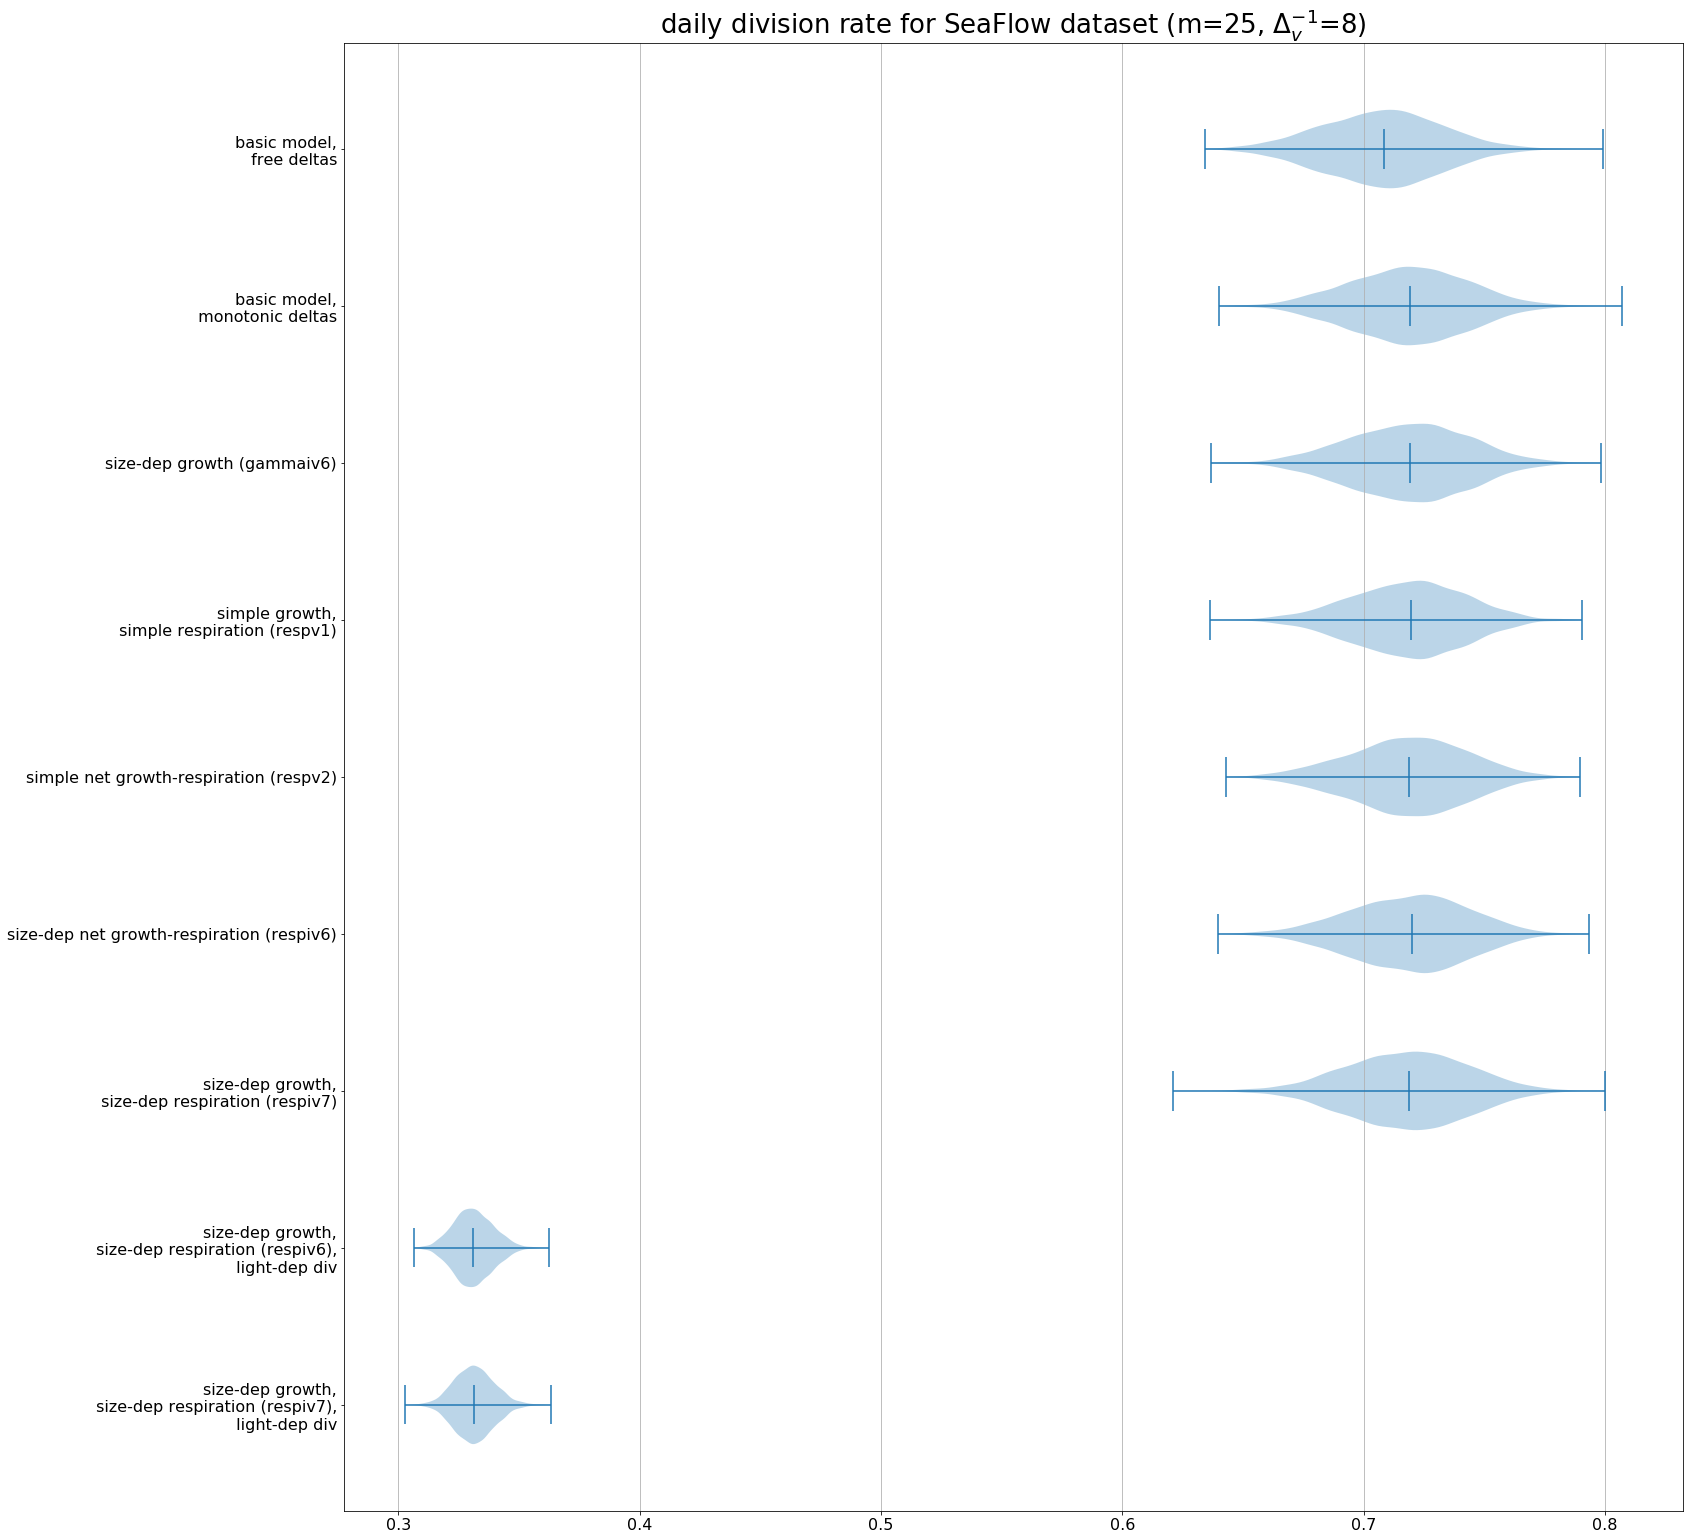

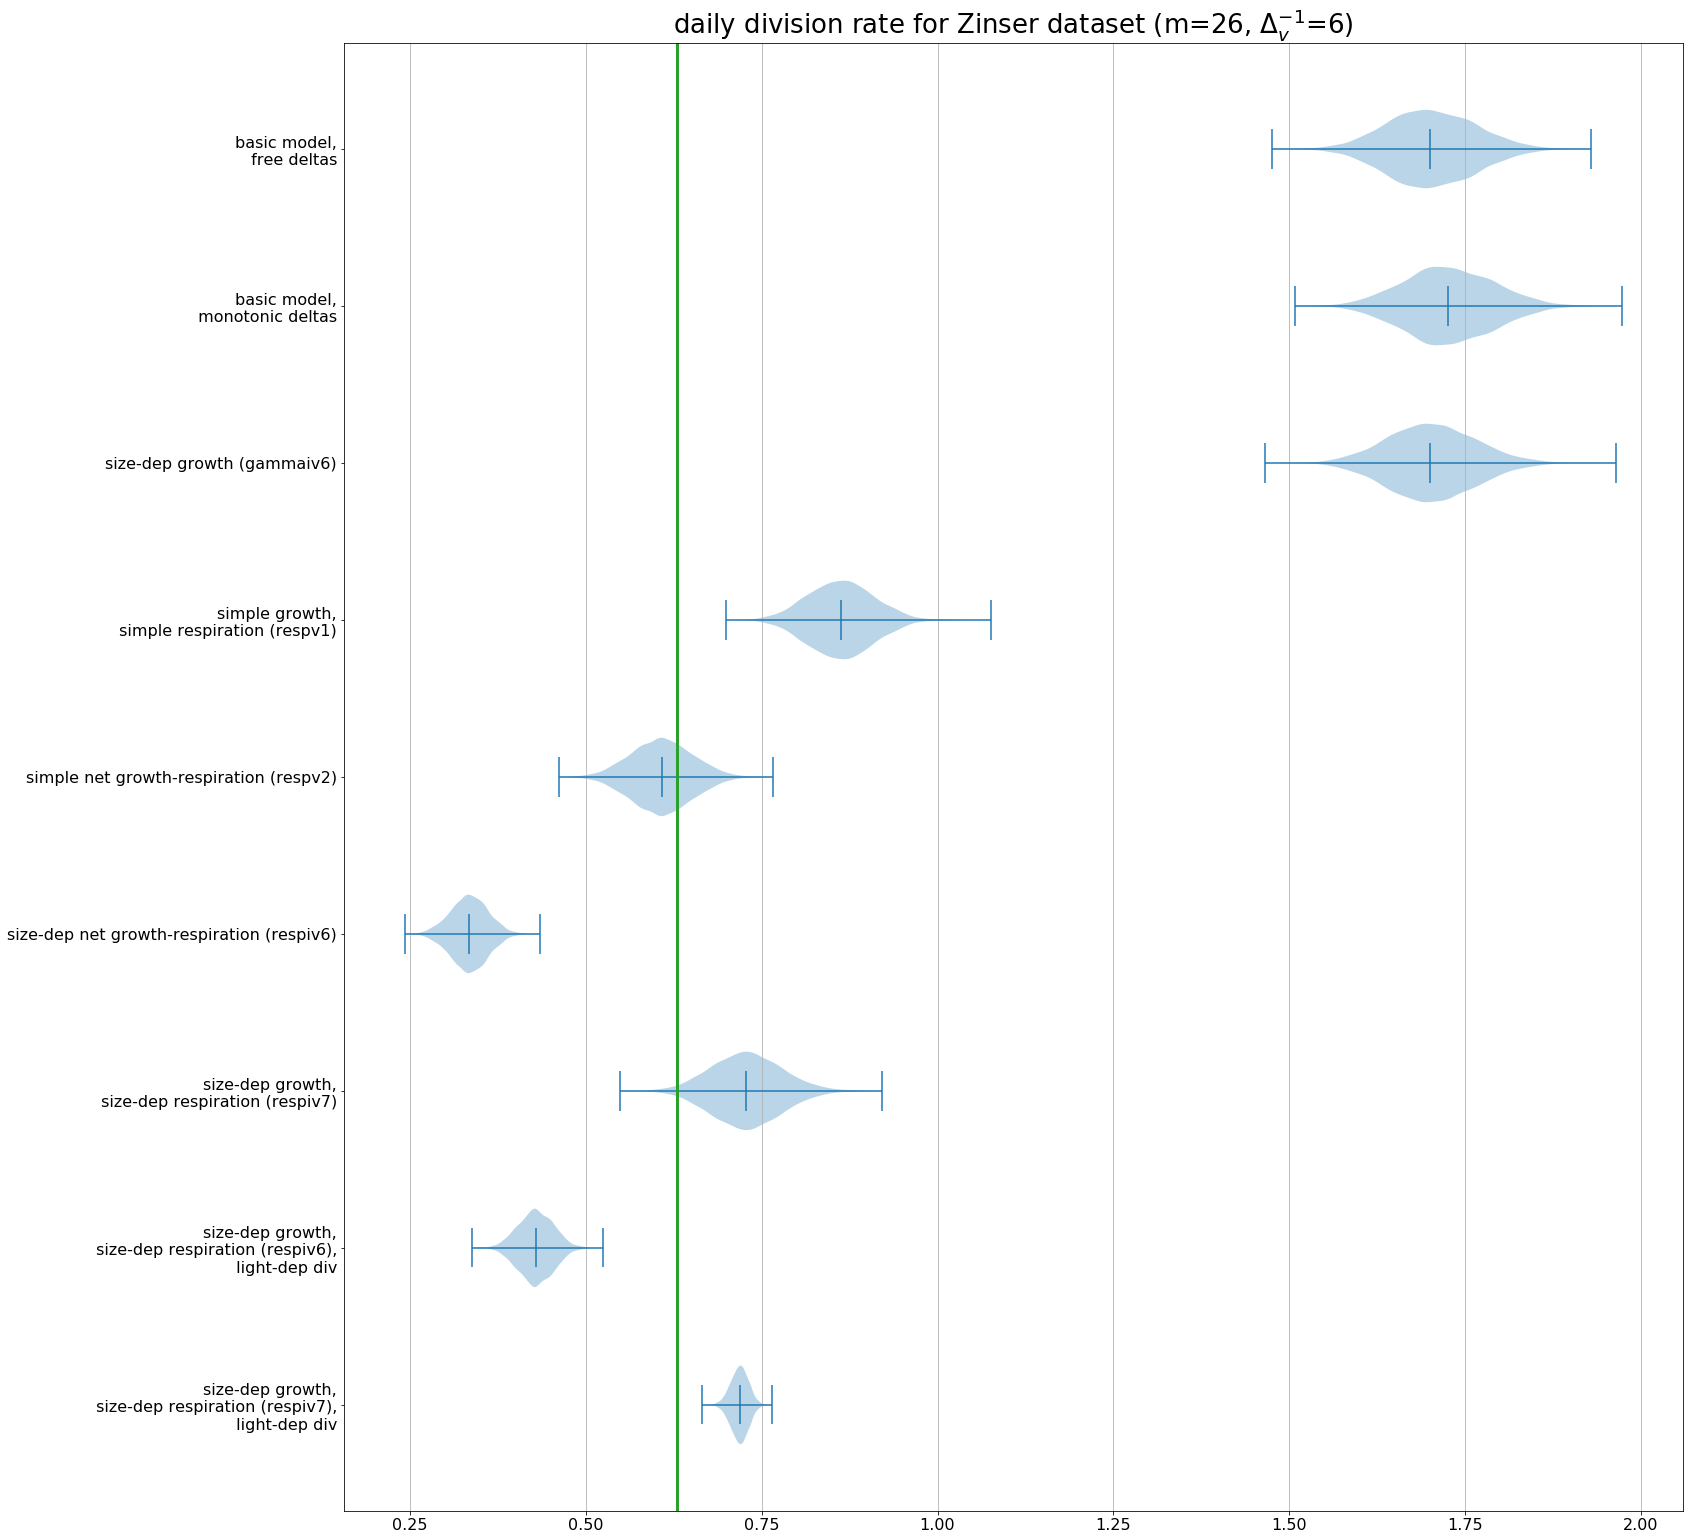

In [10]:
for dataname in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[dataname])
    ax.violinplot([mcmcs[name][dataname]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in dataname:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')


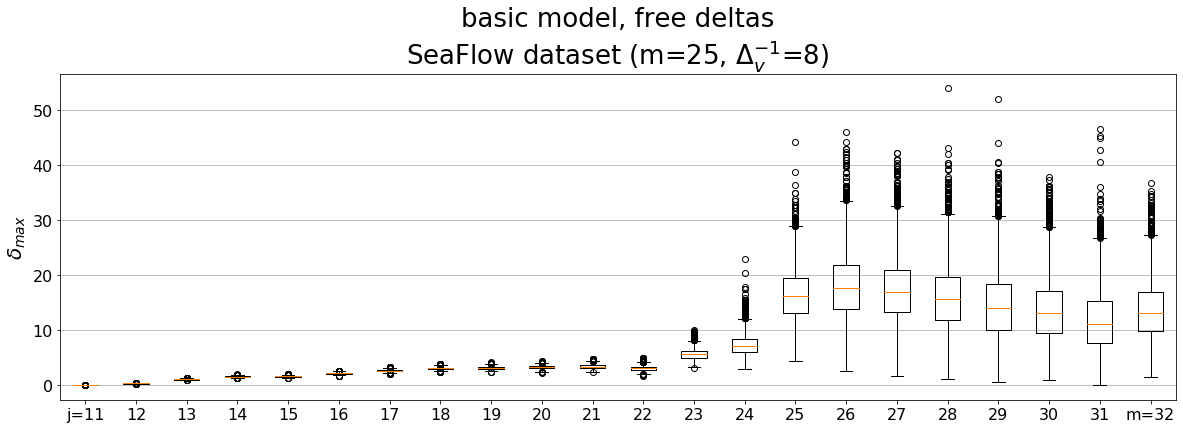

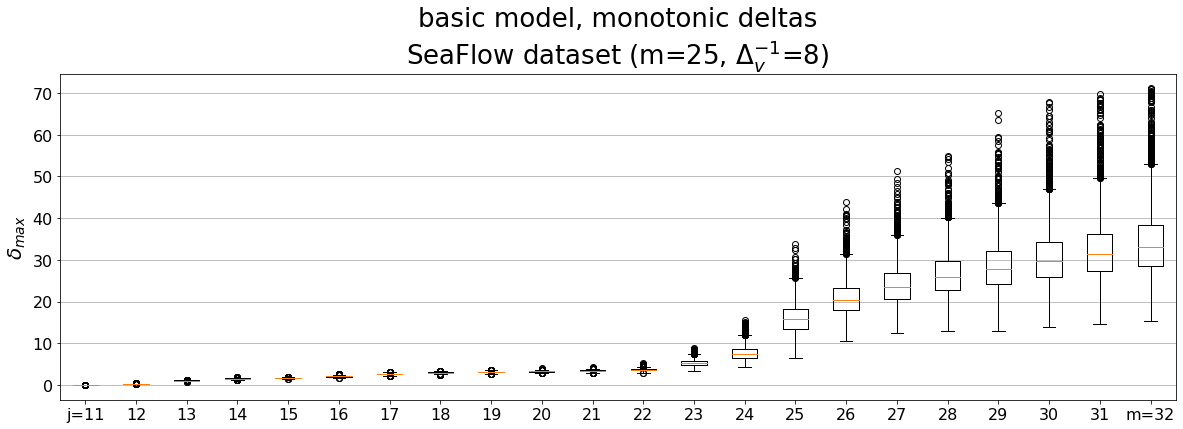

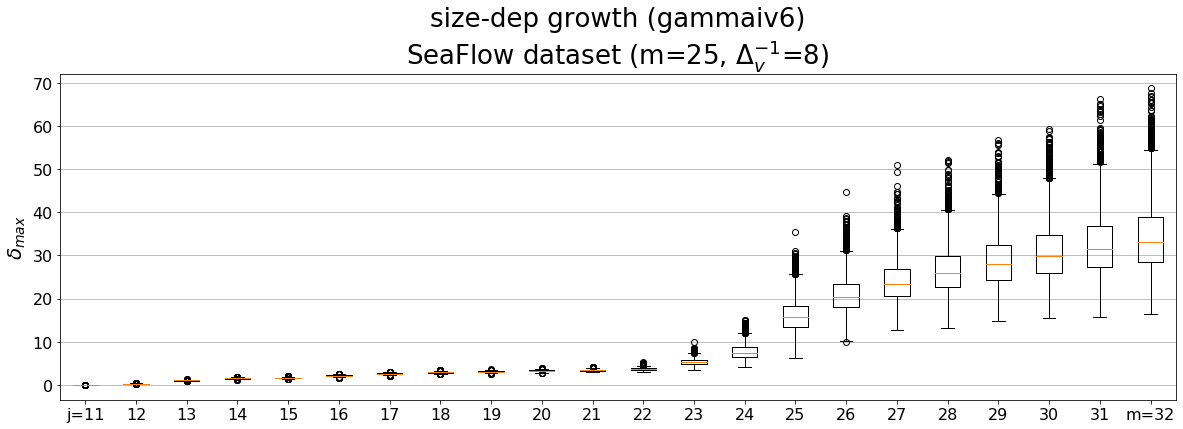

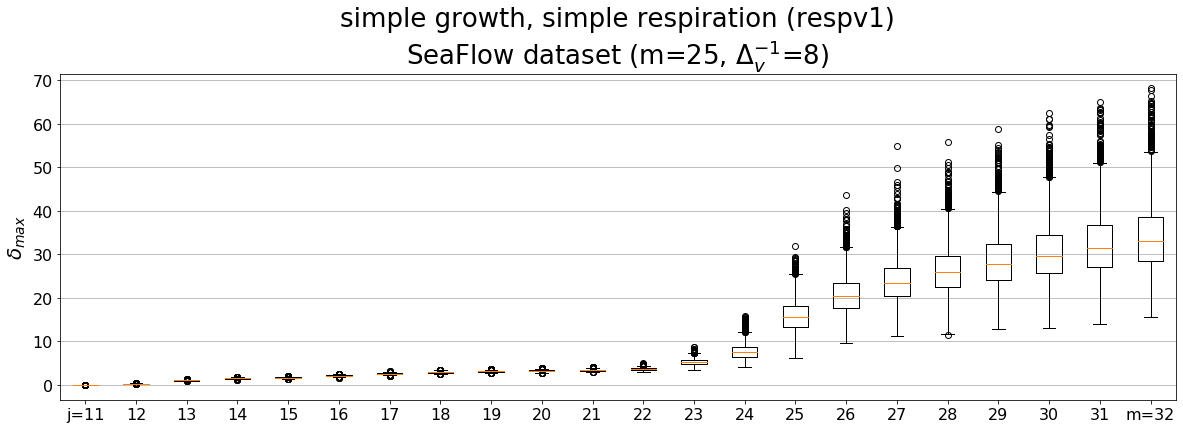

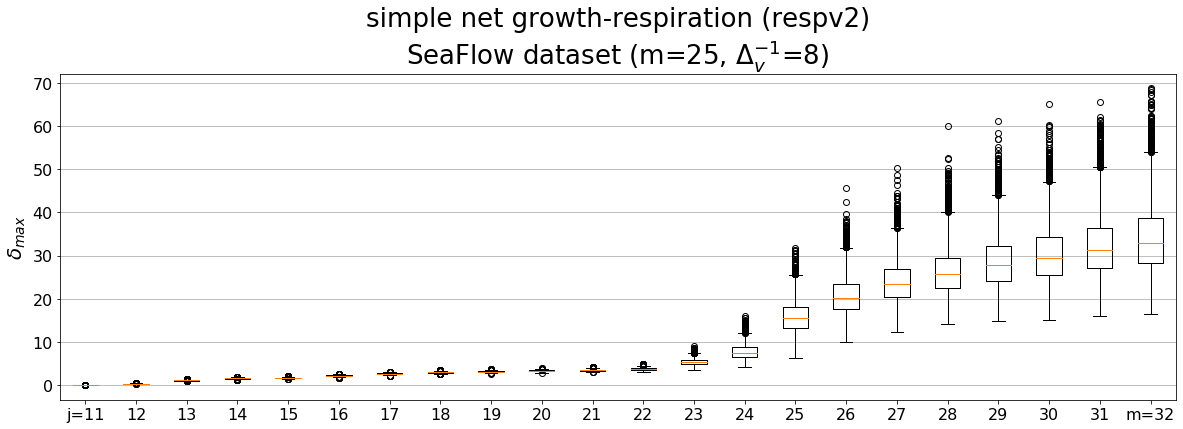

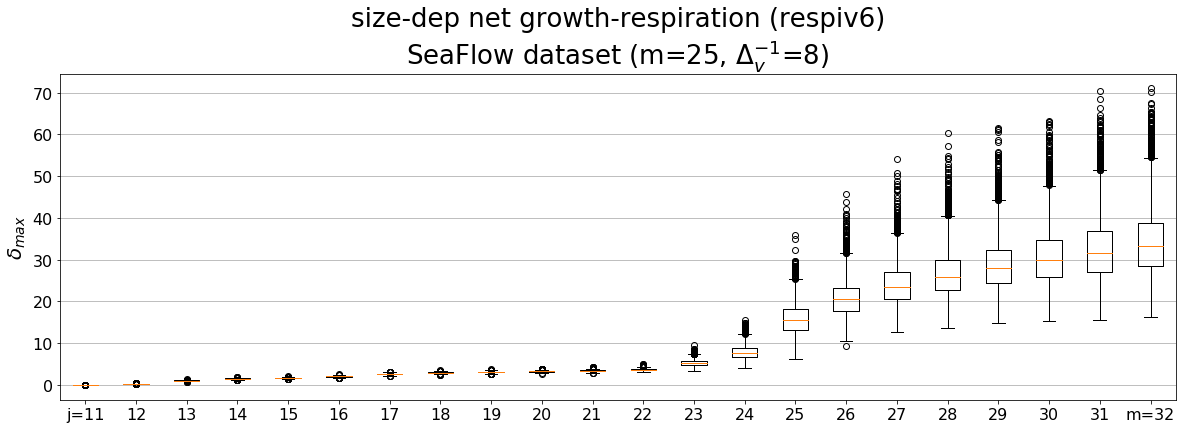

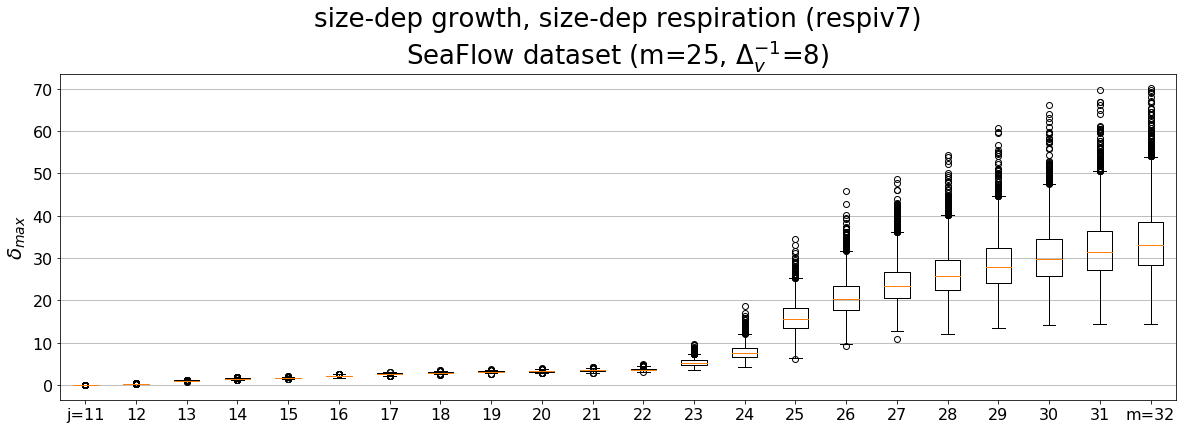

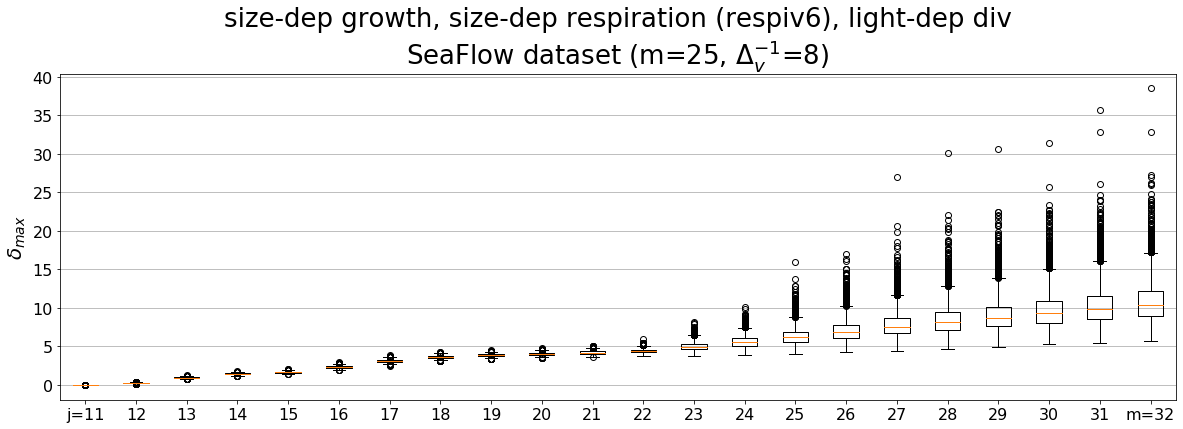

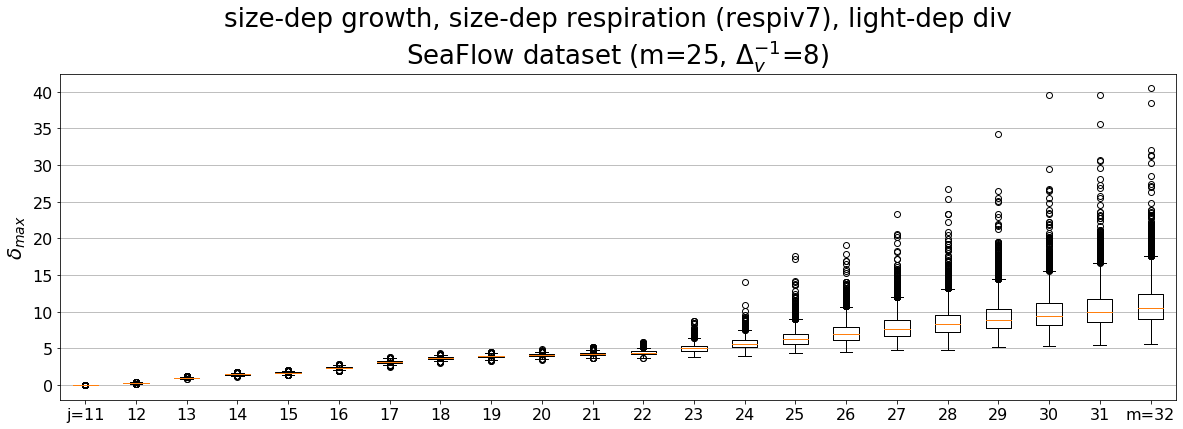

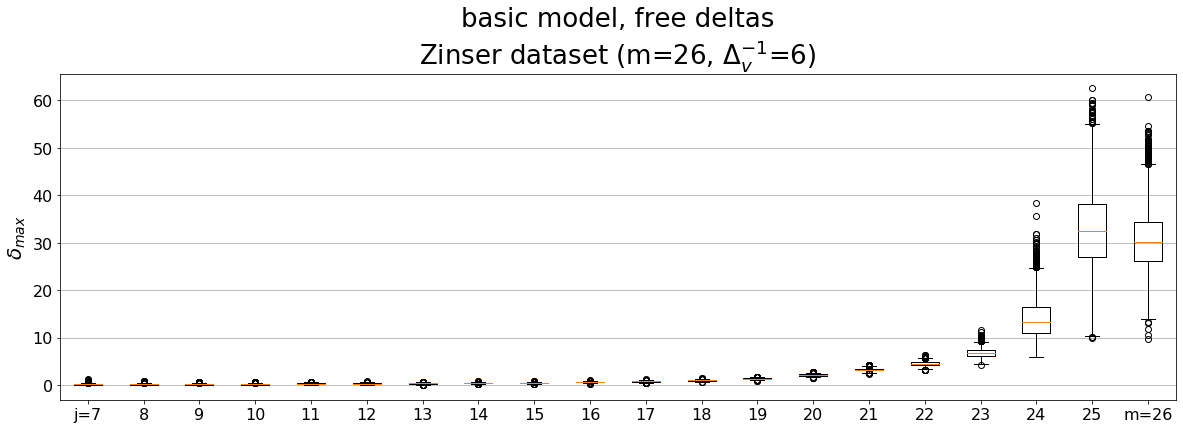

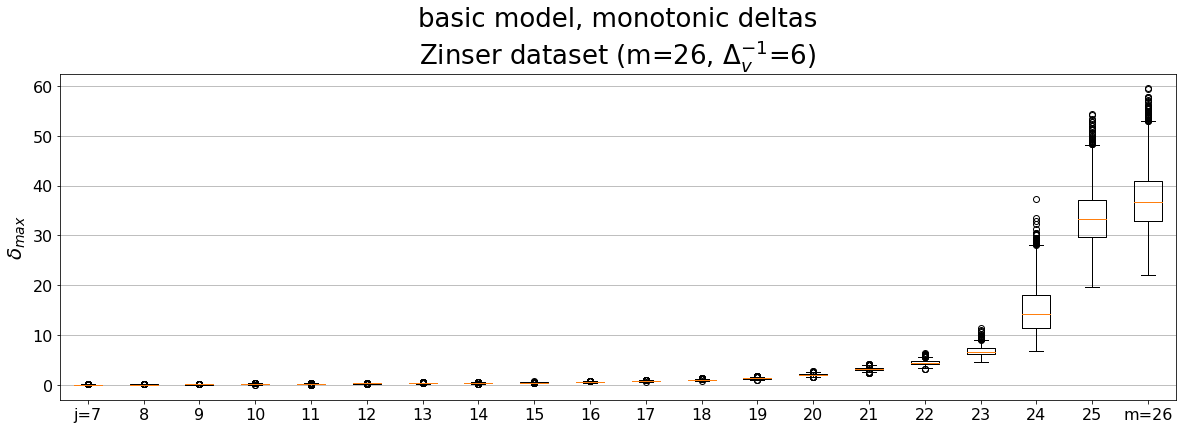

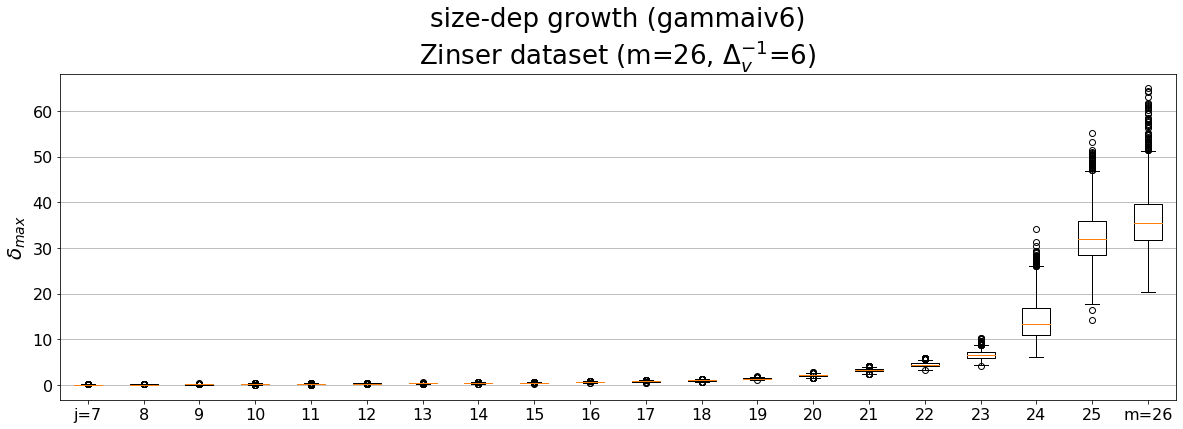

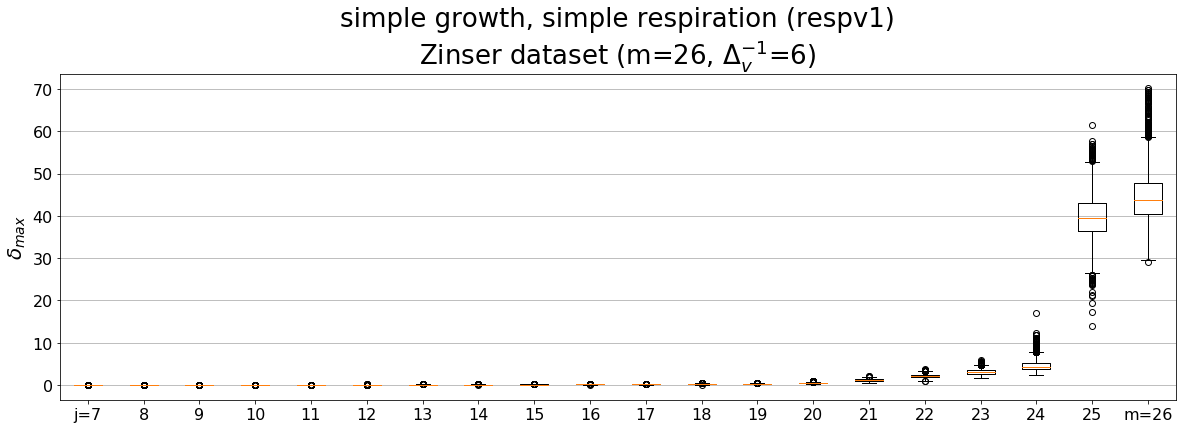

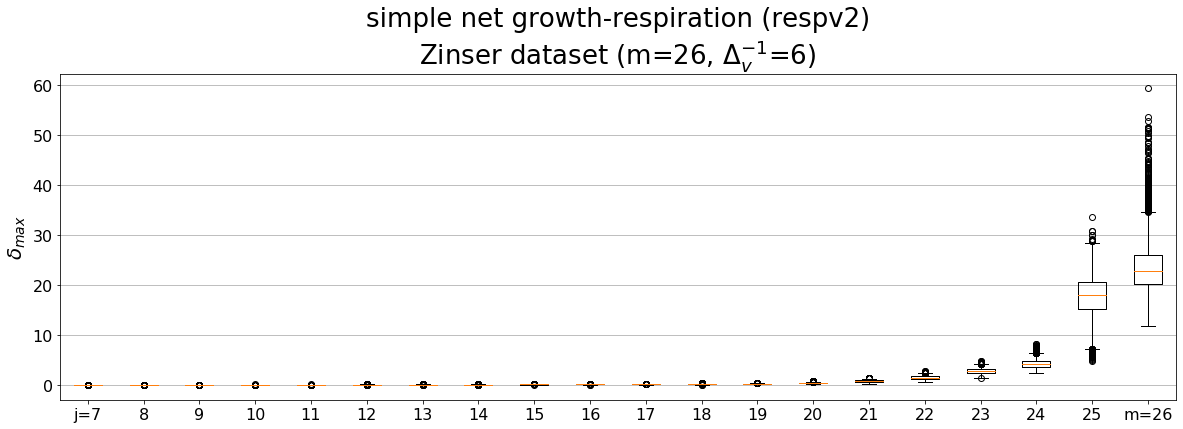

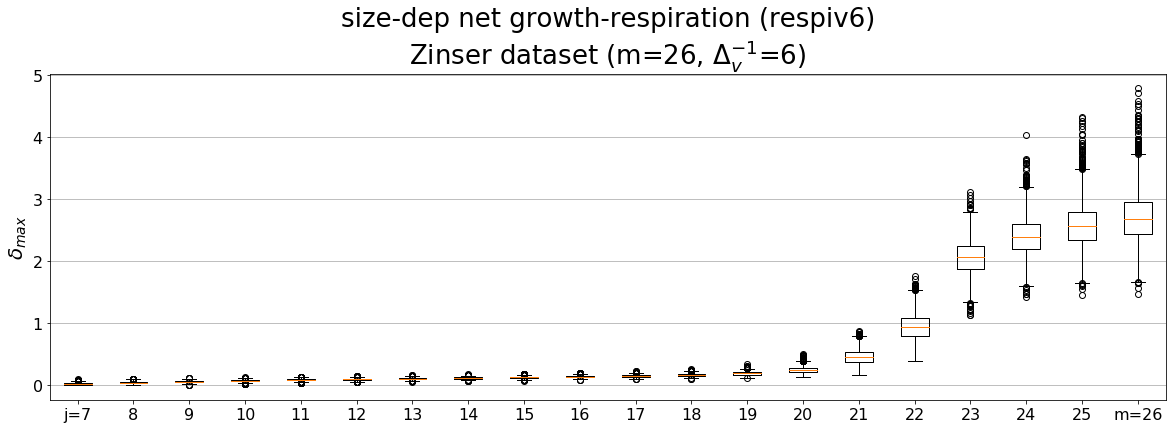

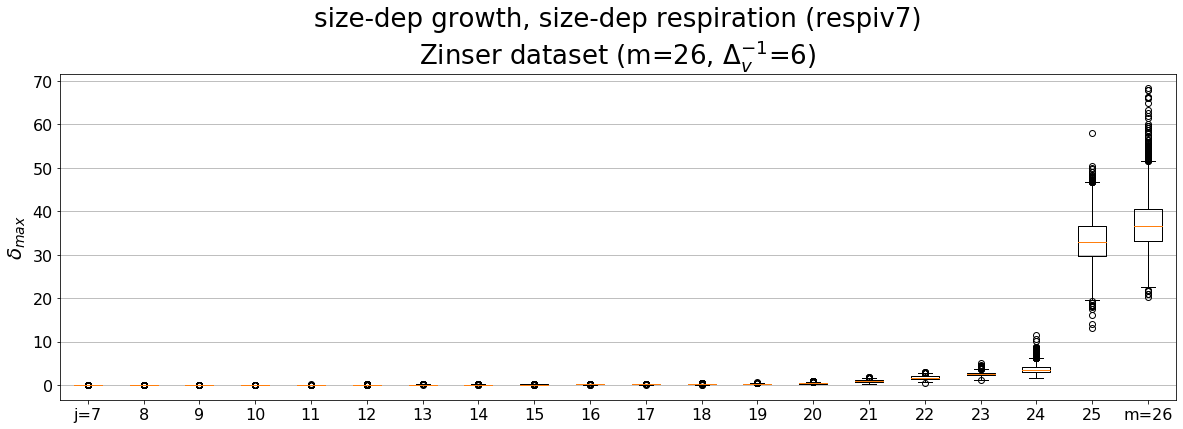

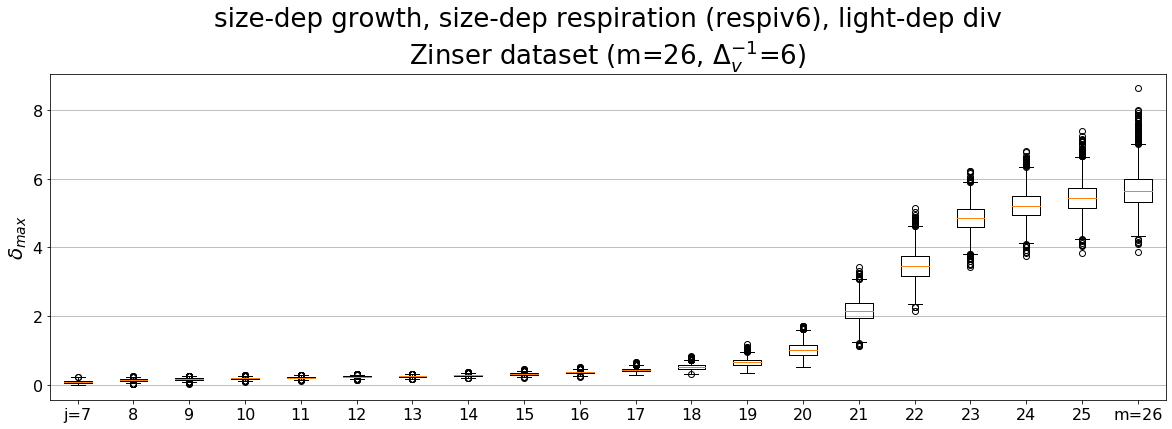

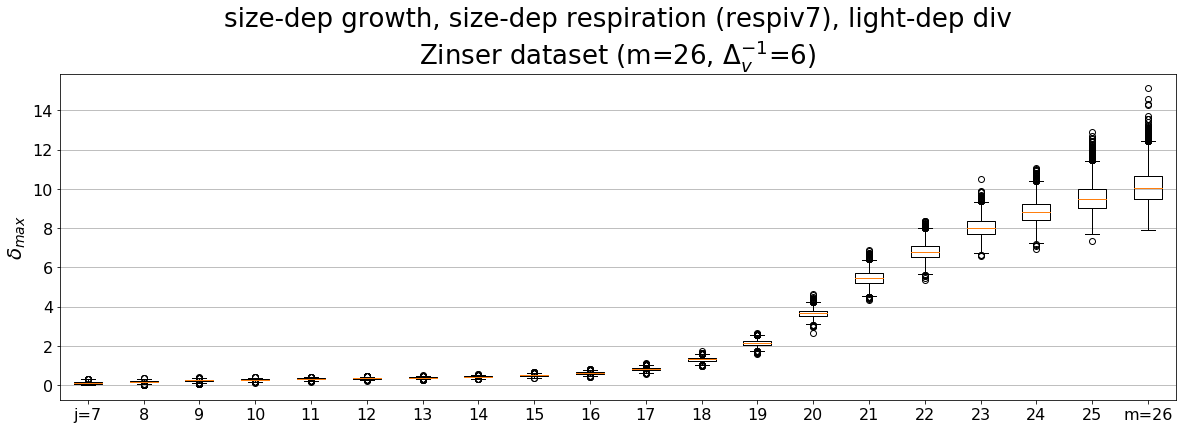

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

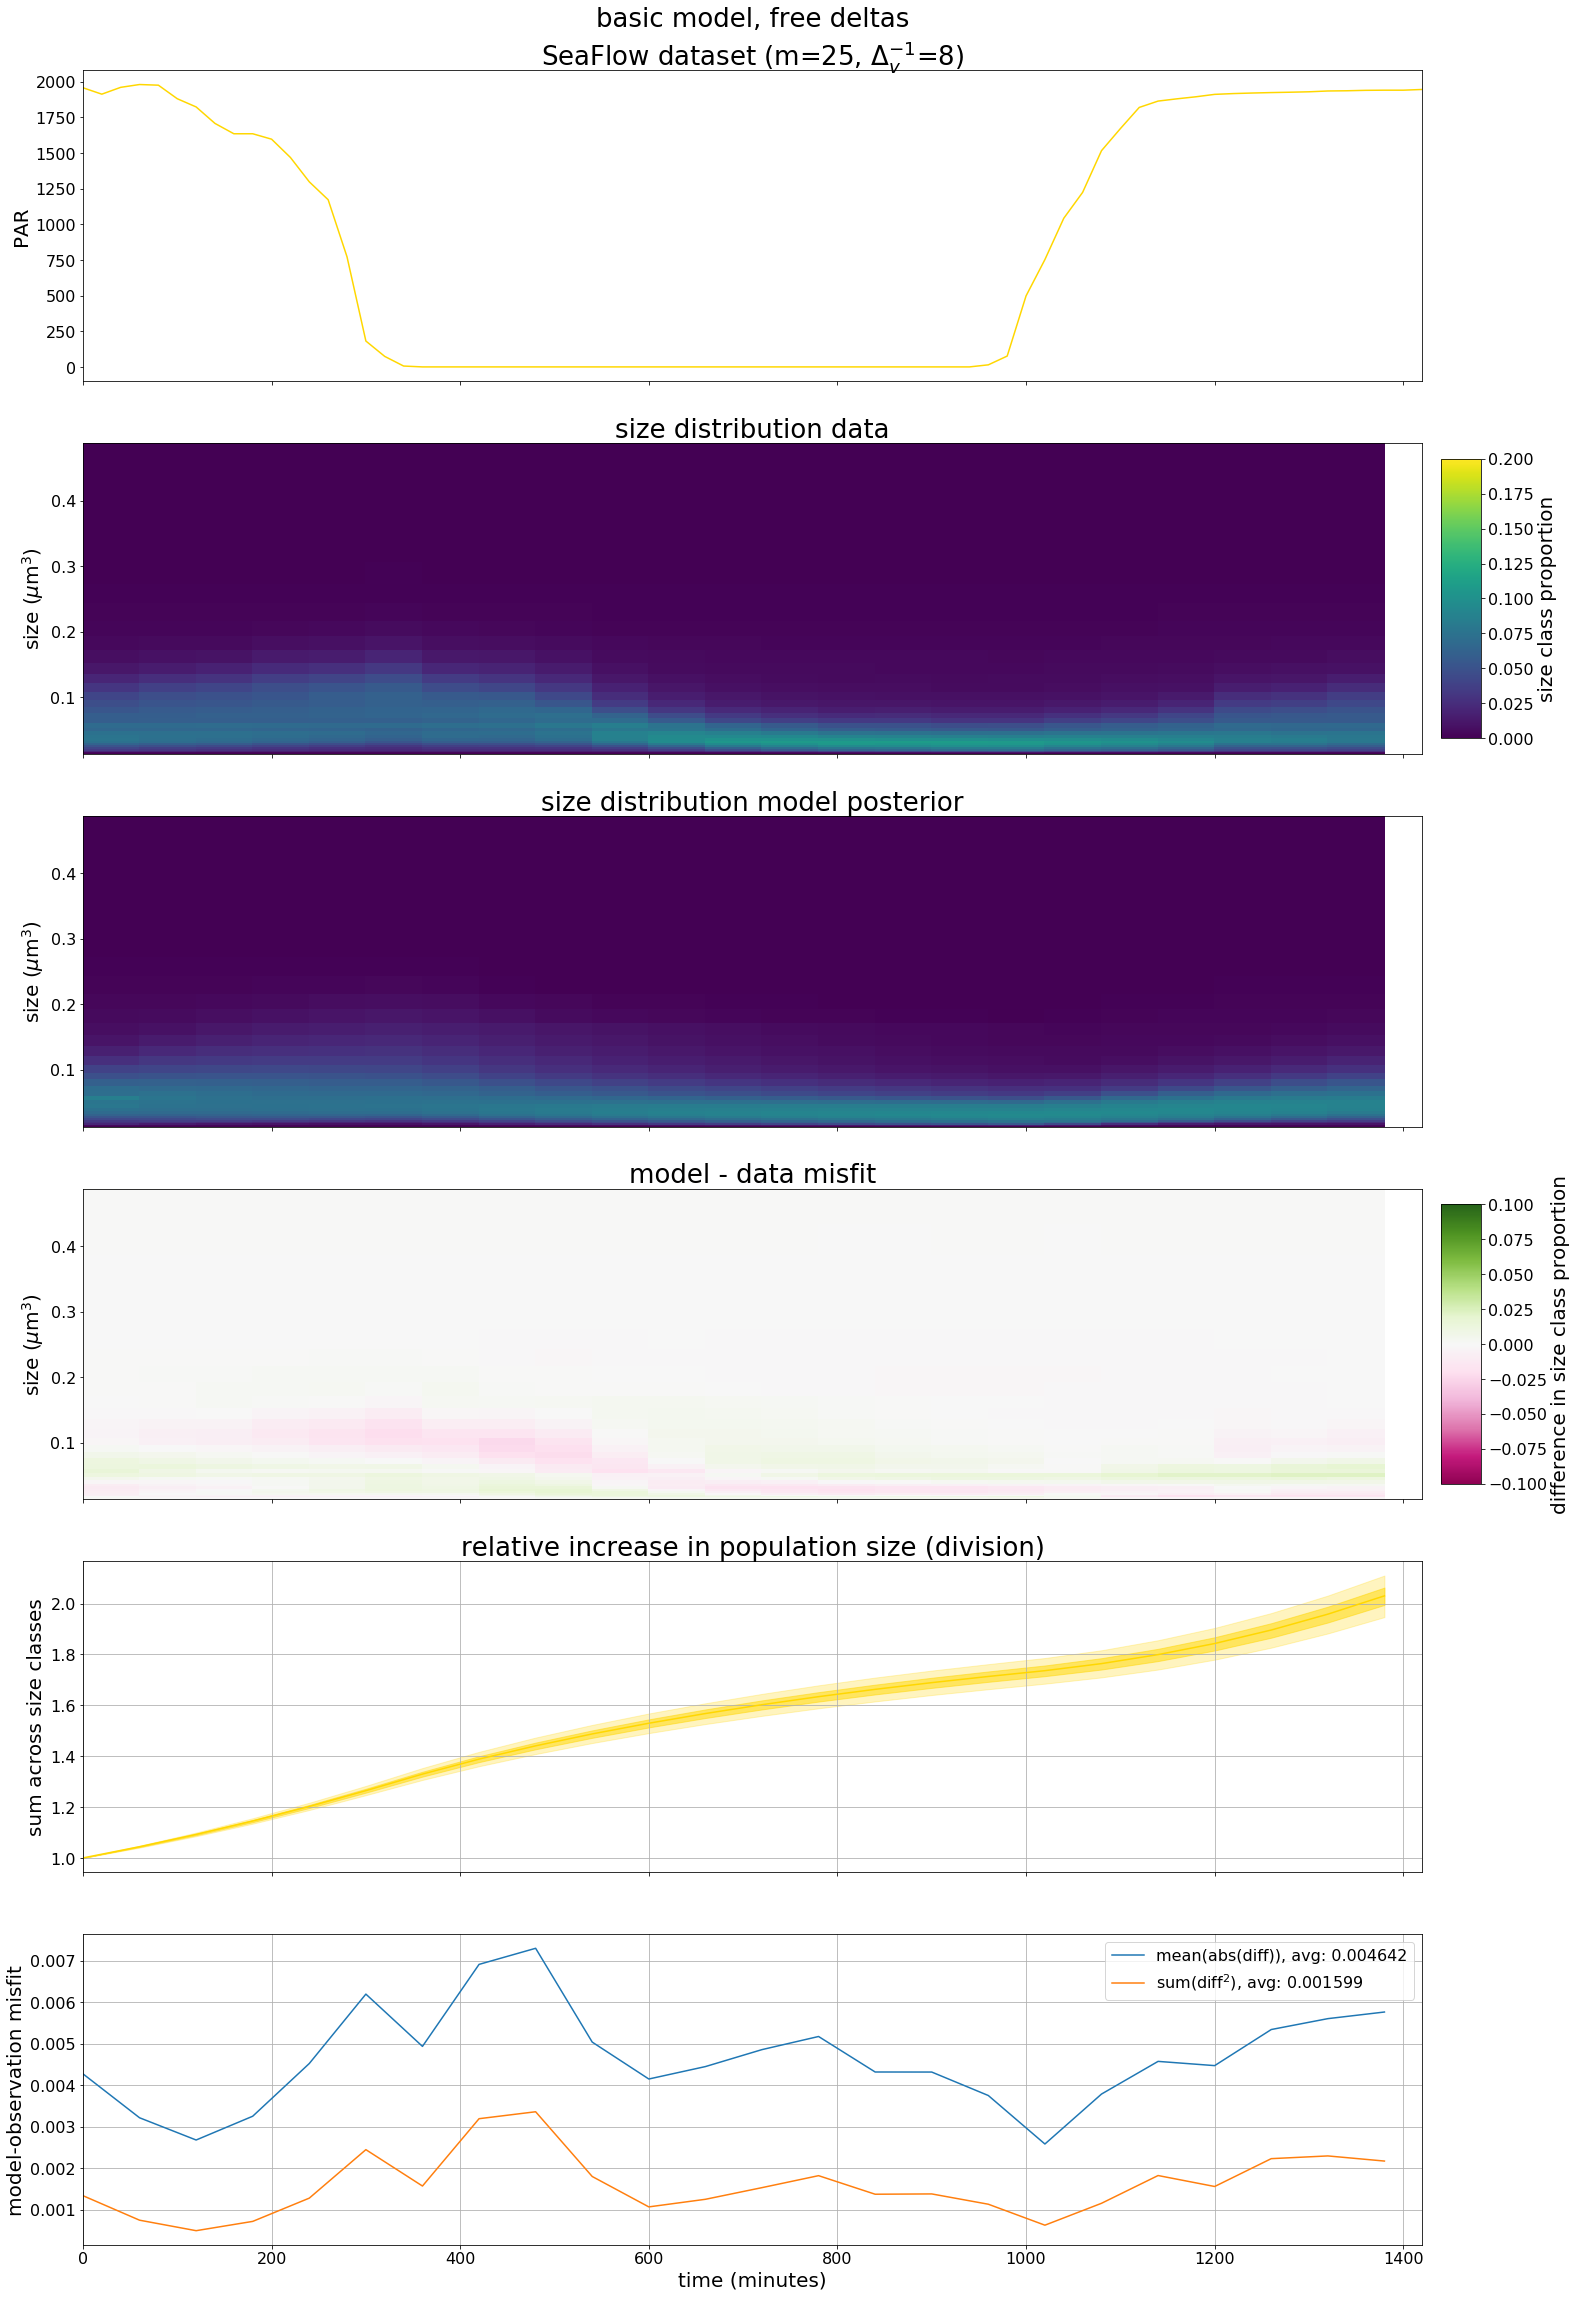

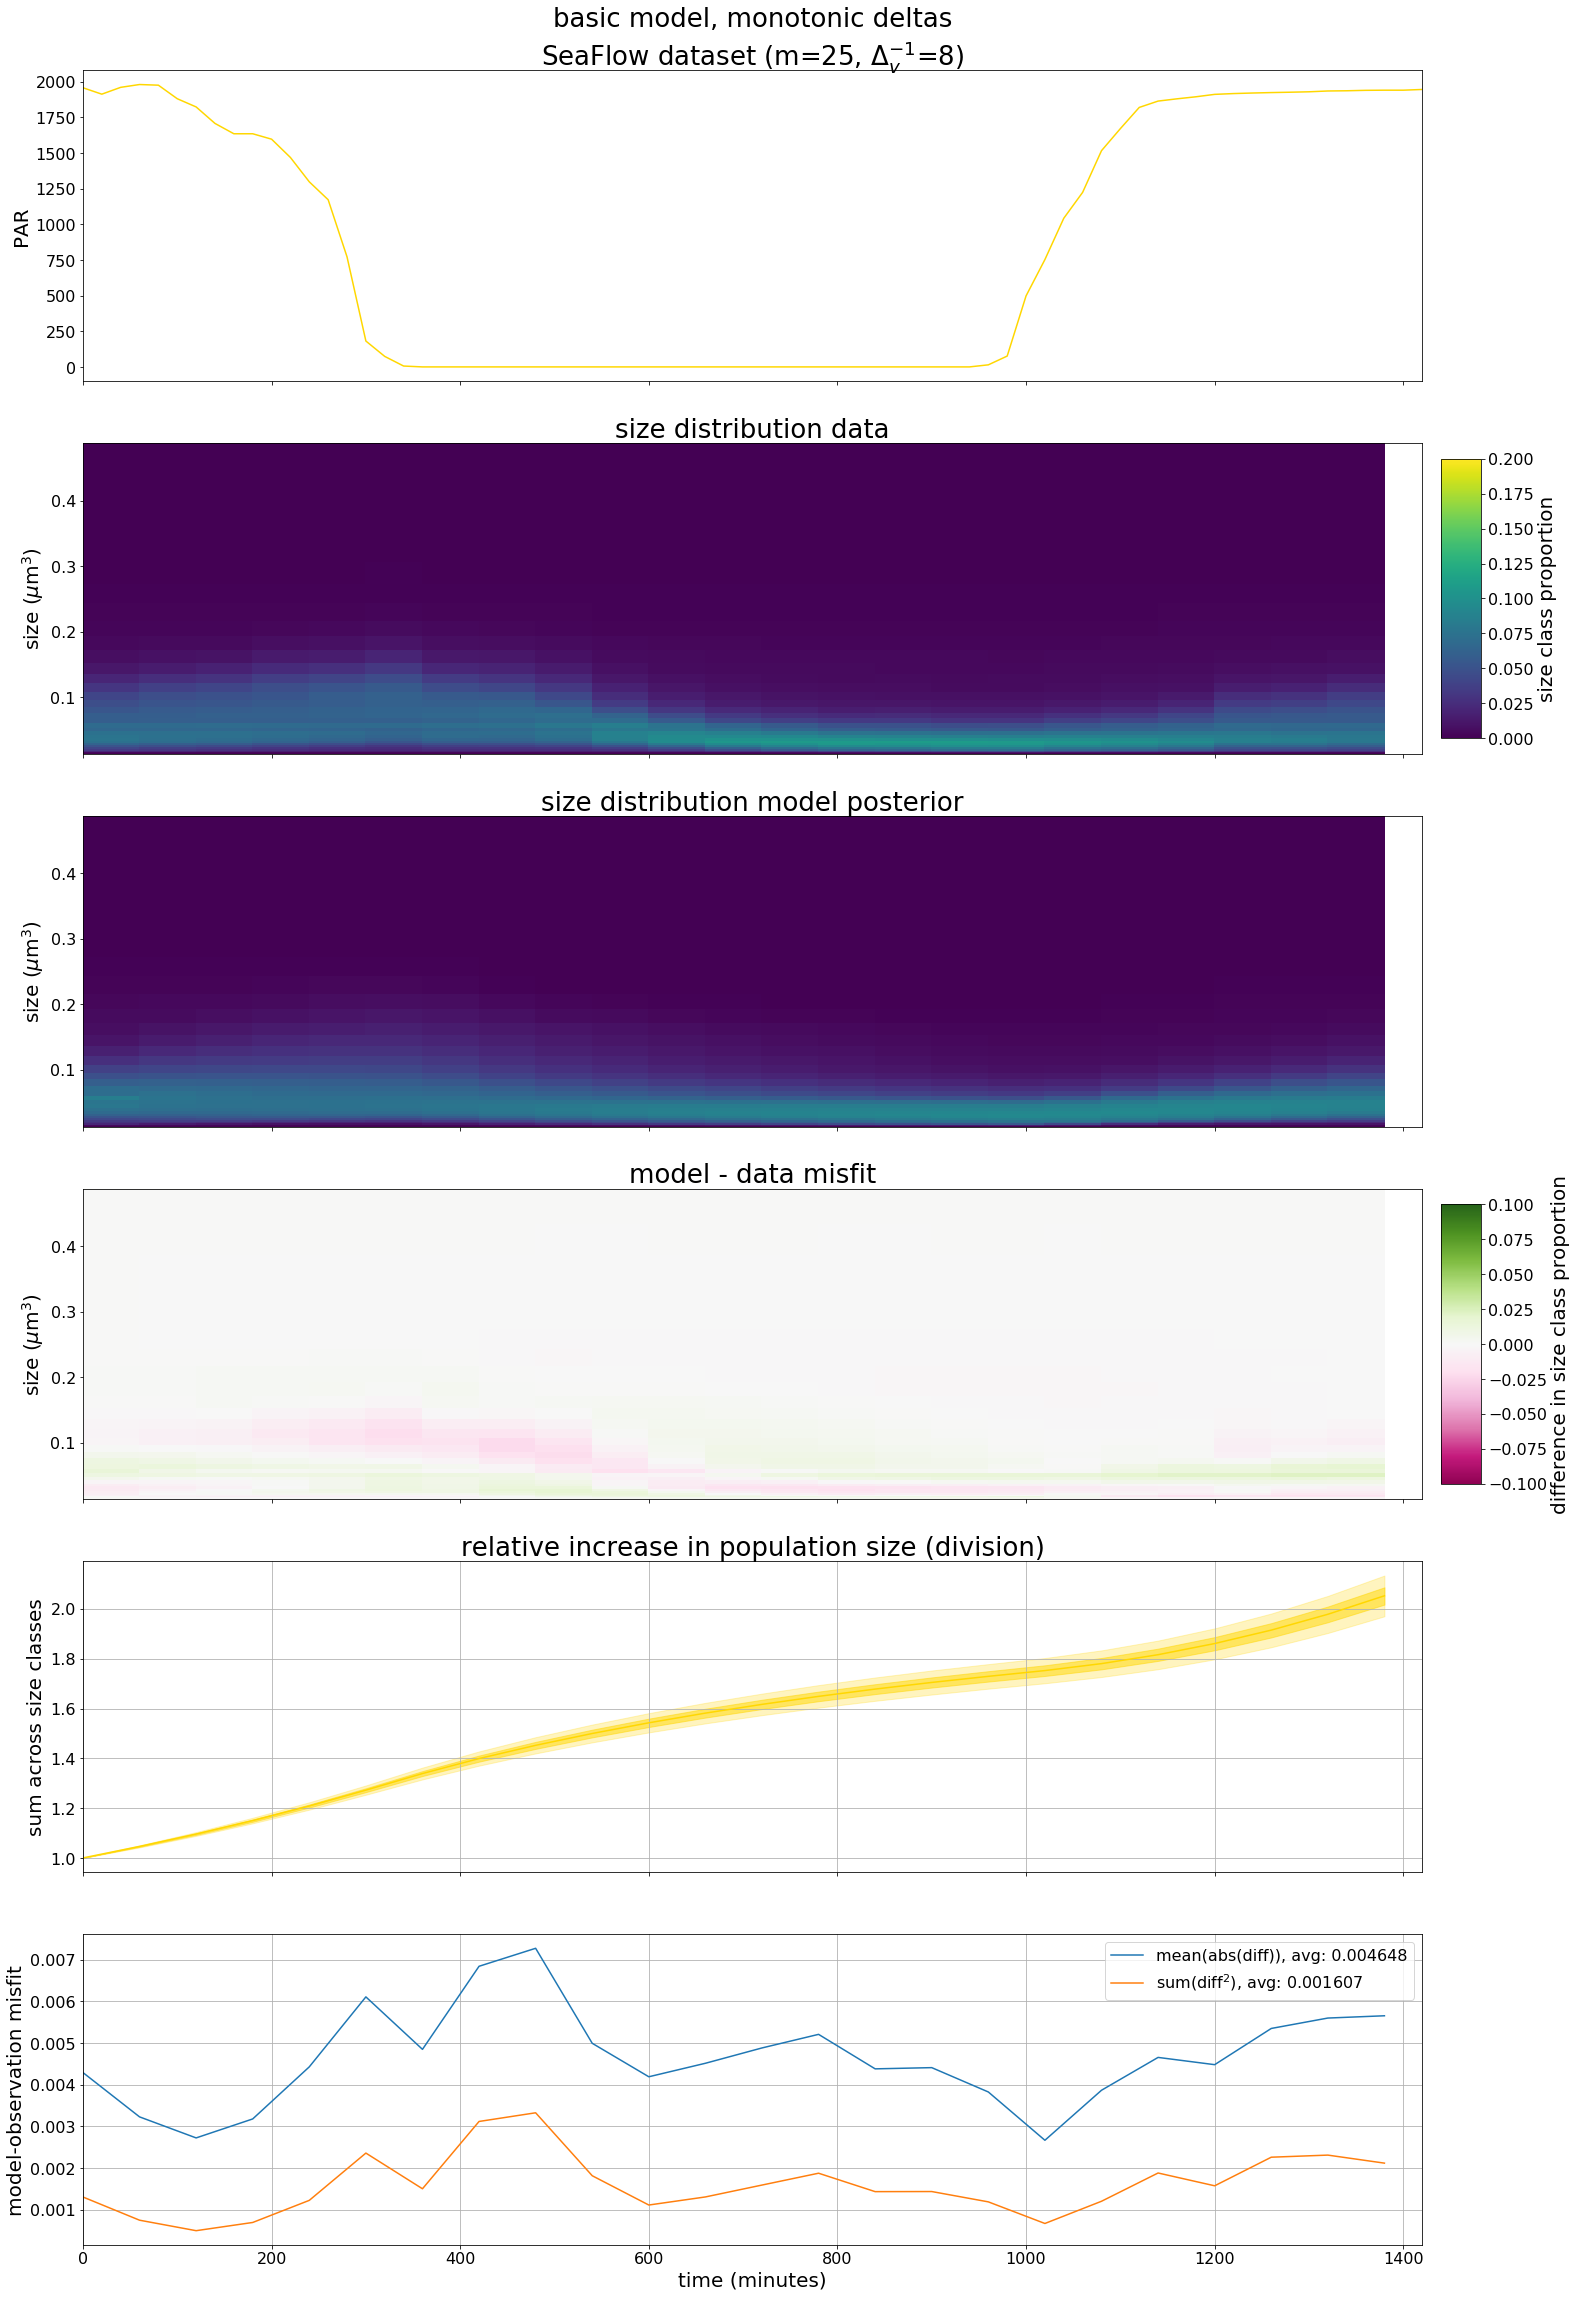

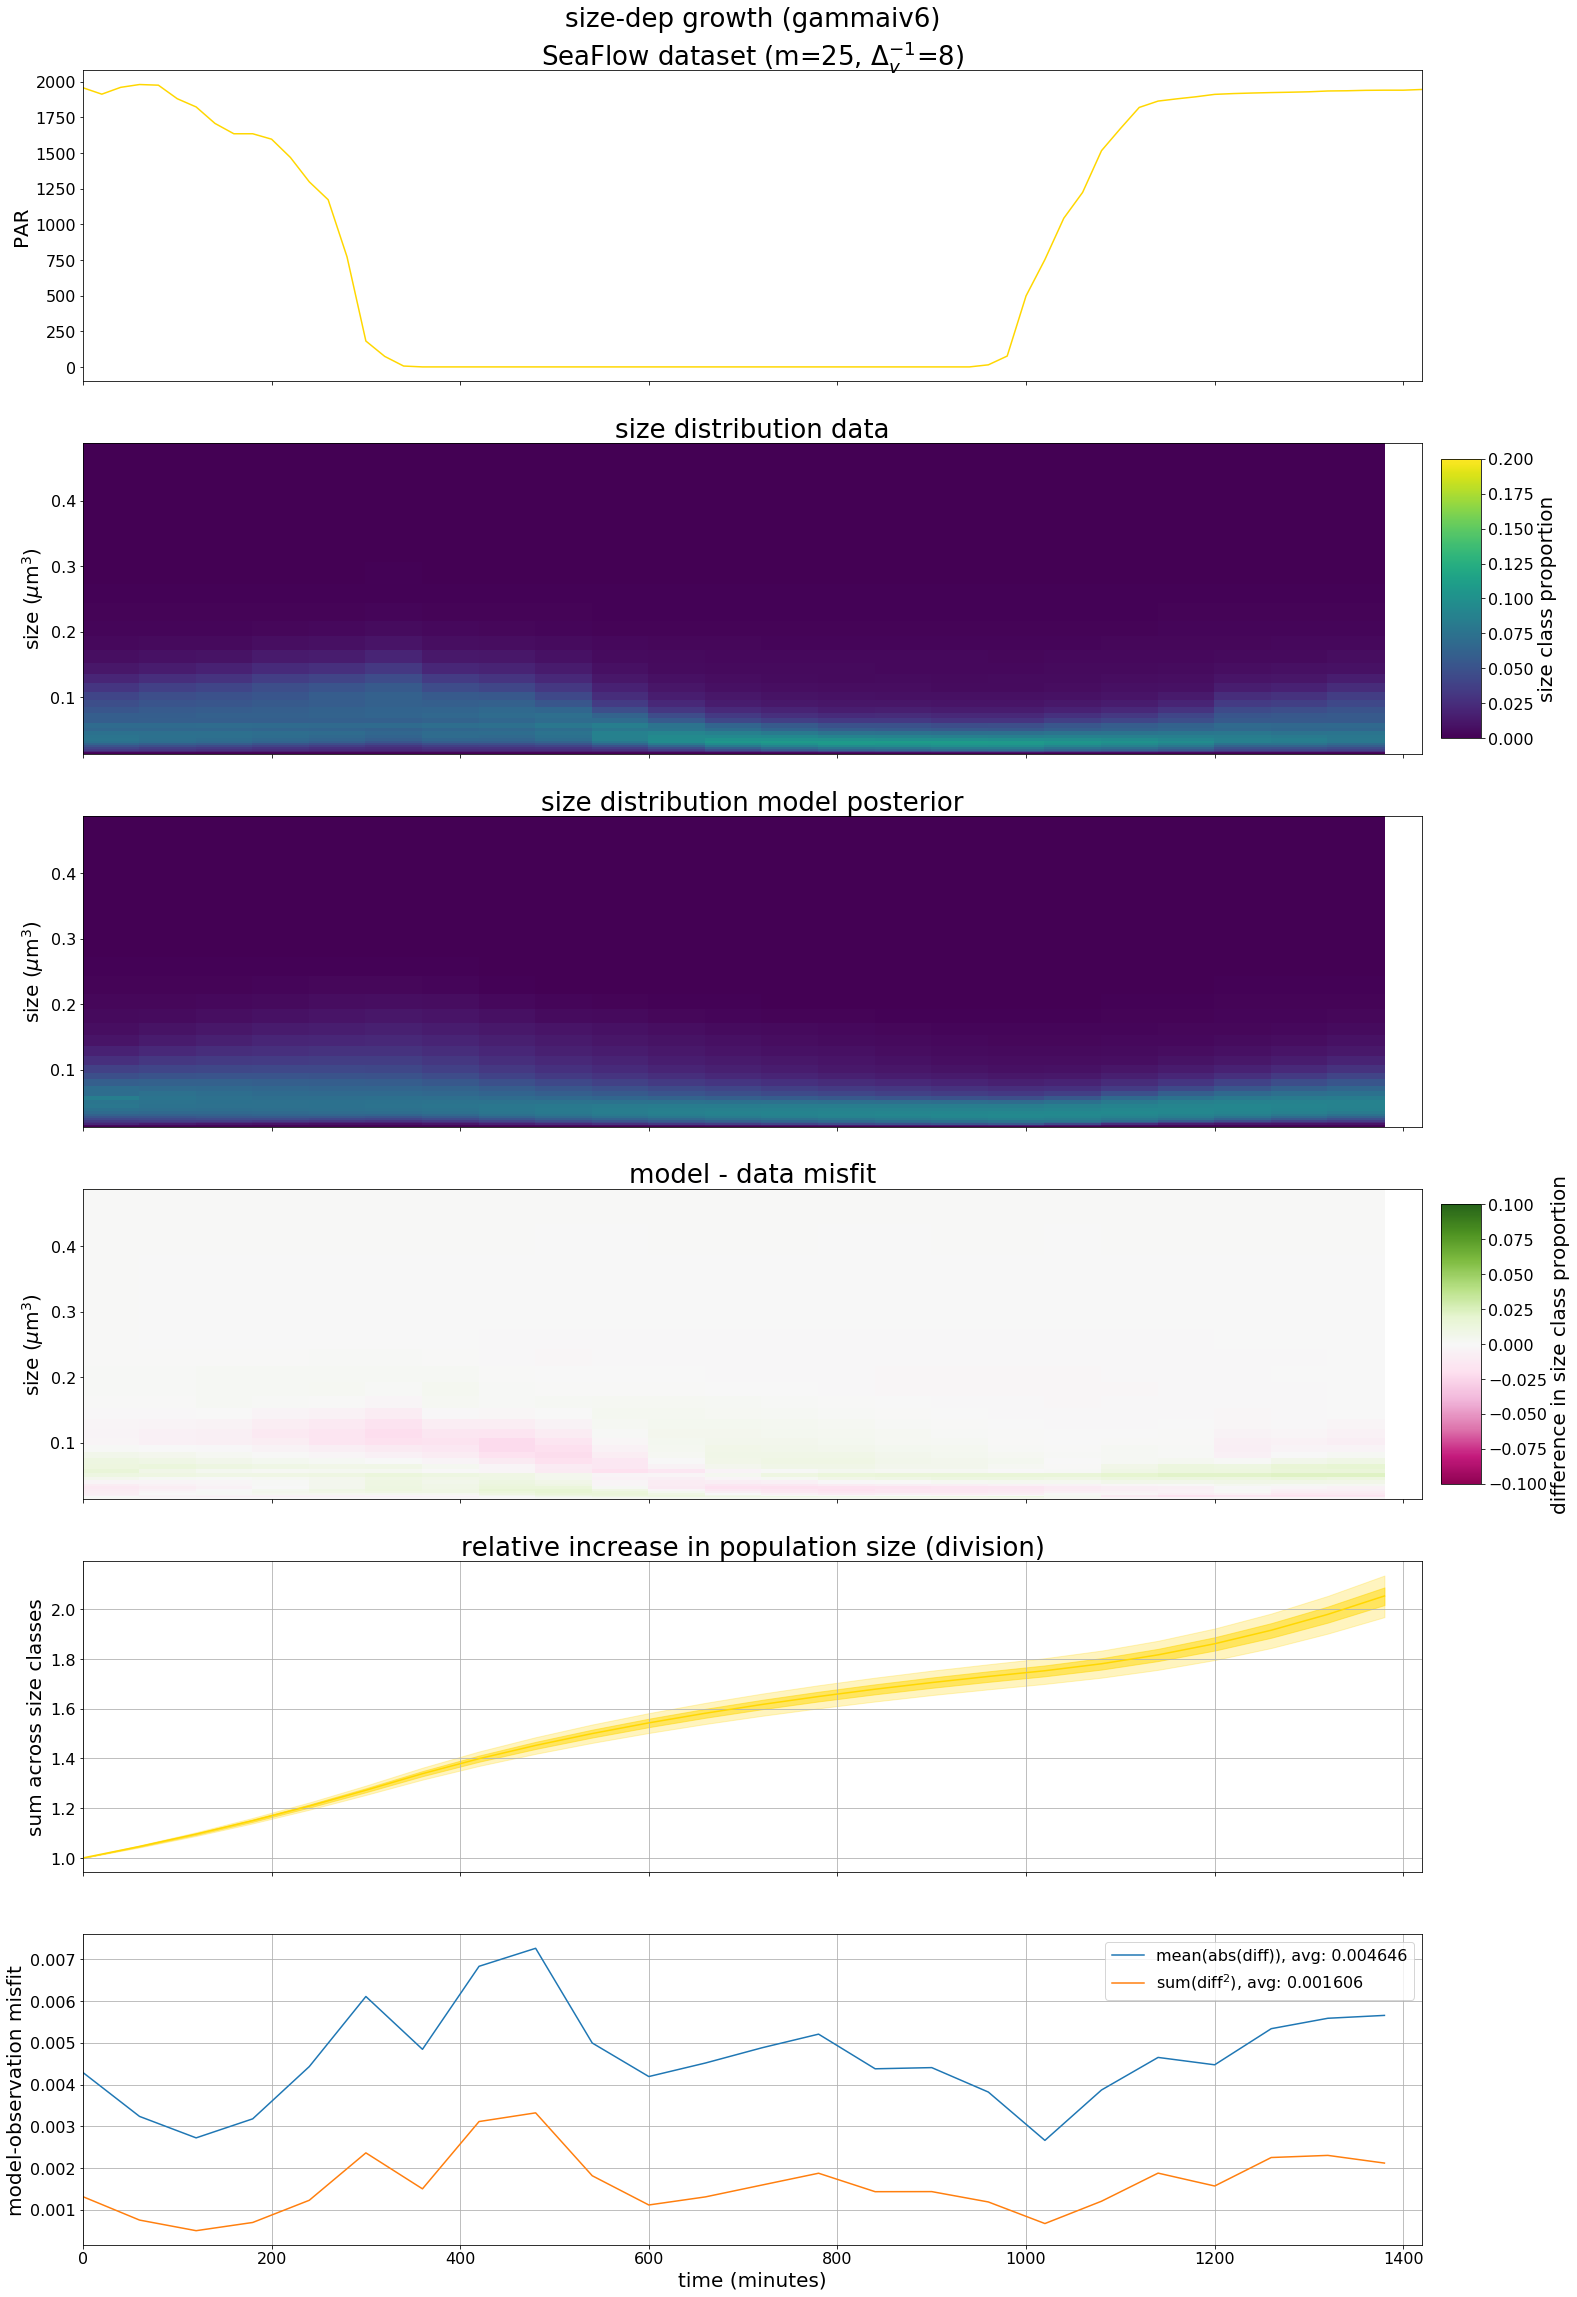

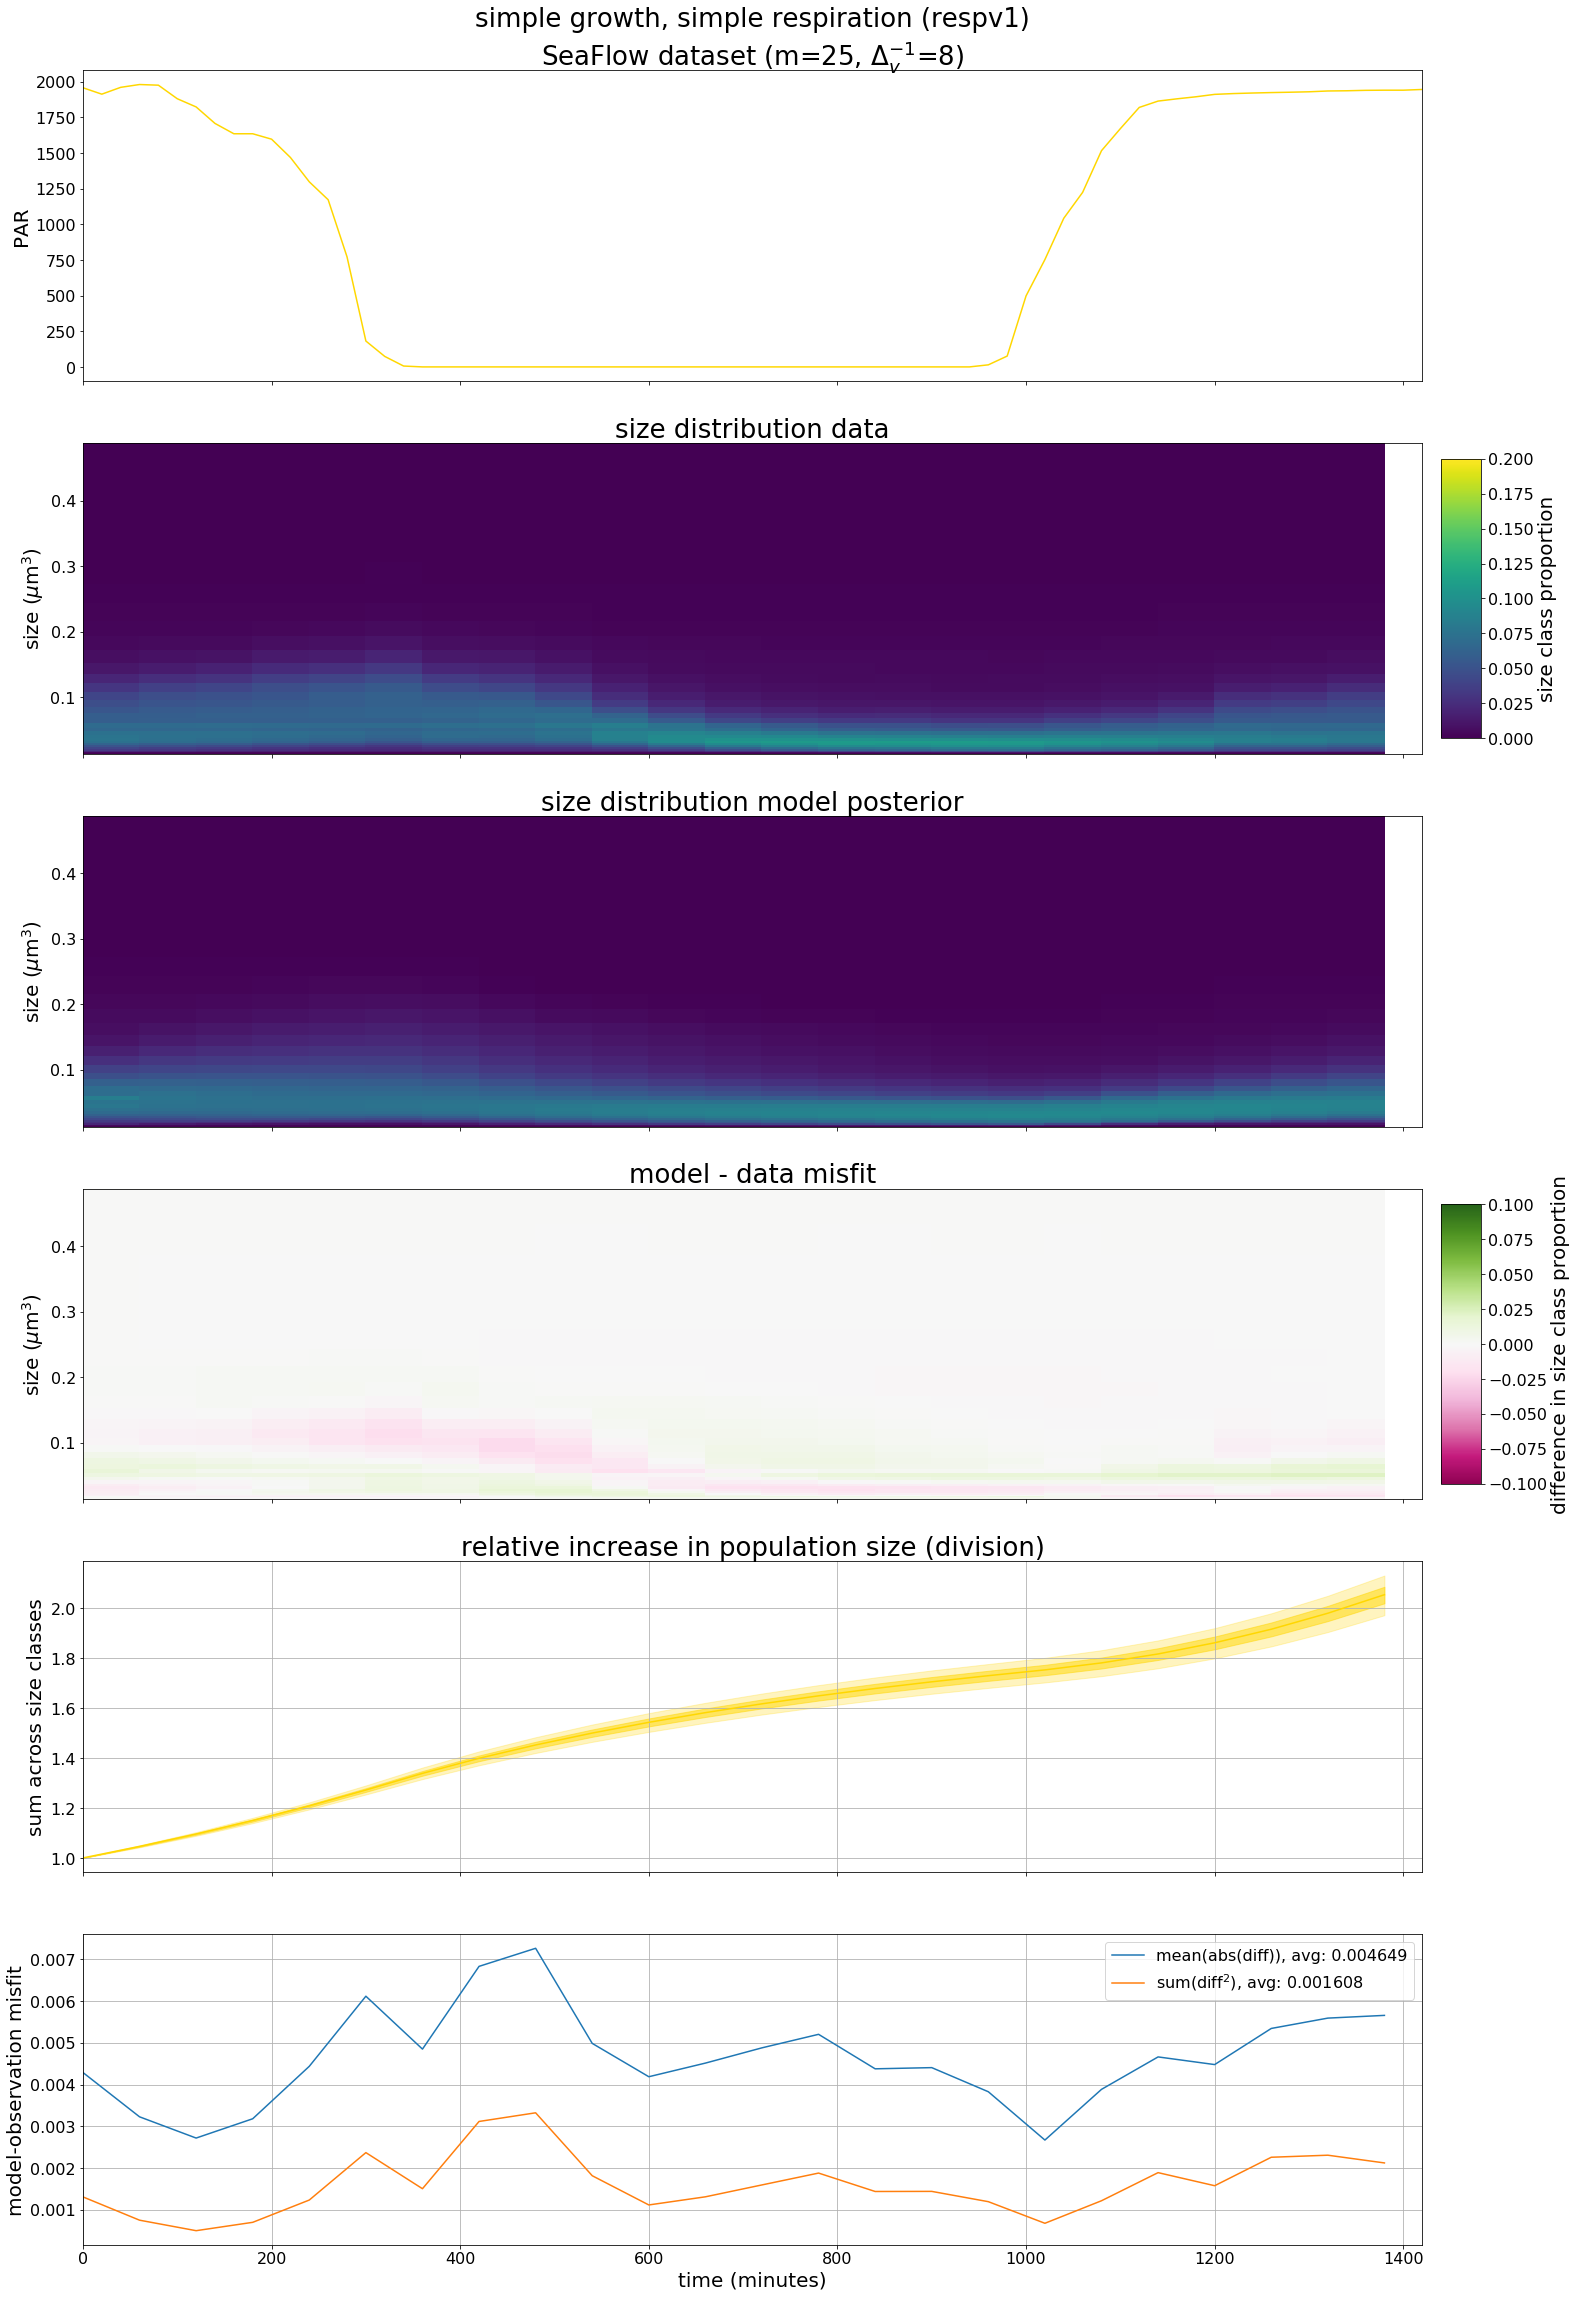

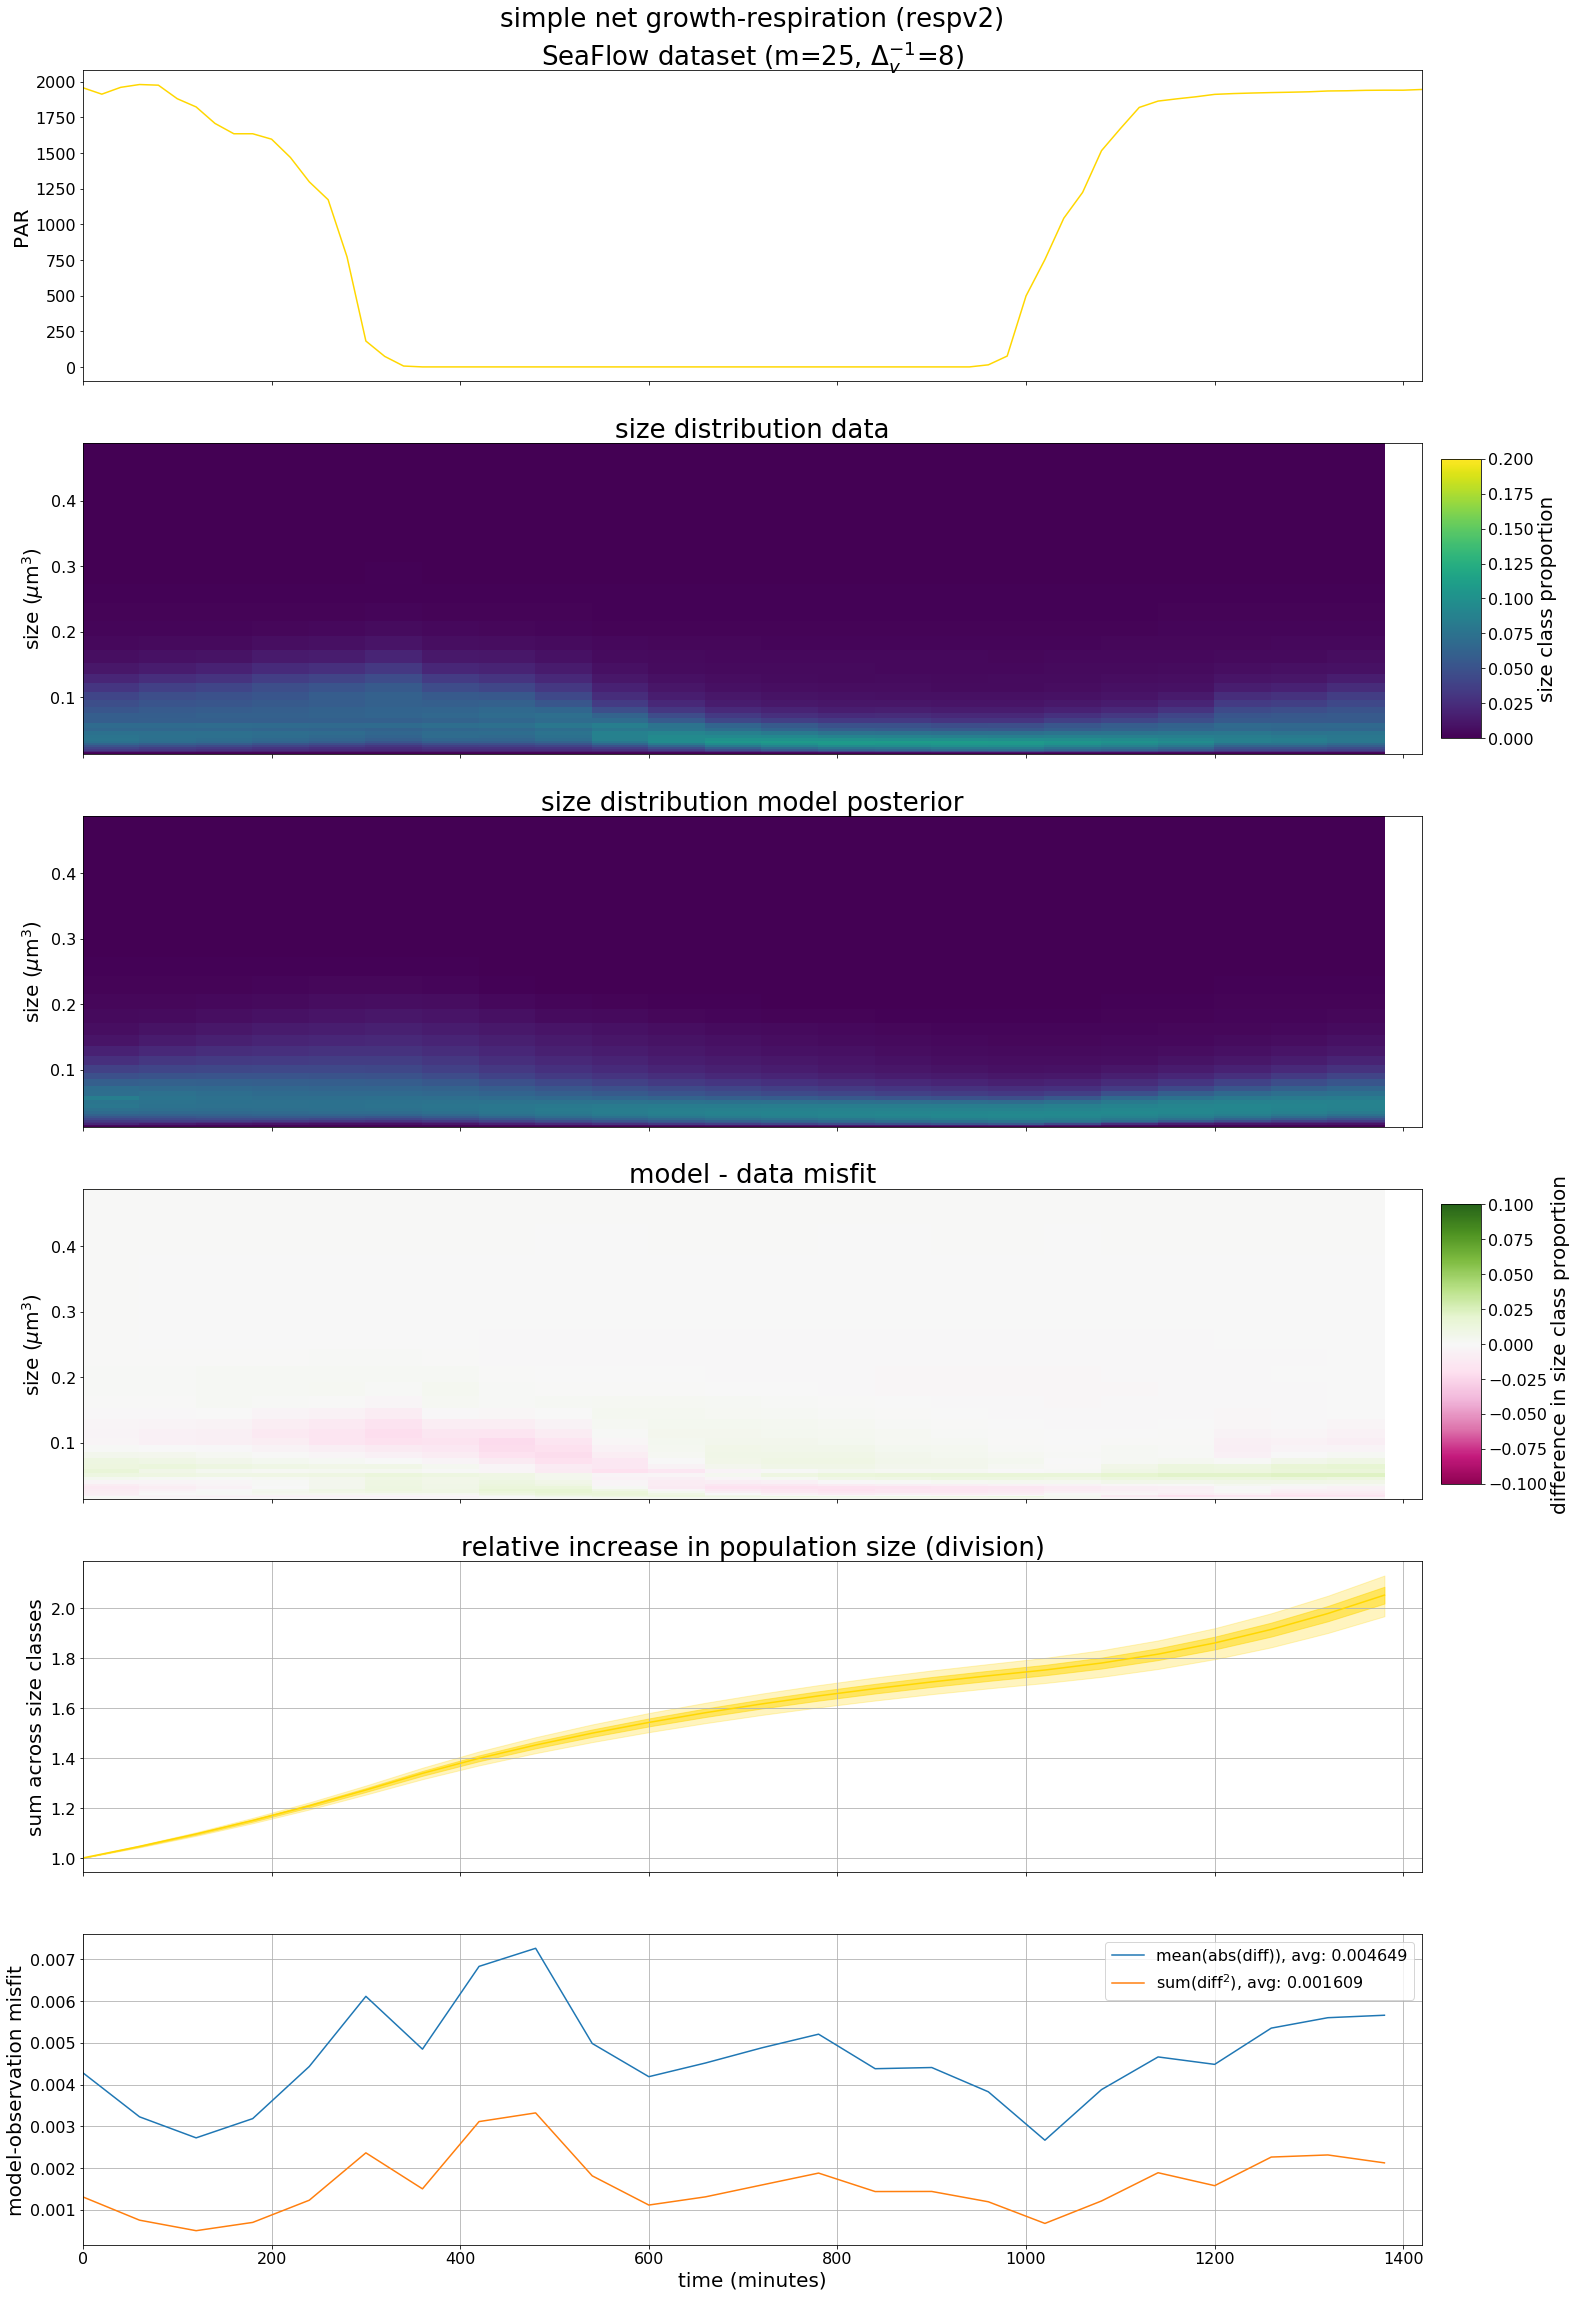

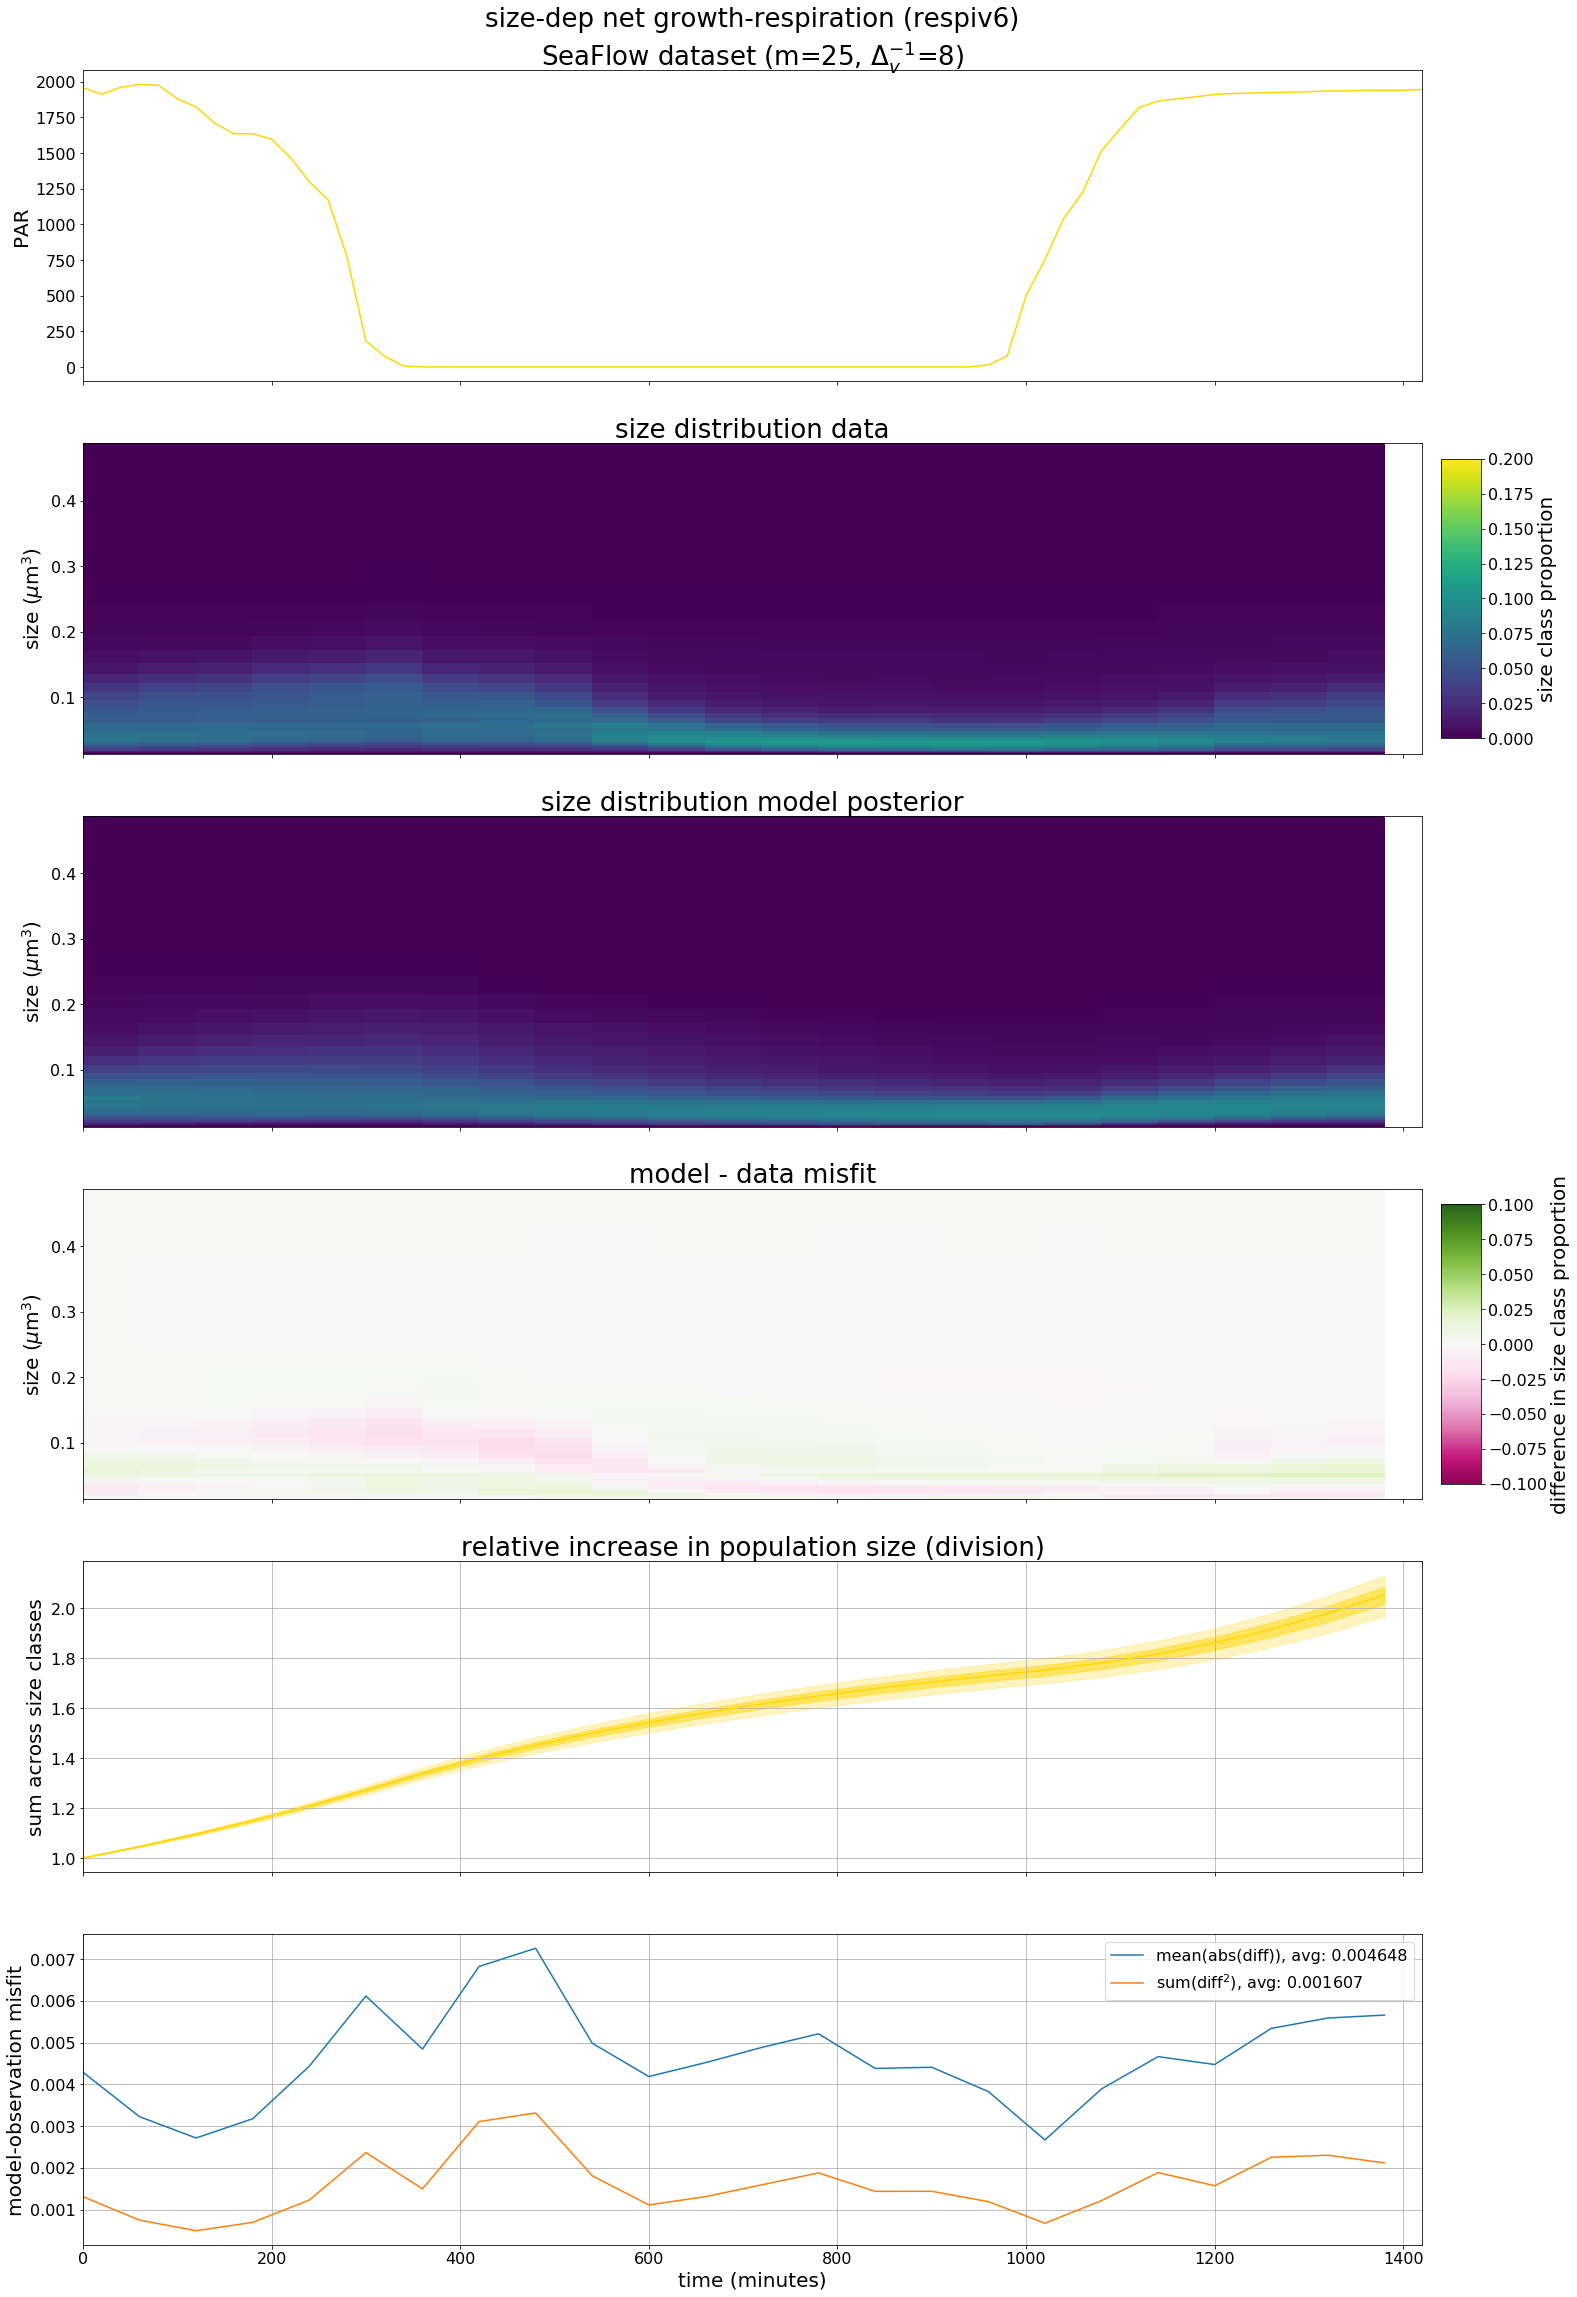

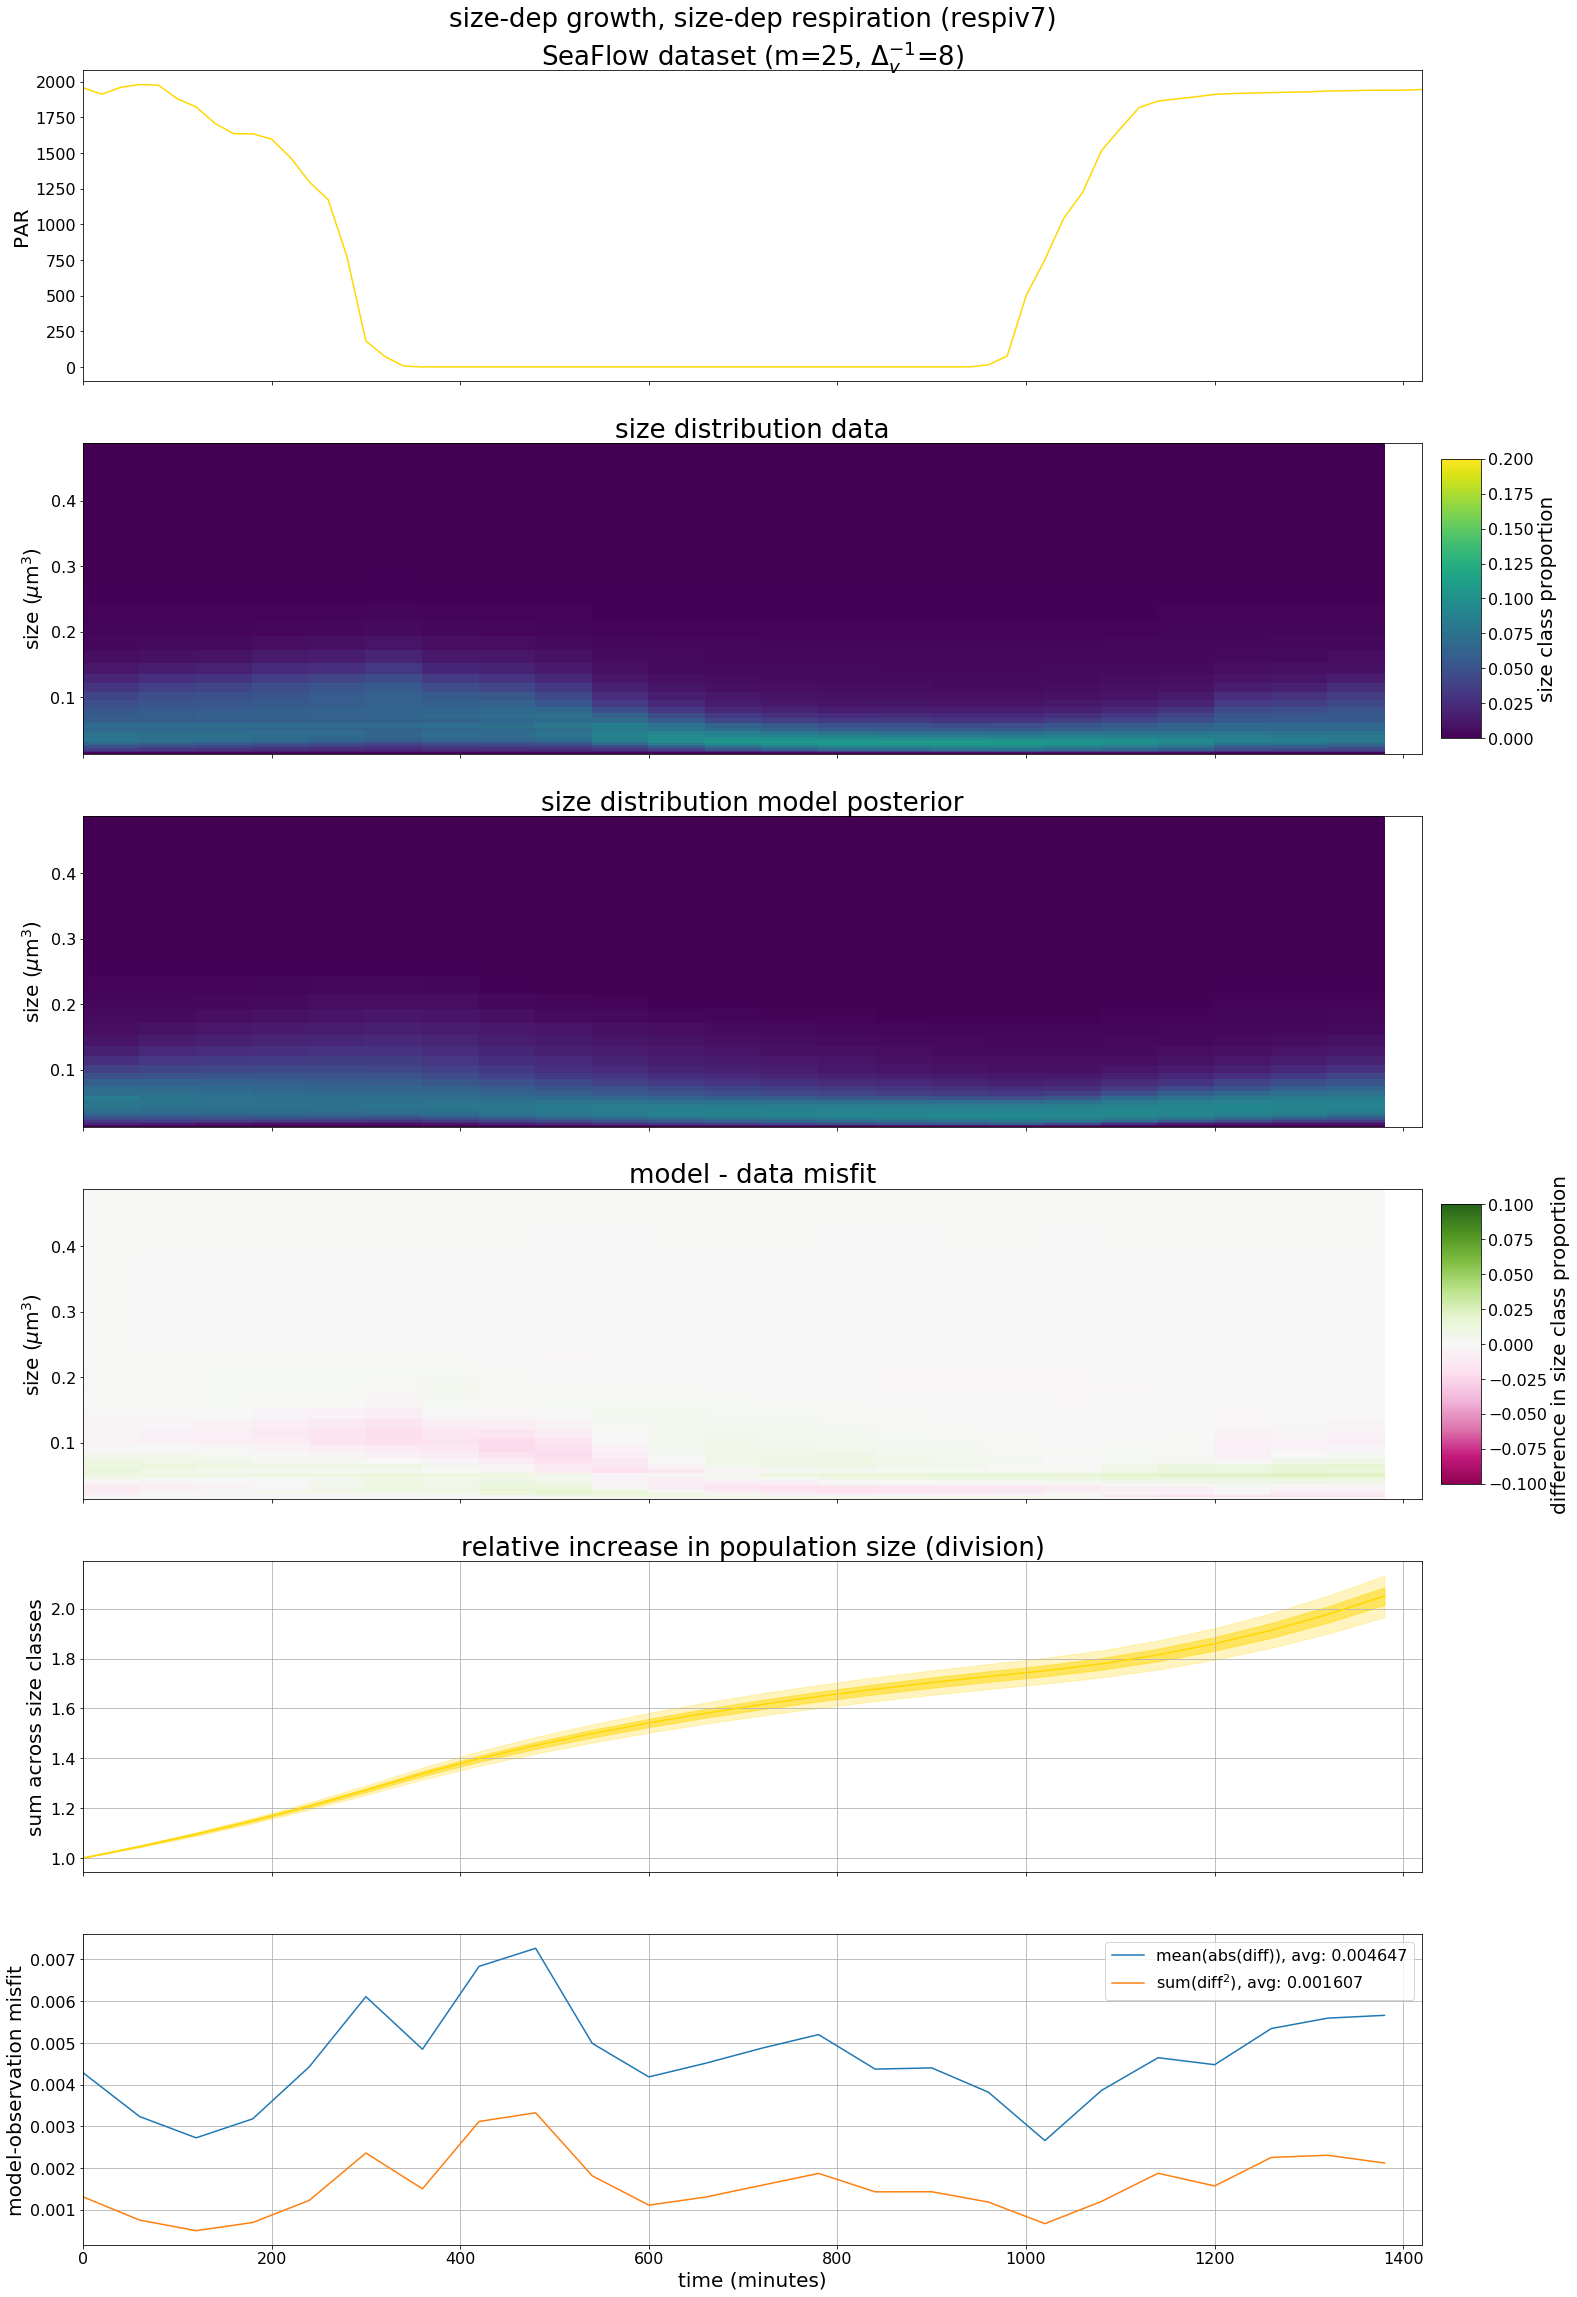

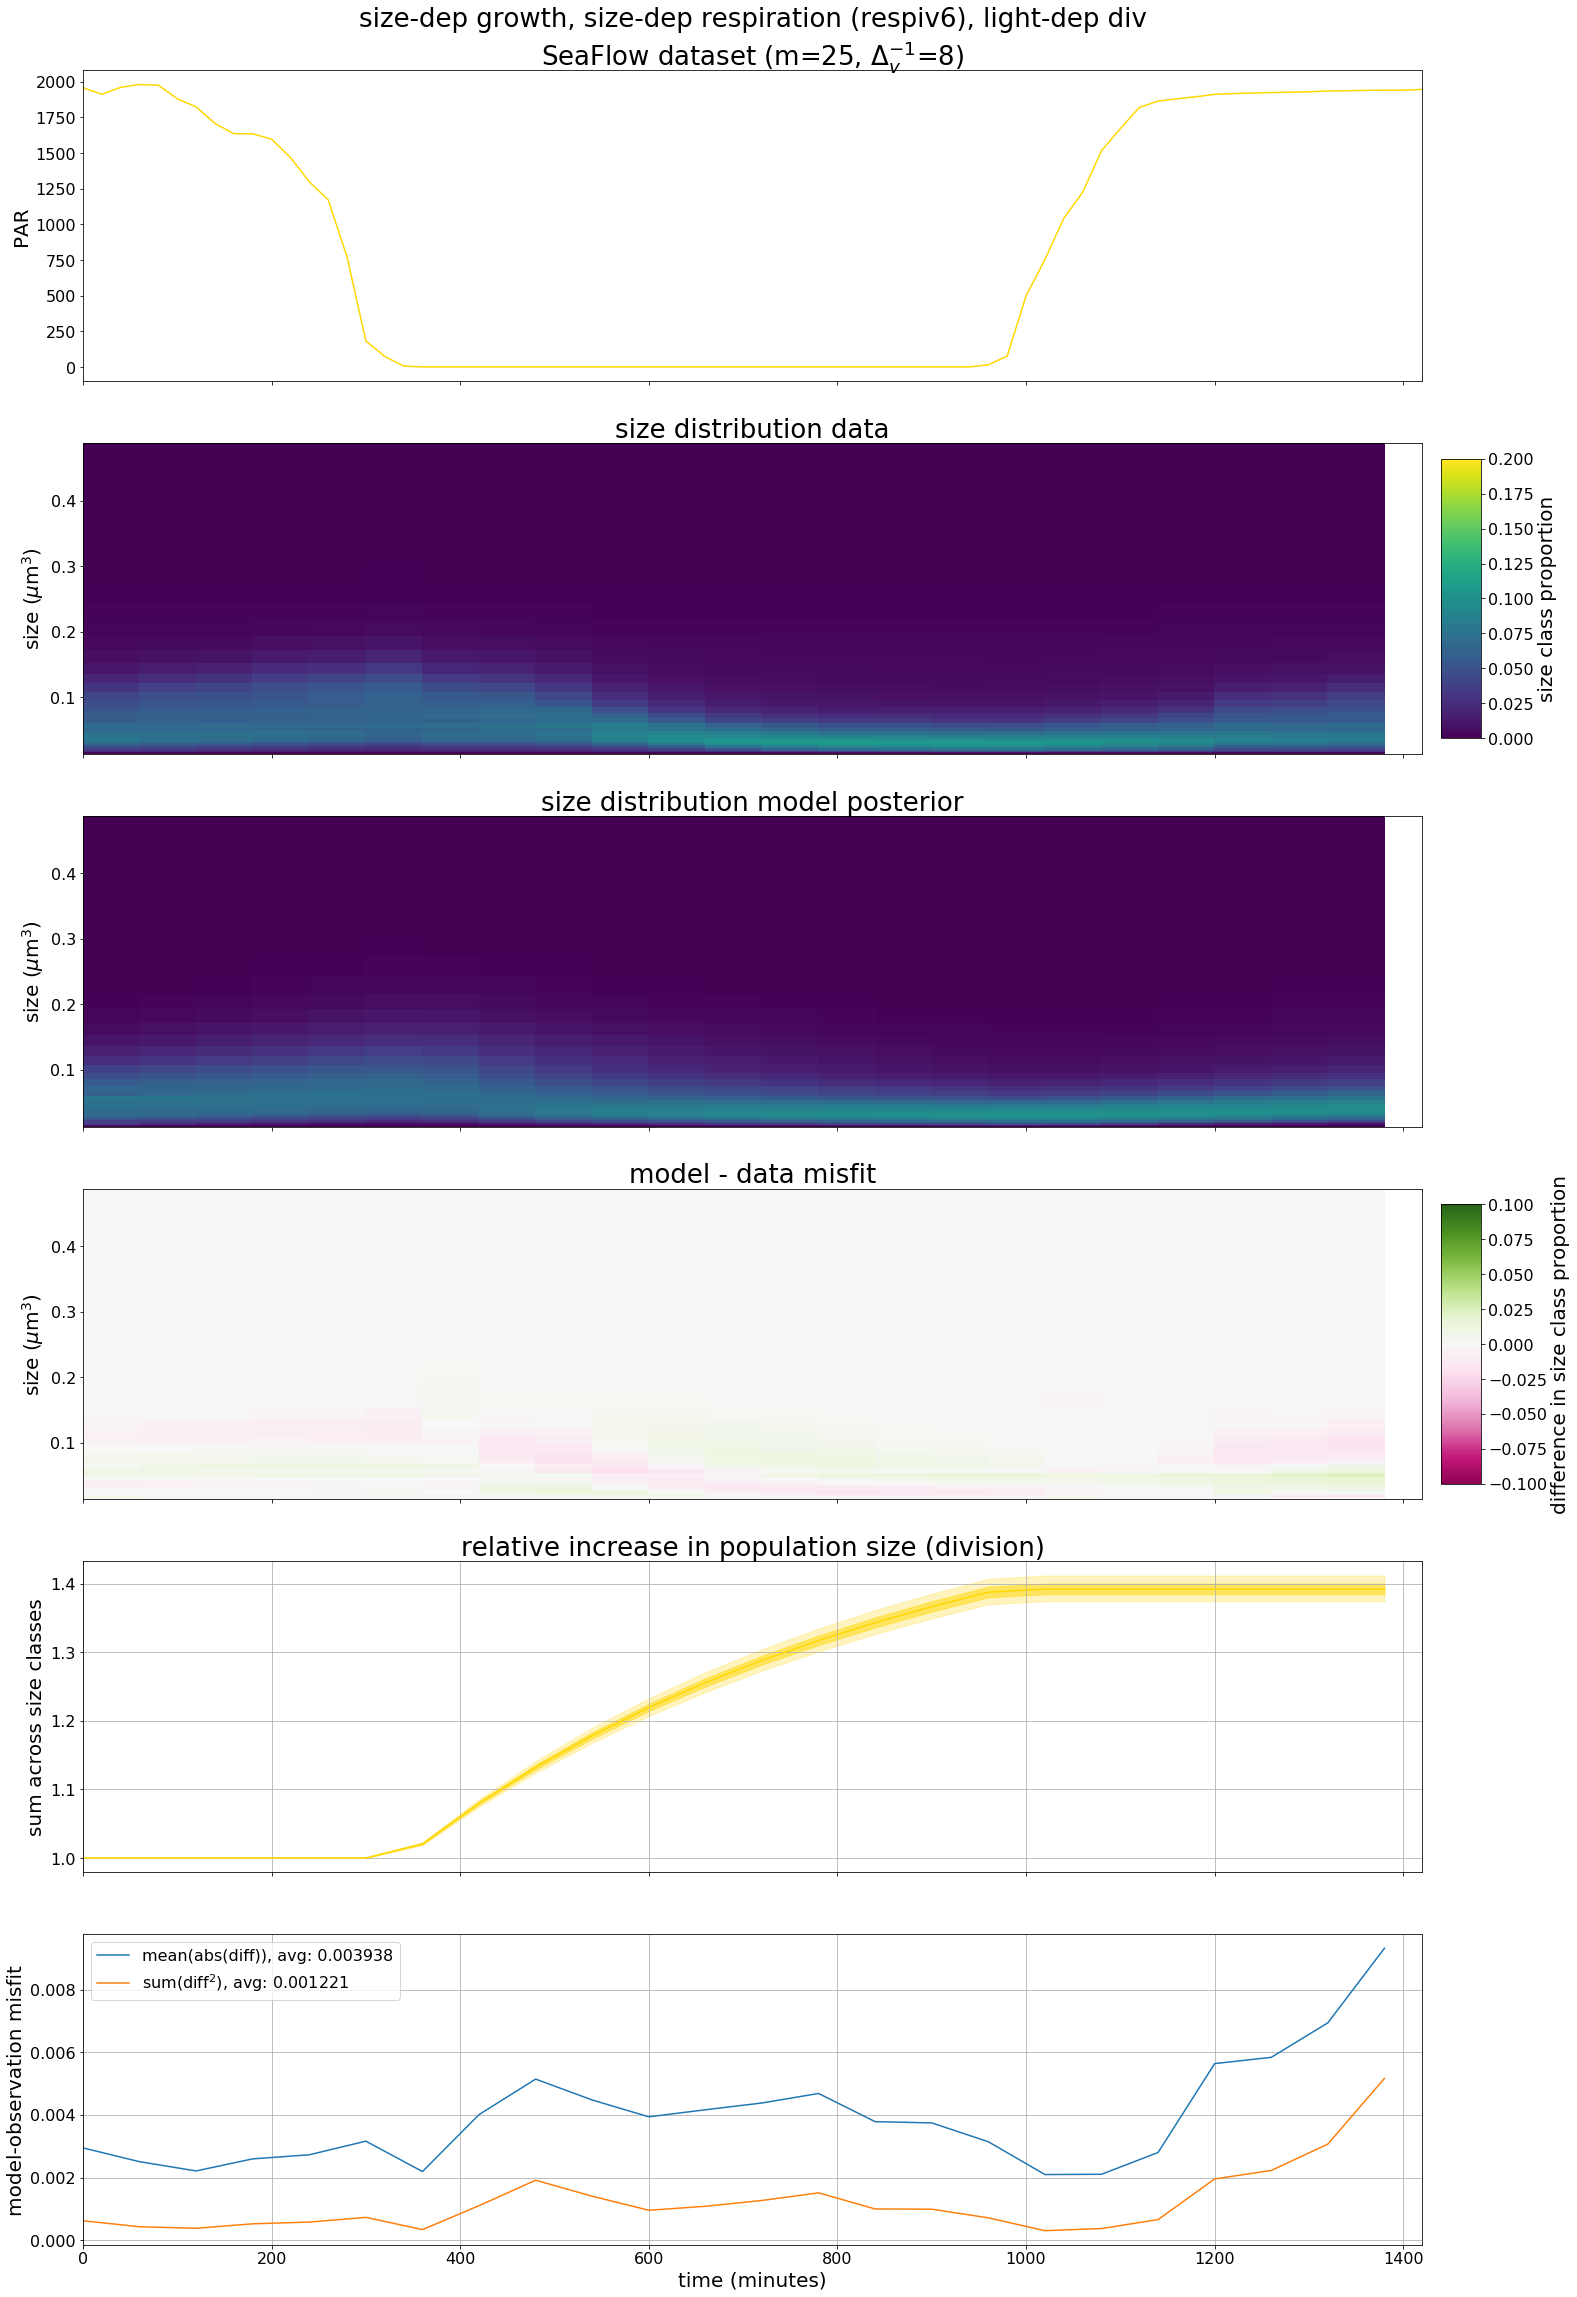

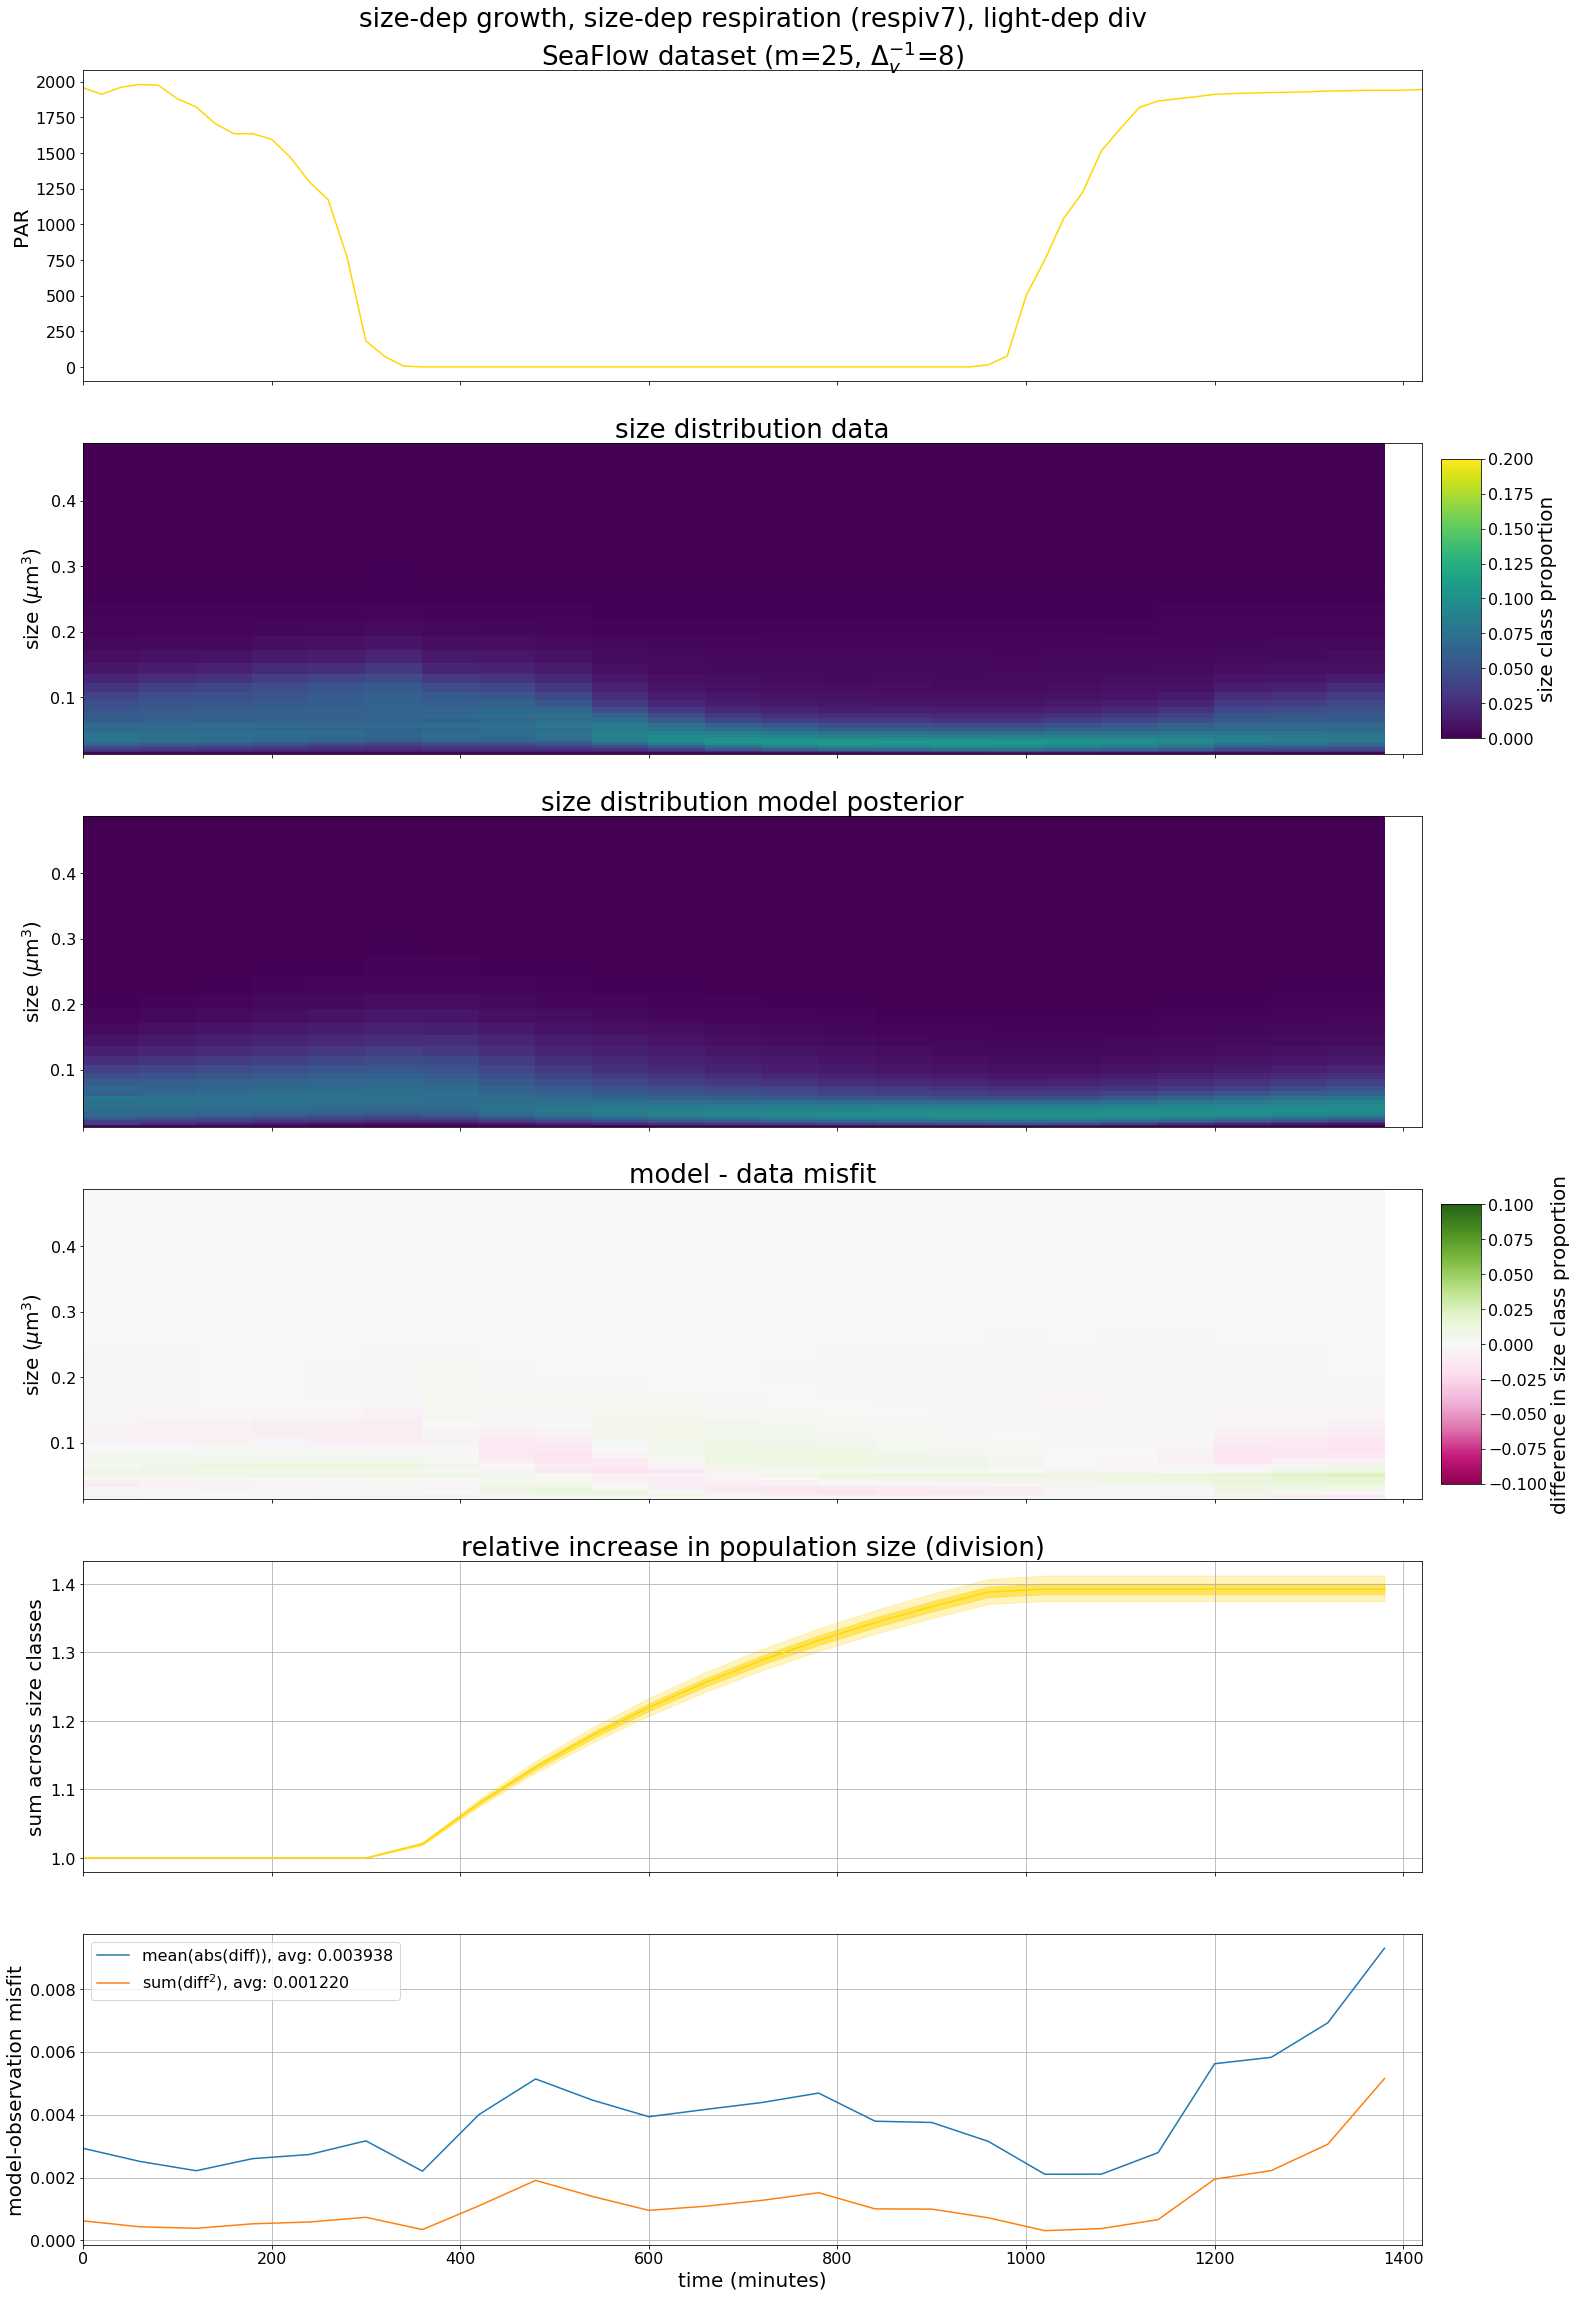

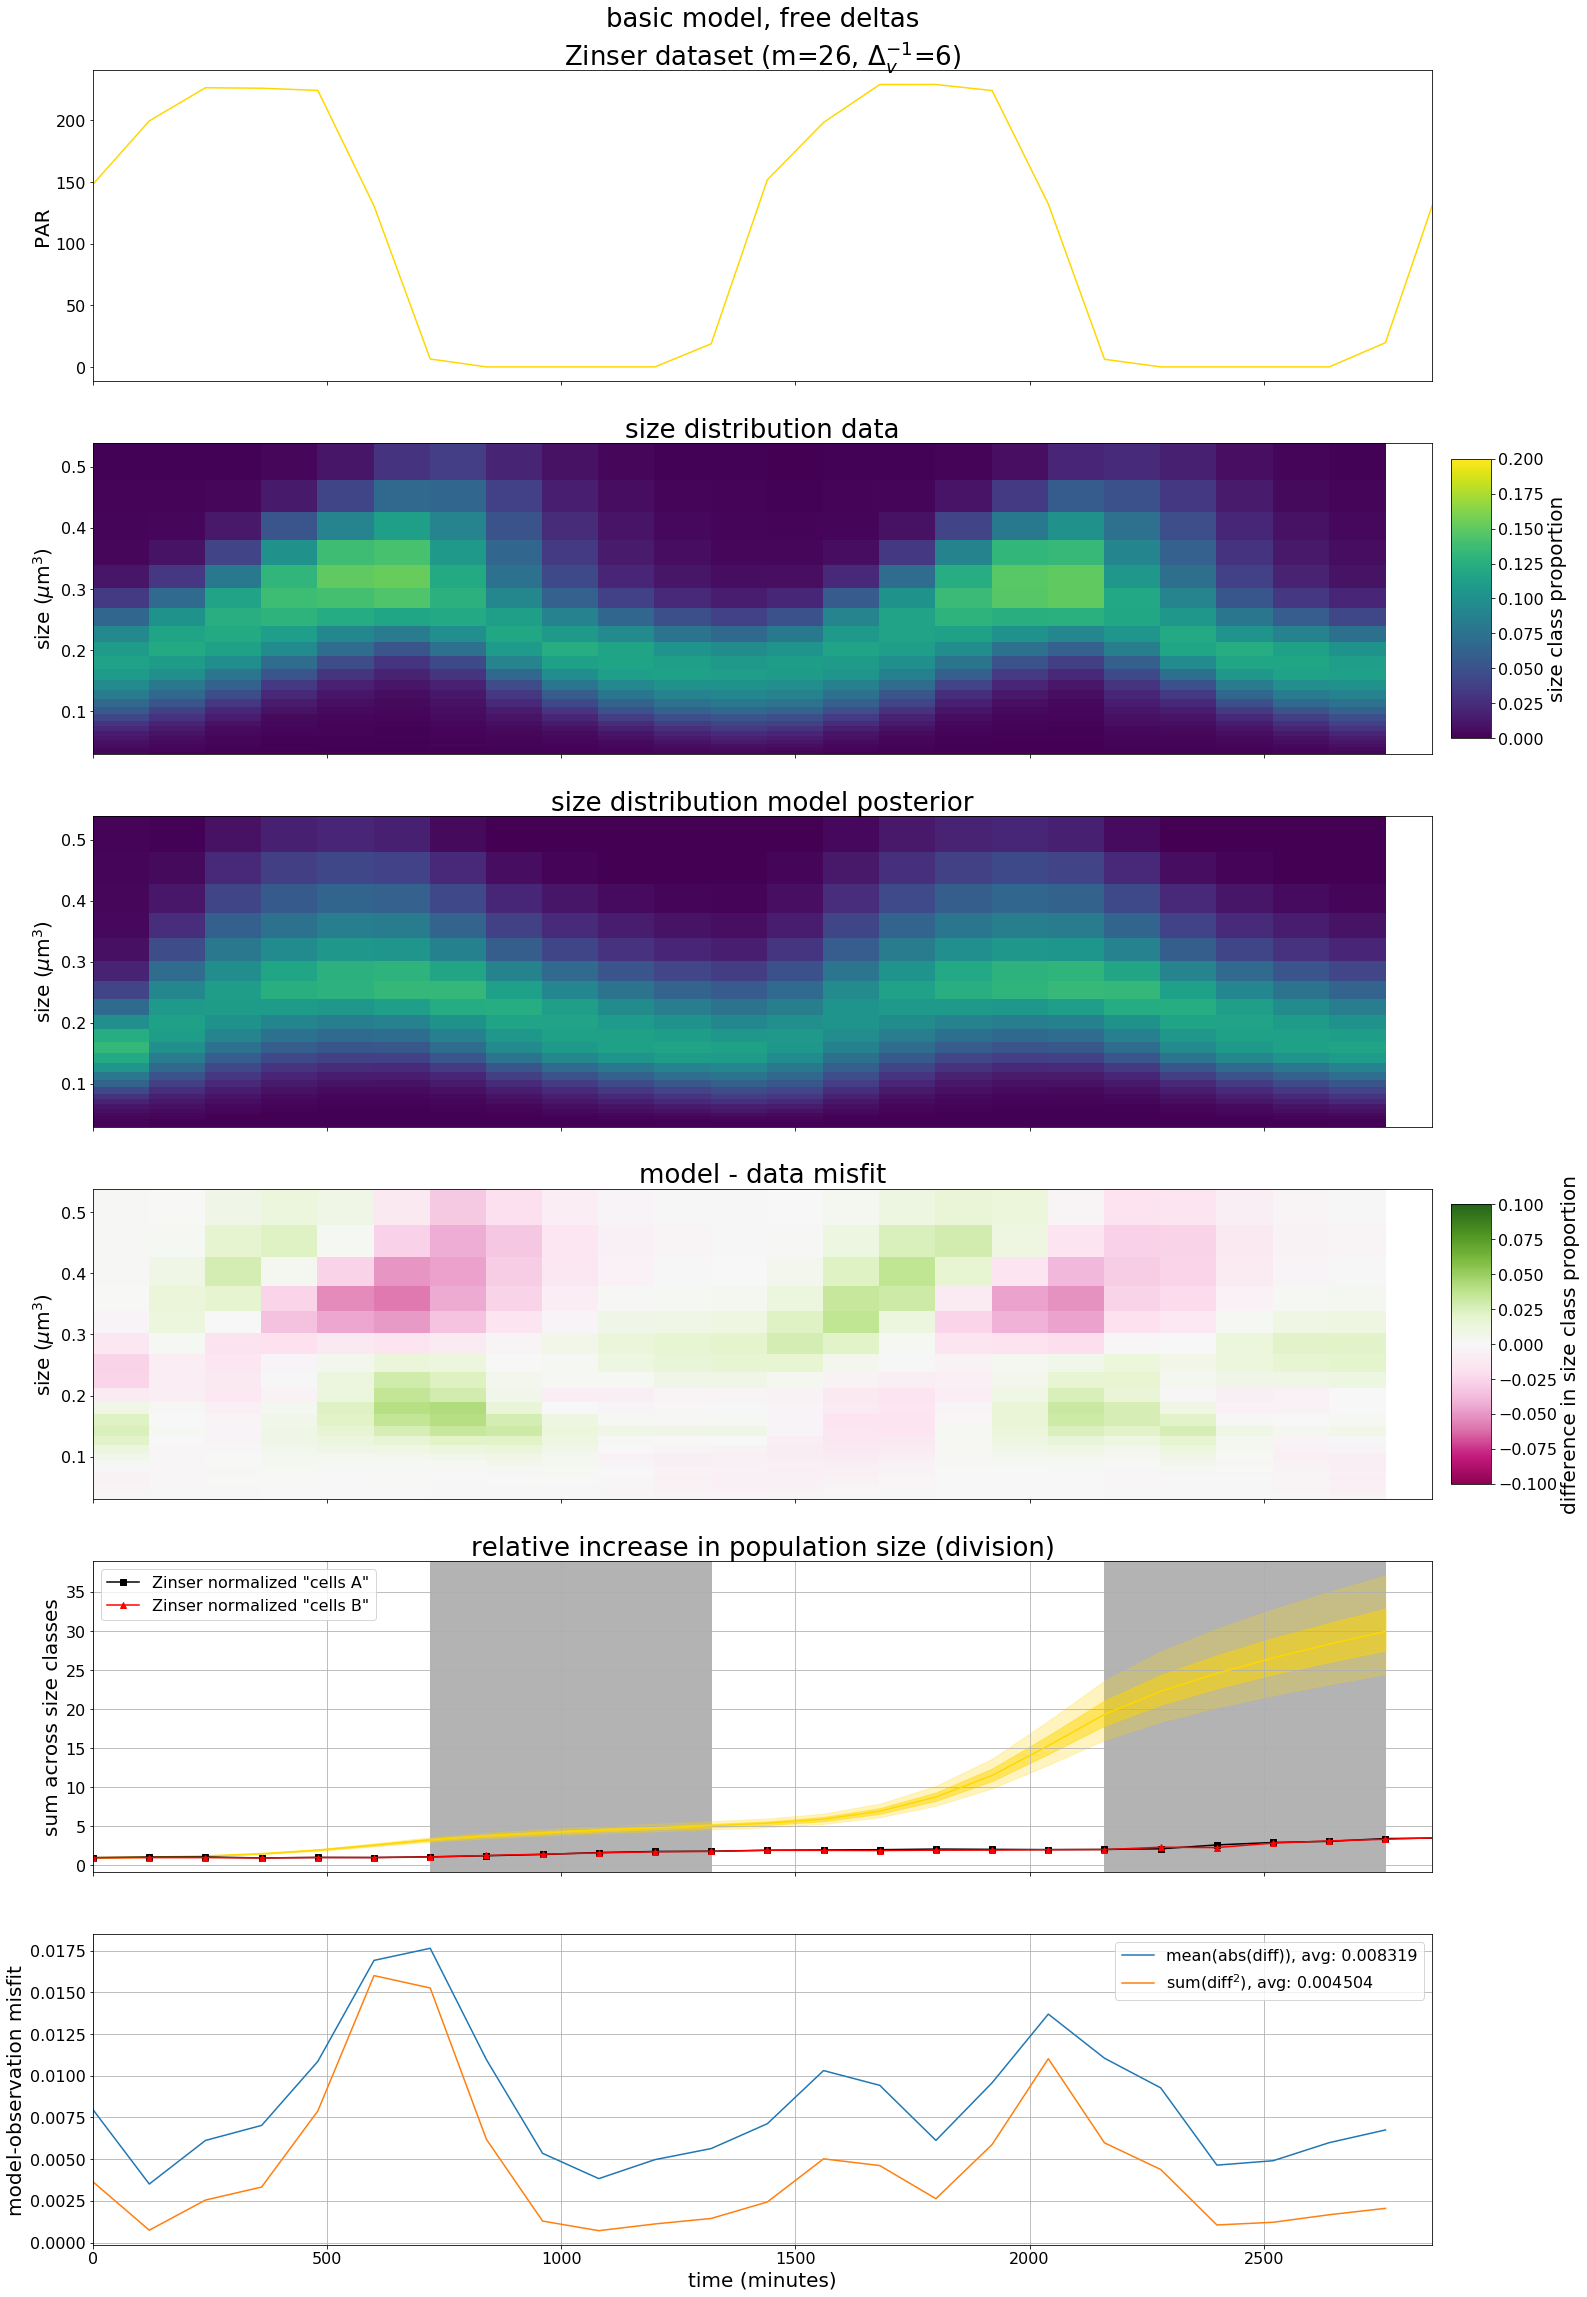

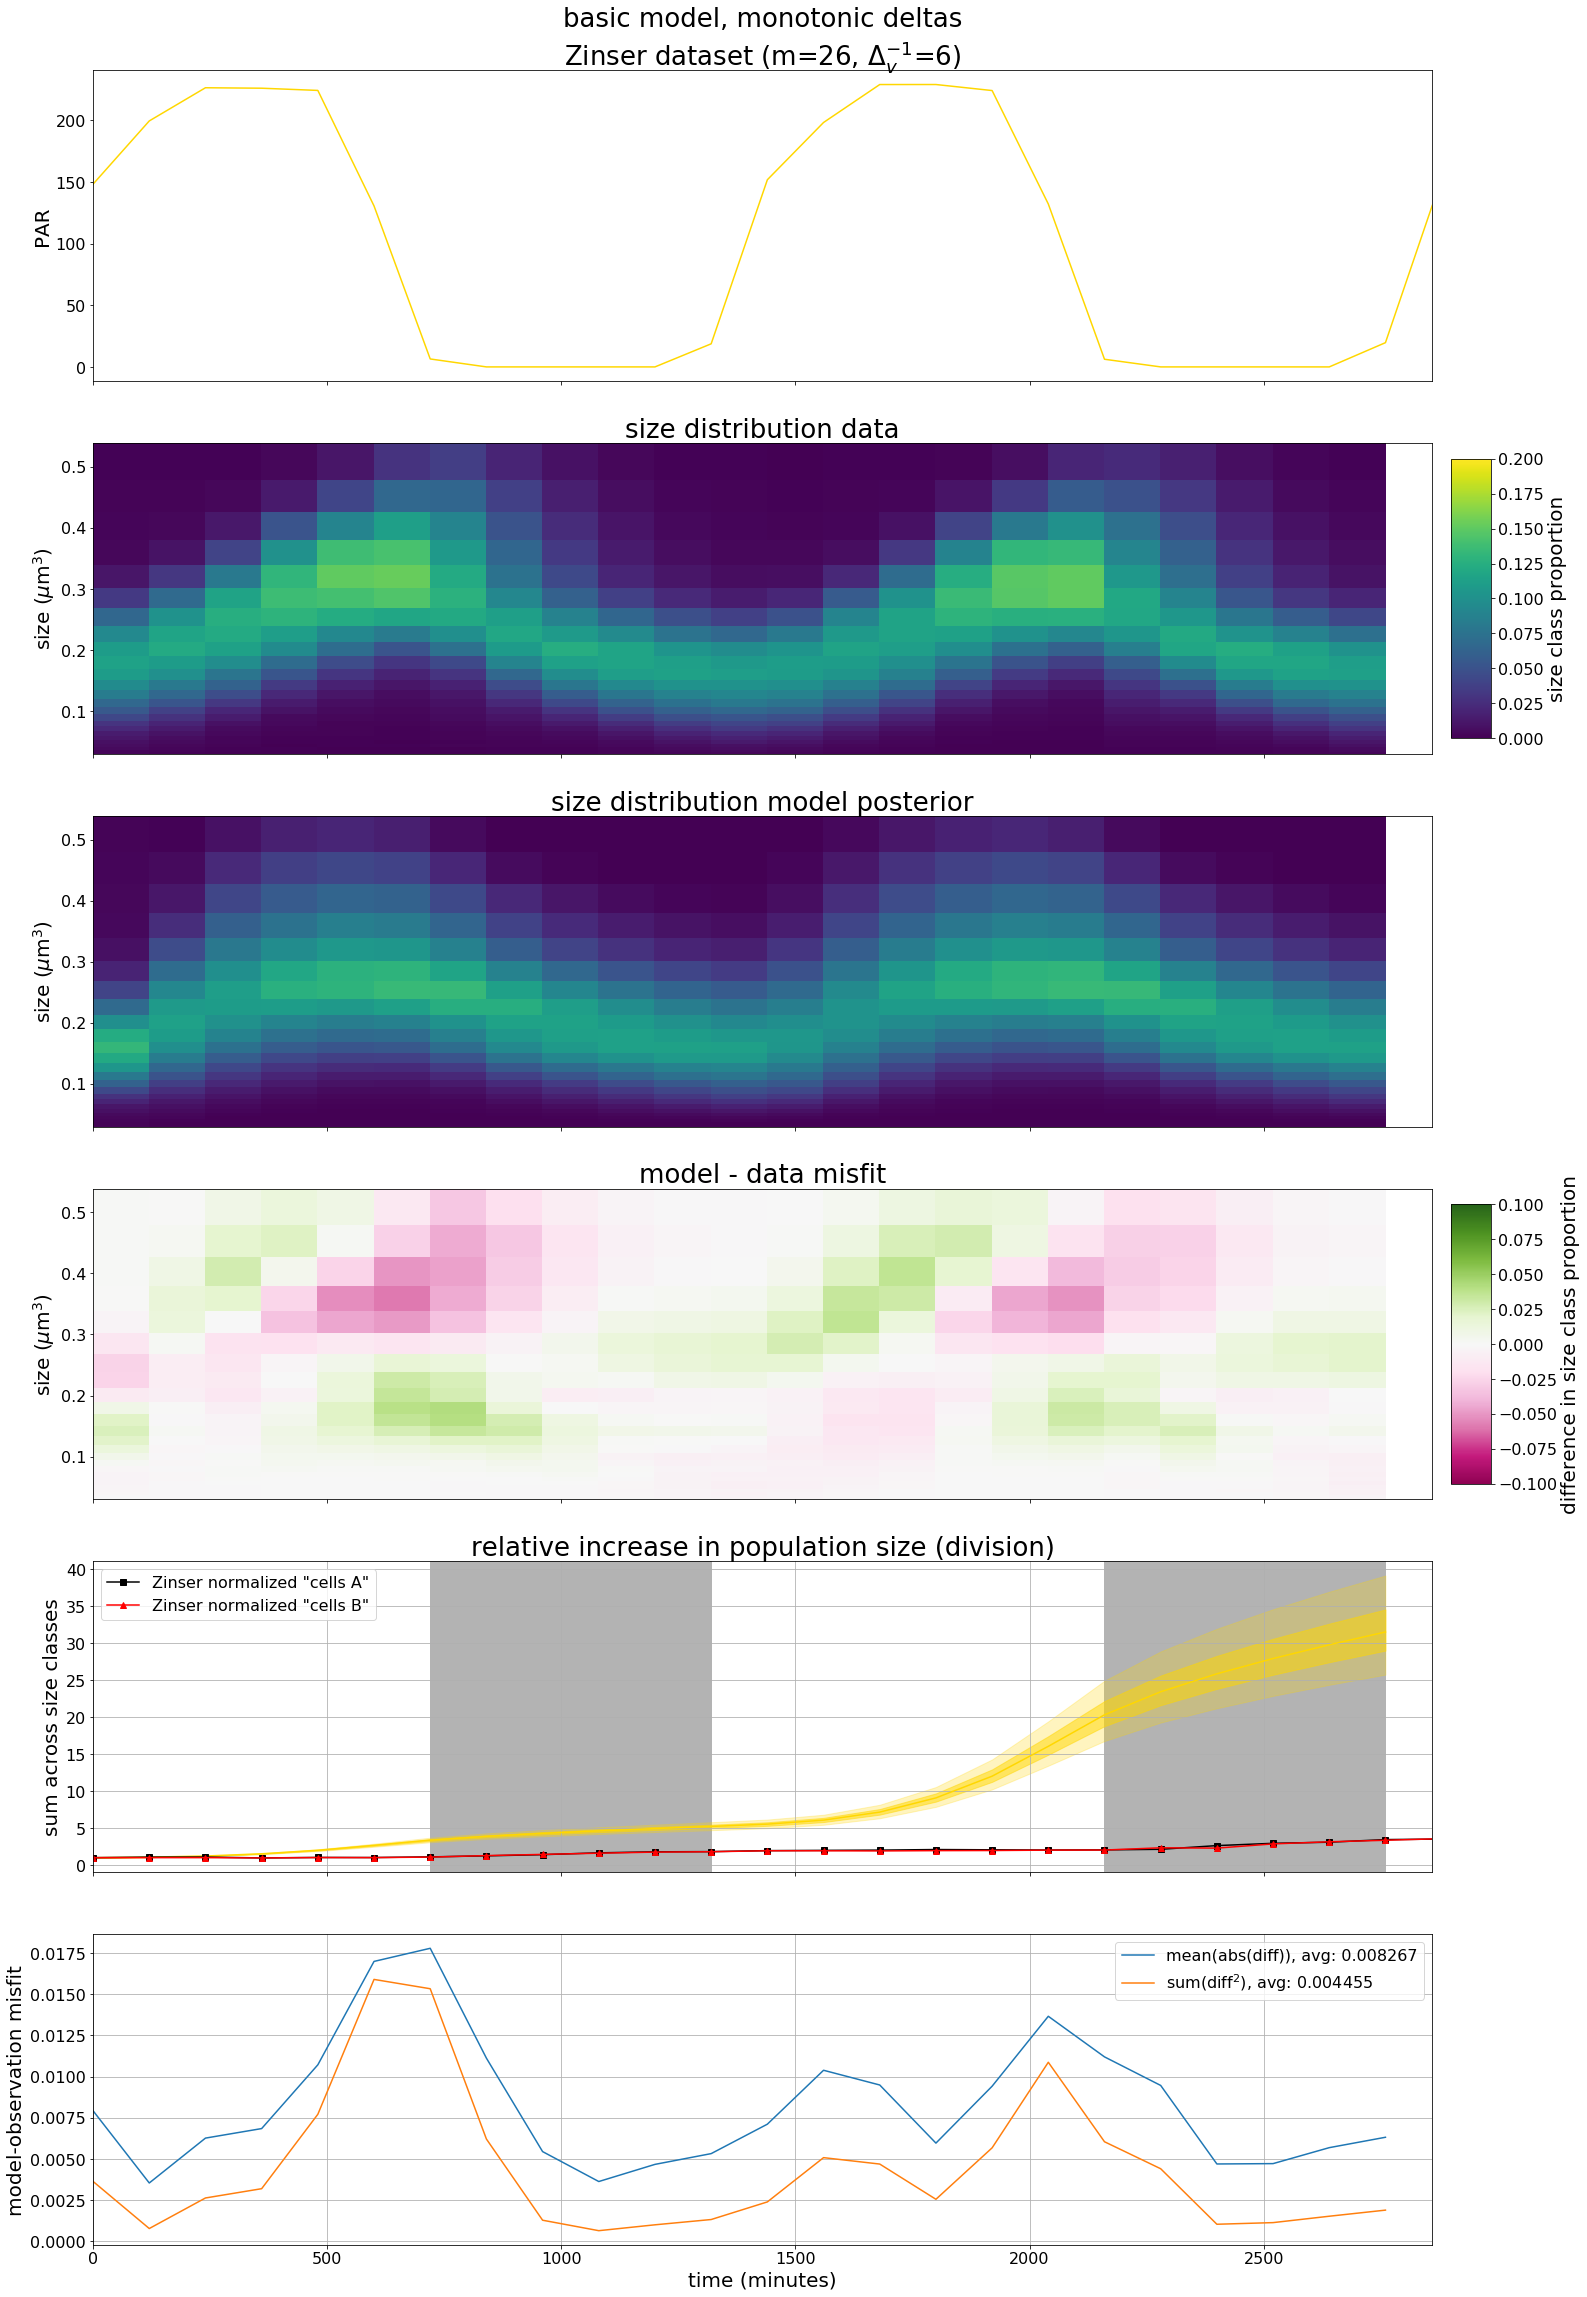

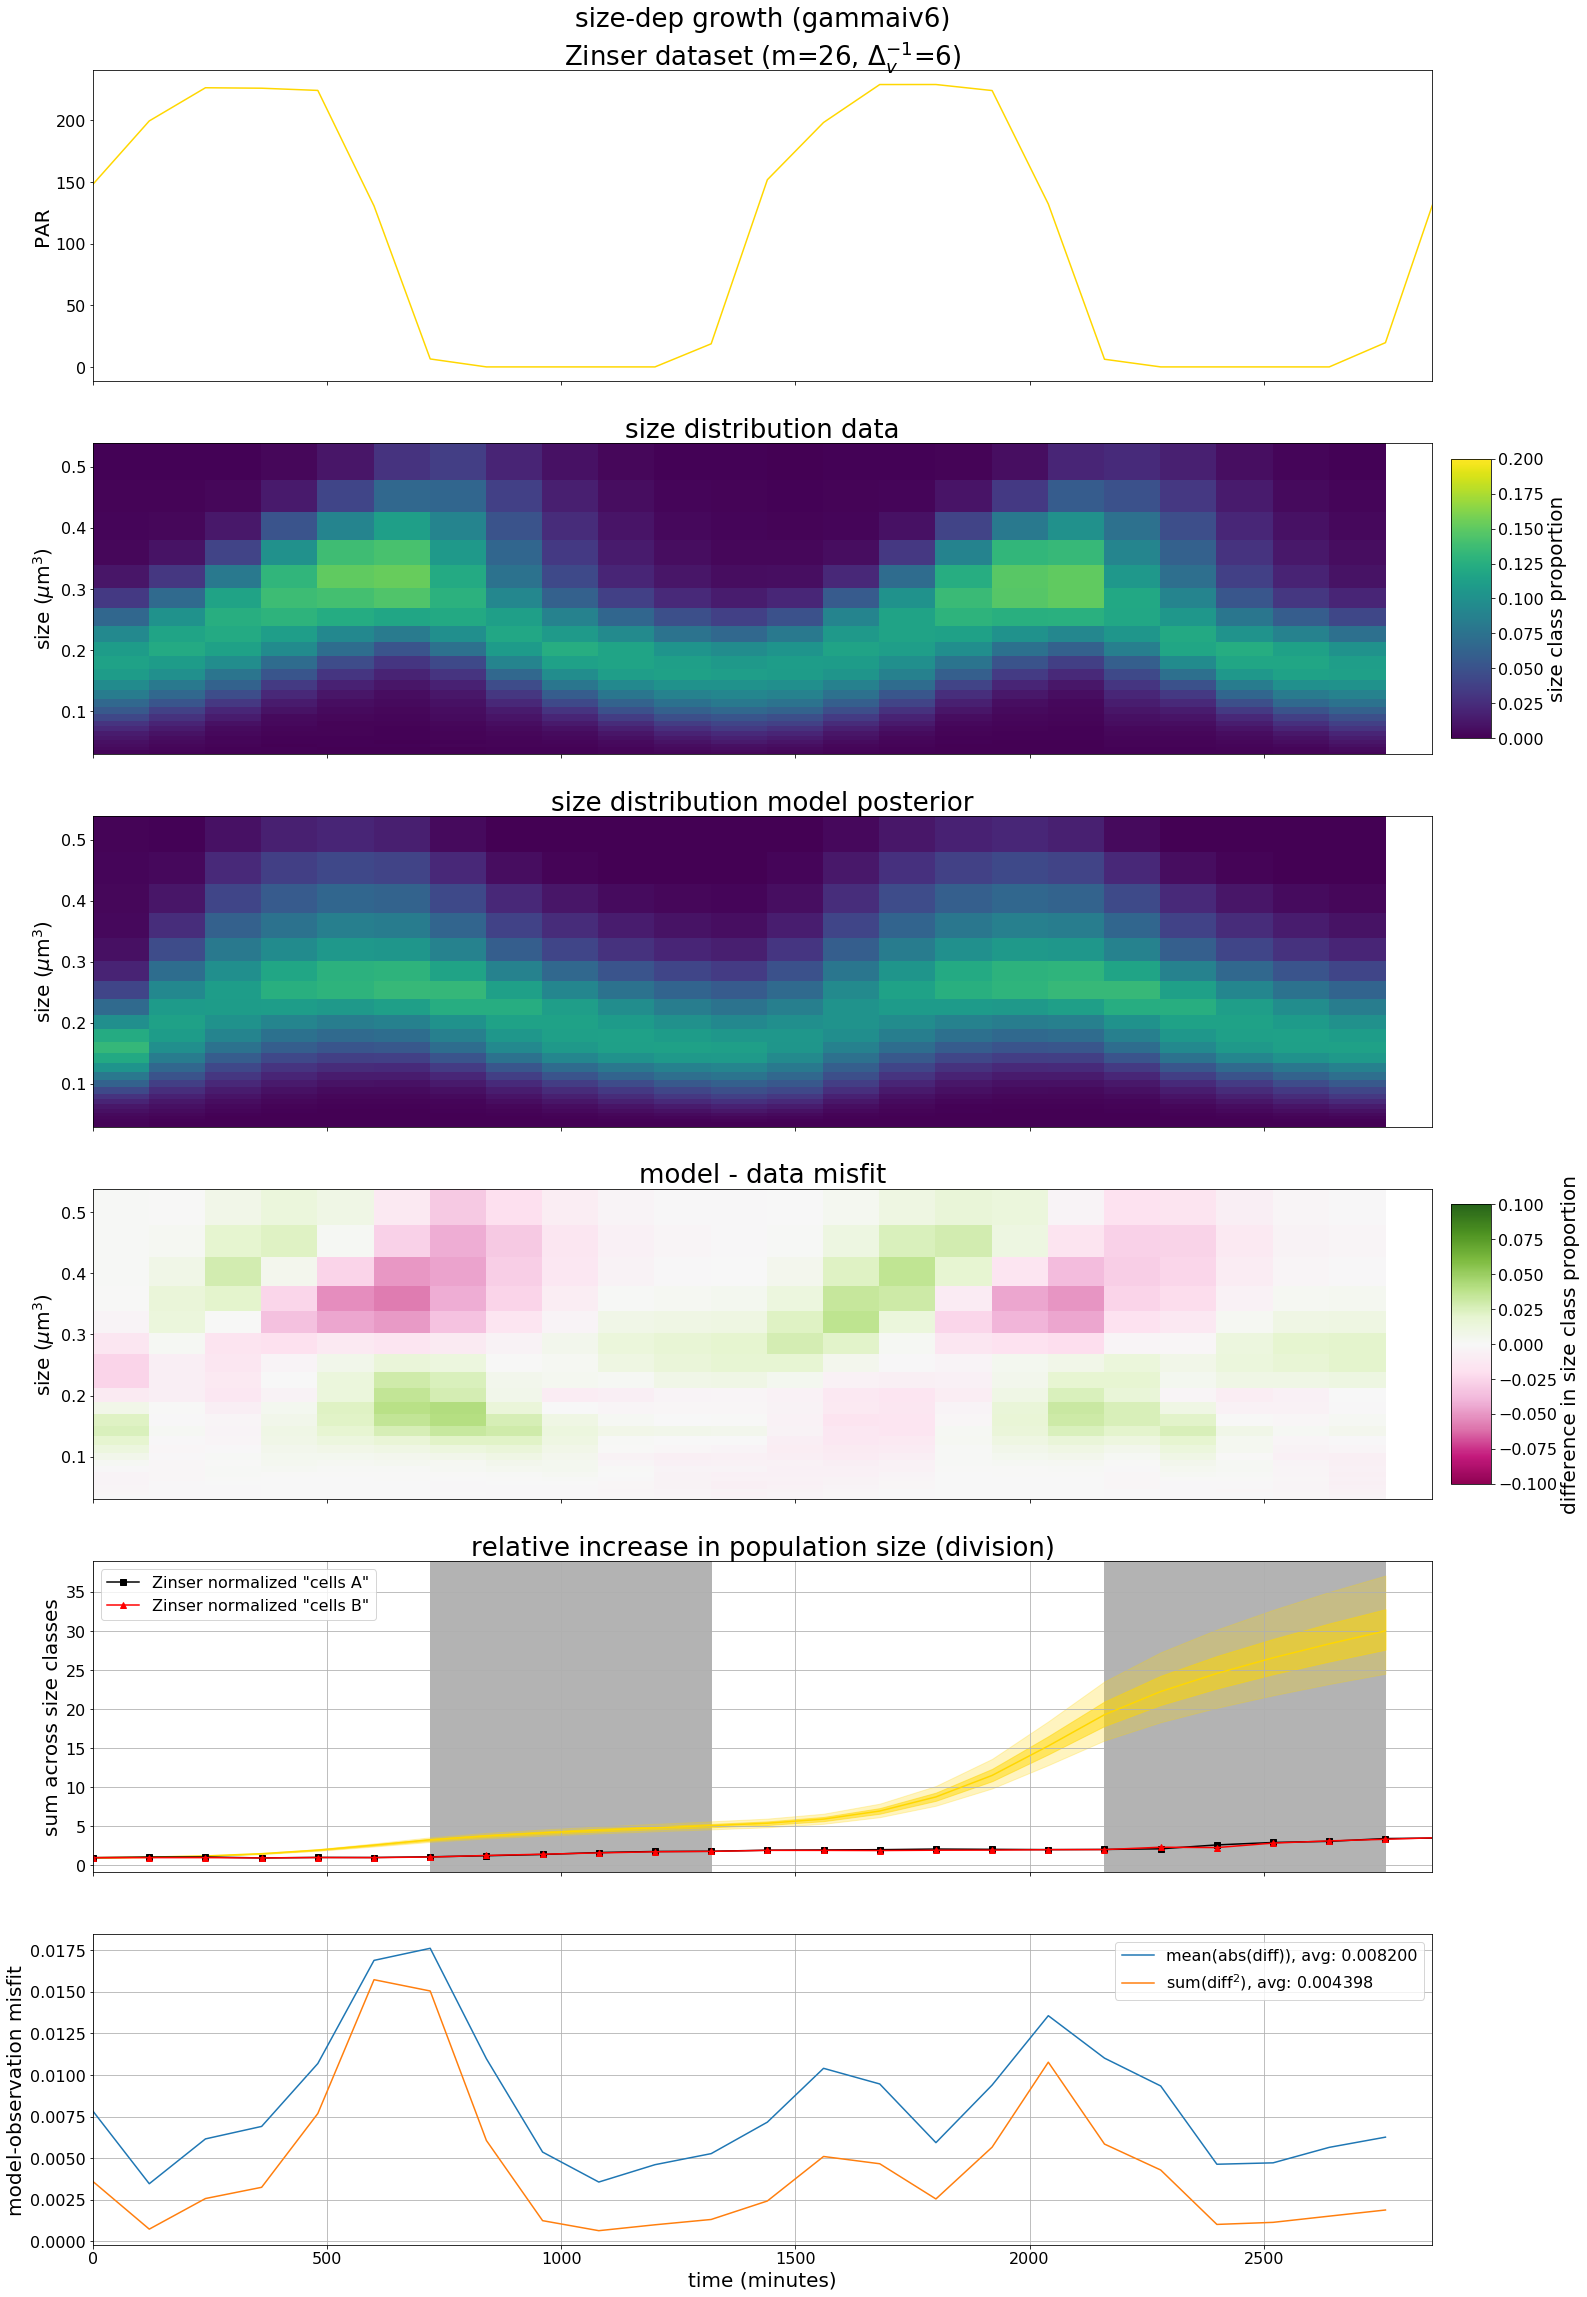

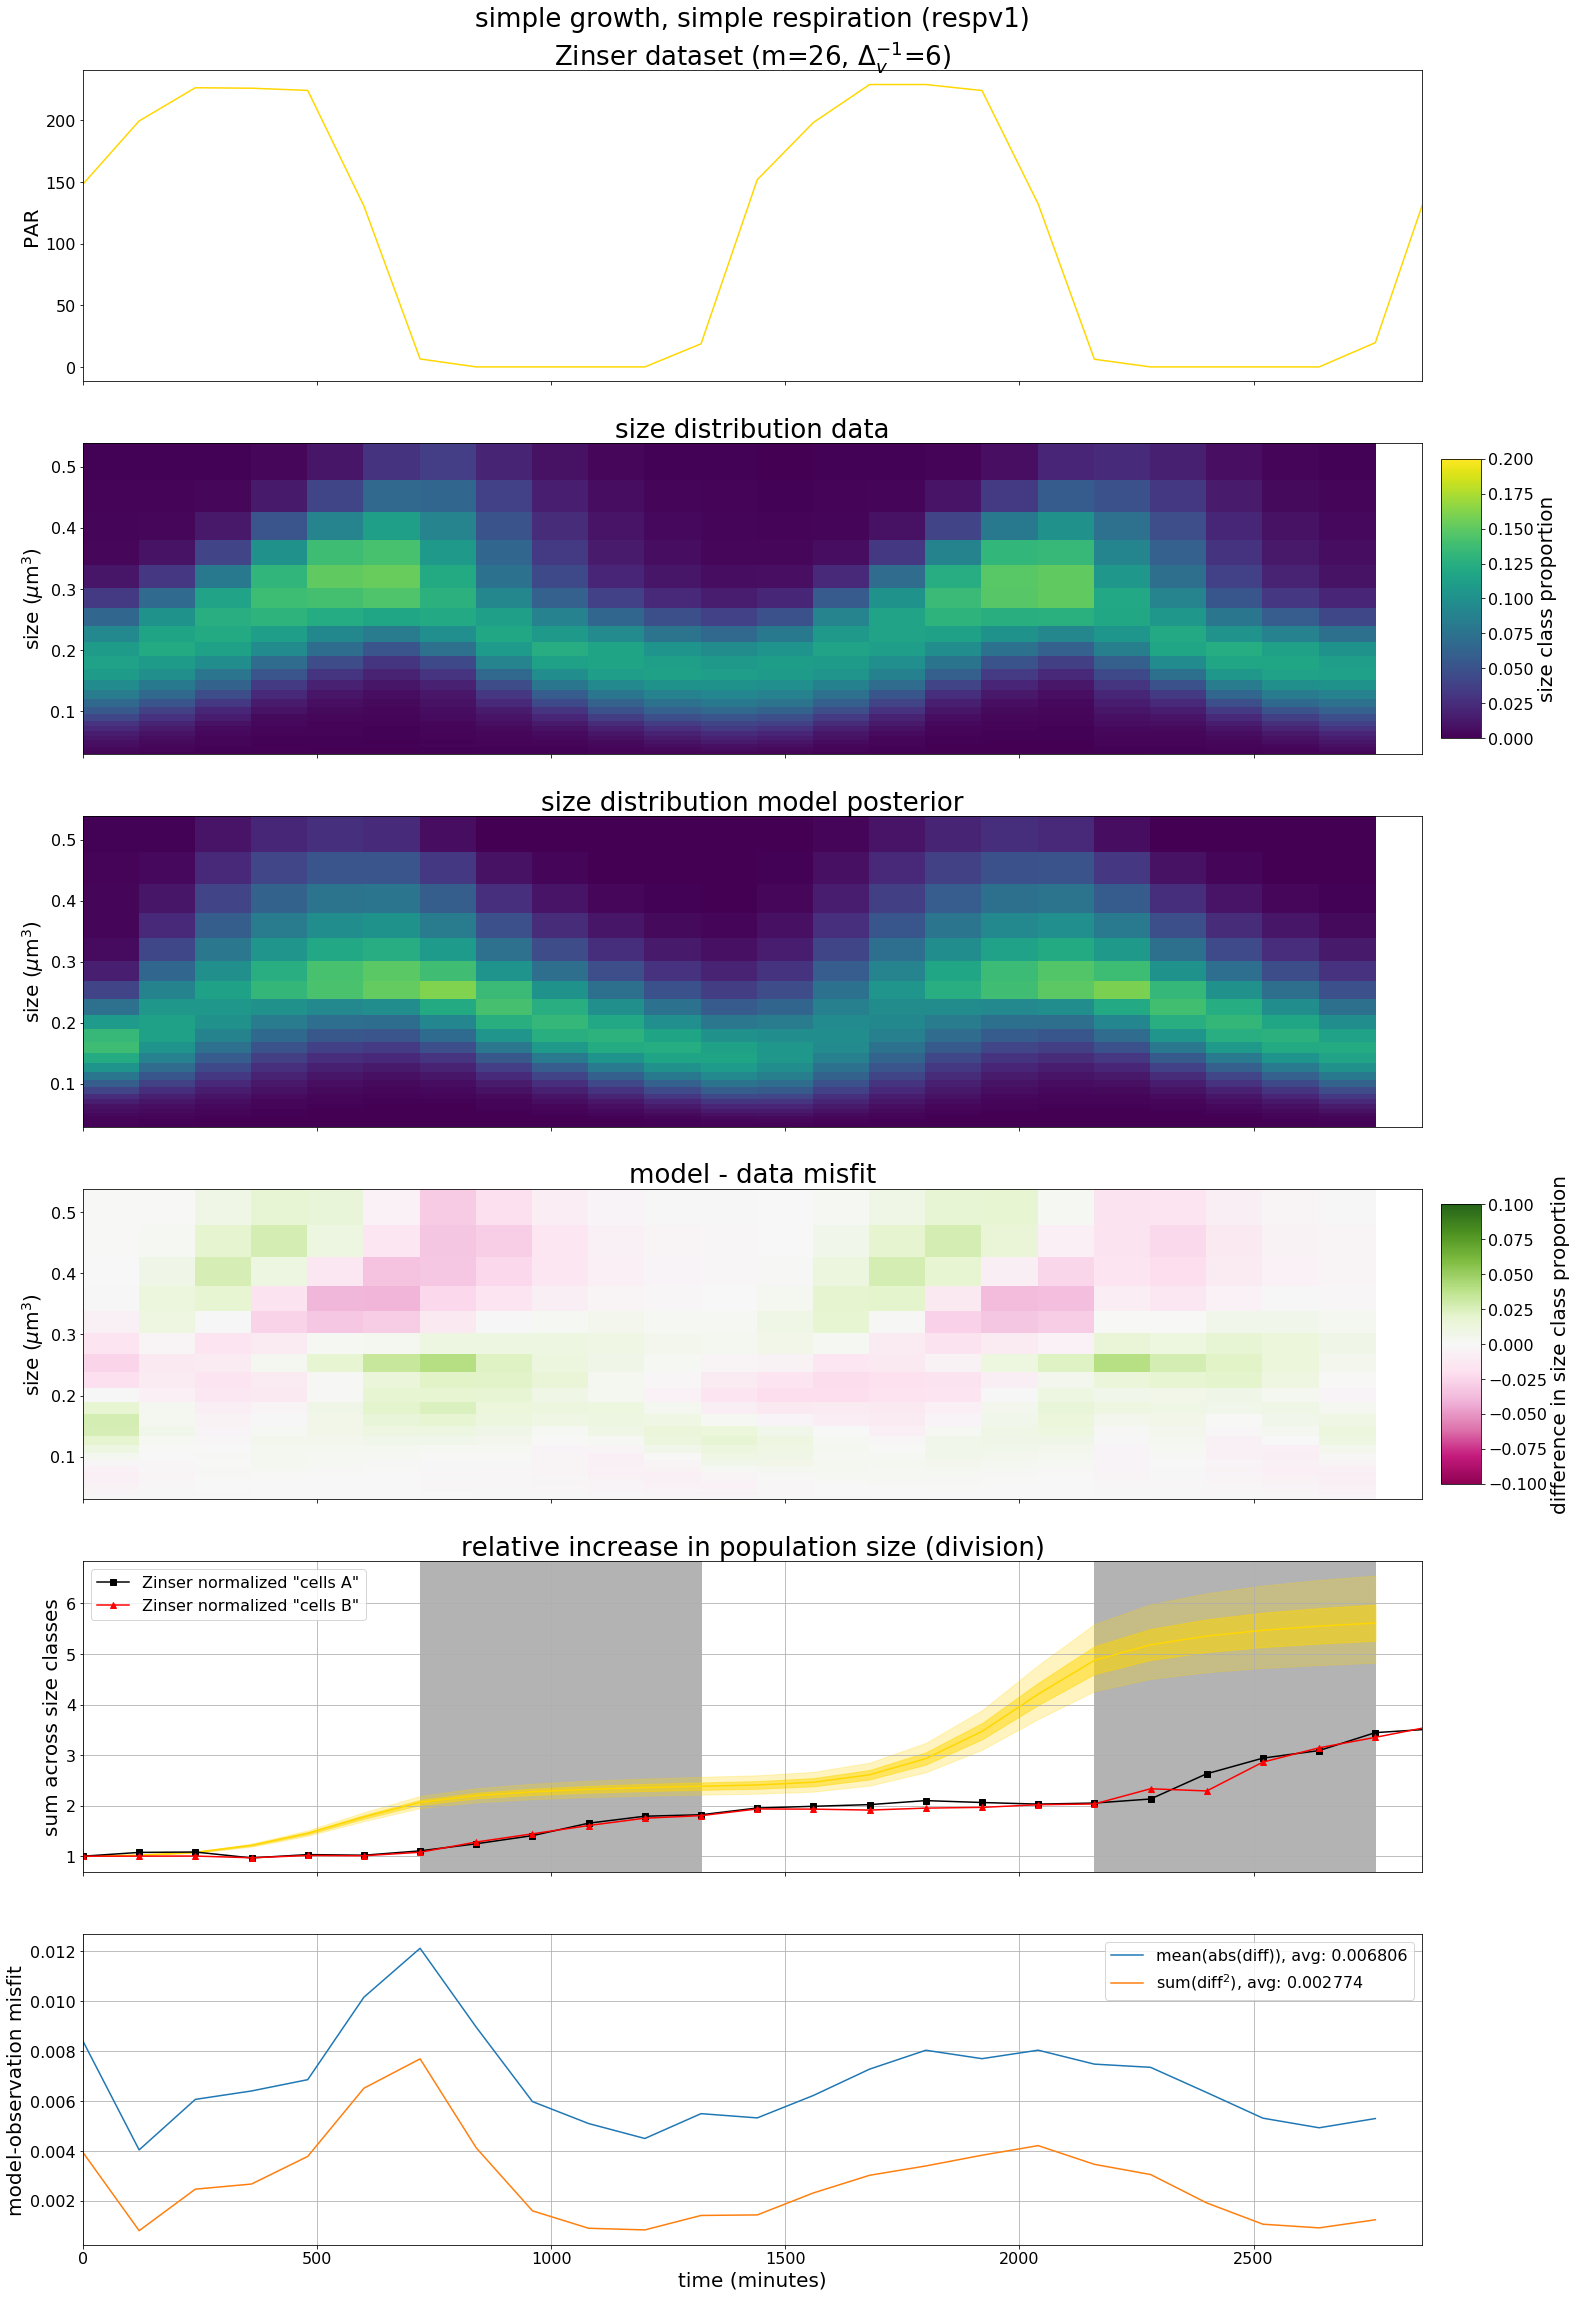

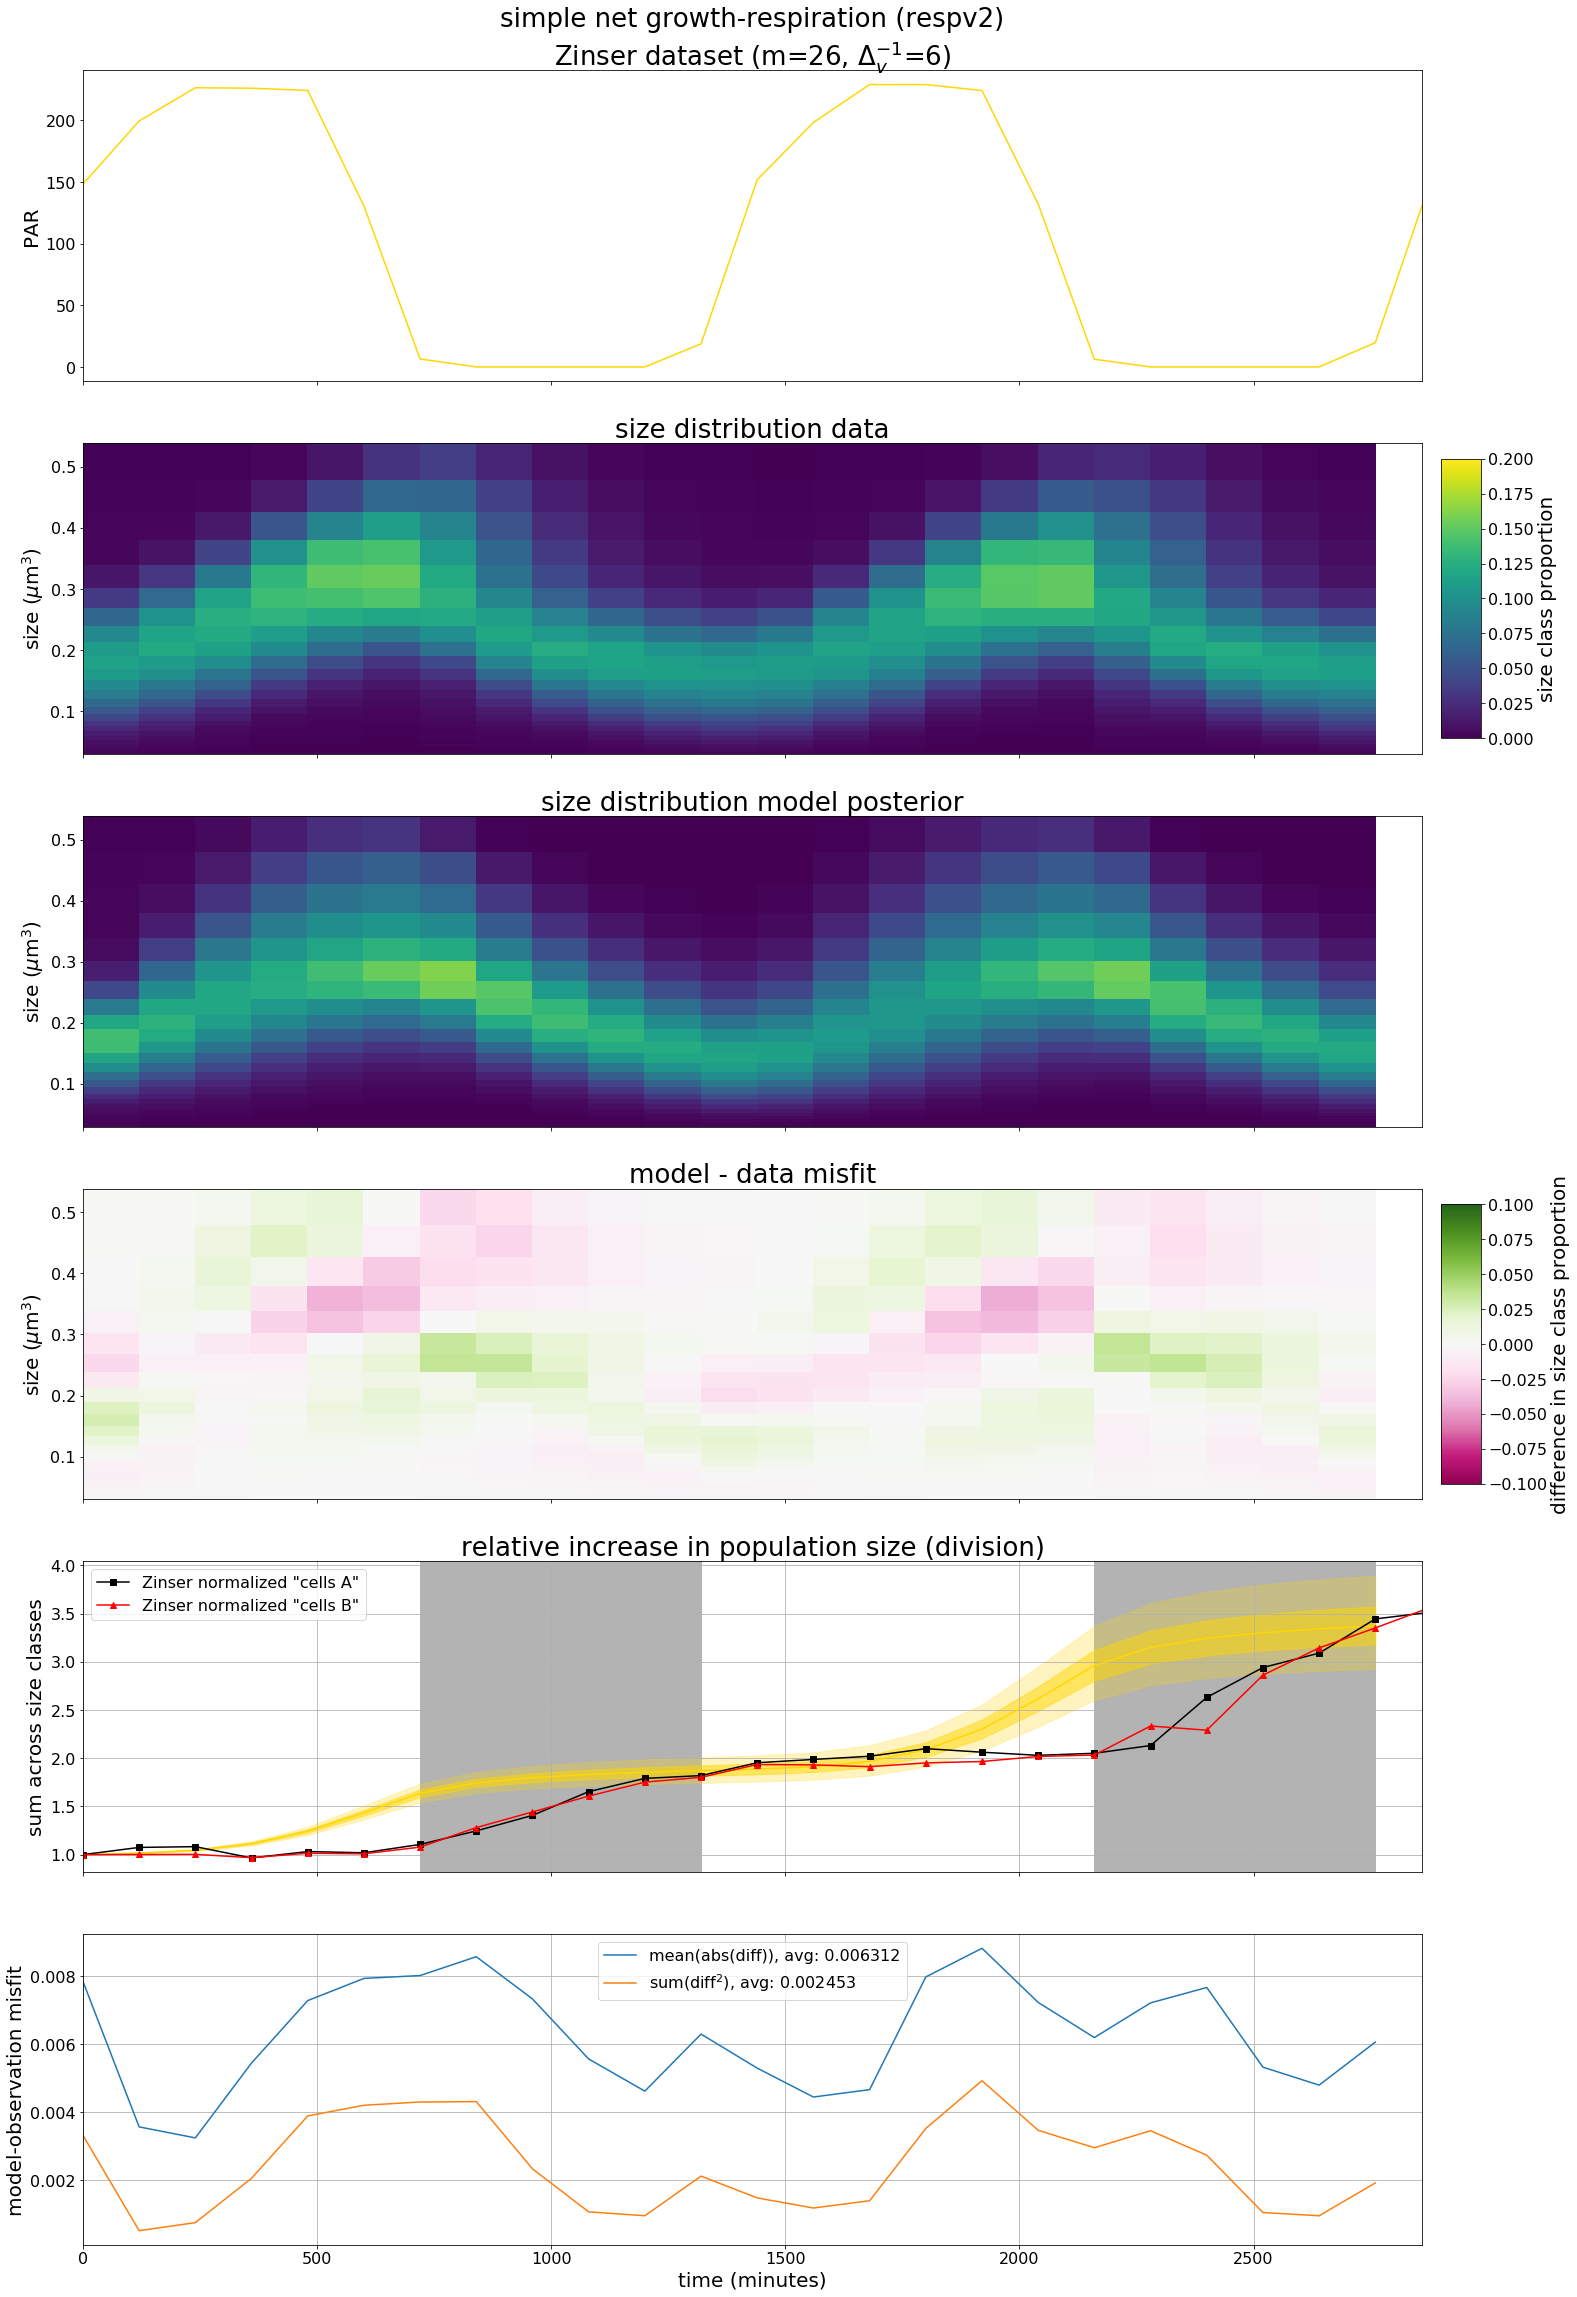

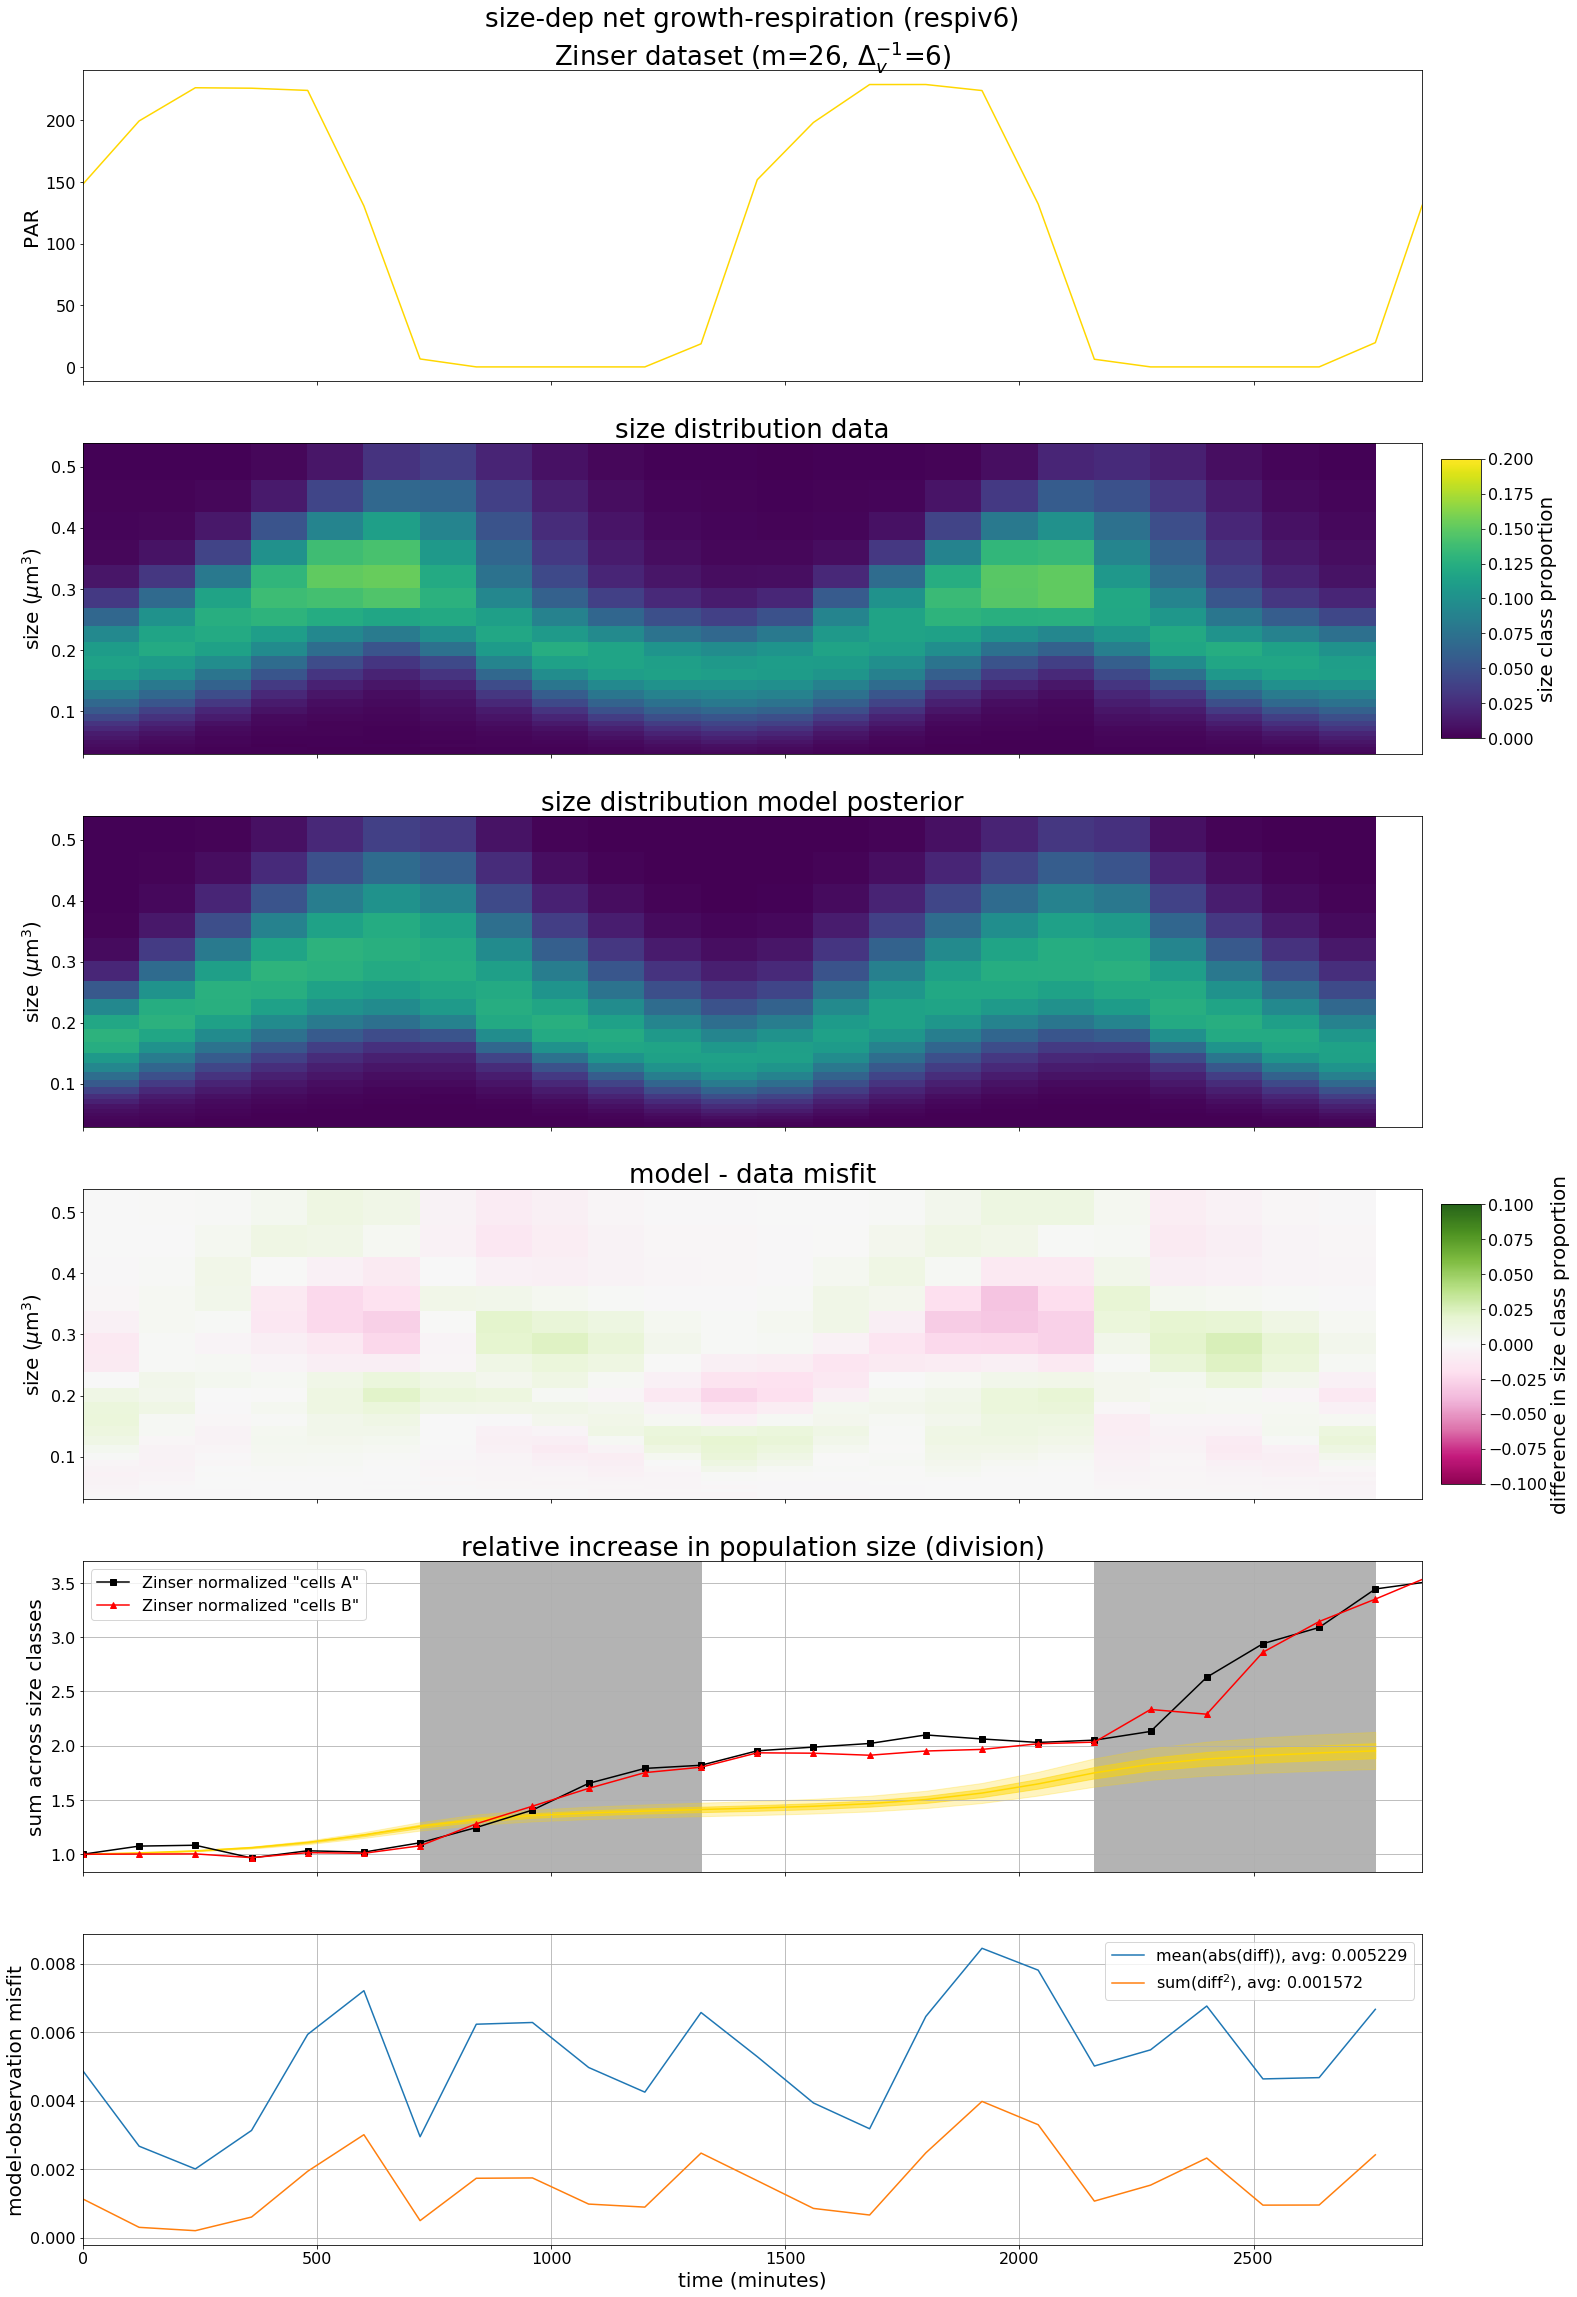

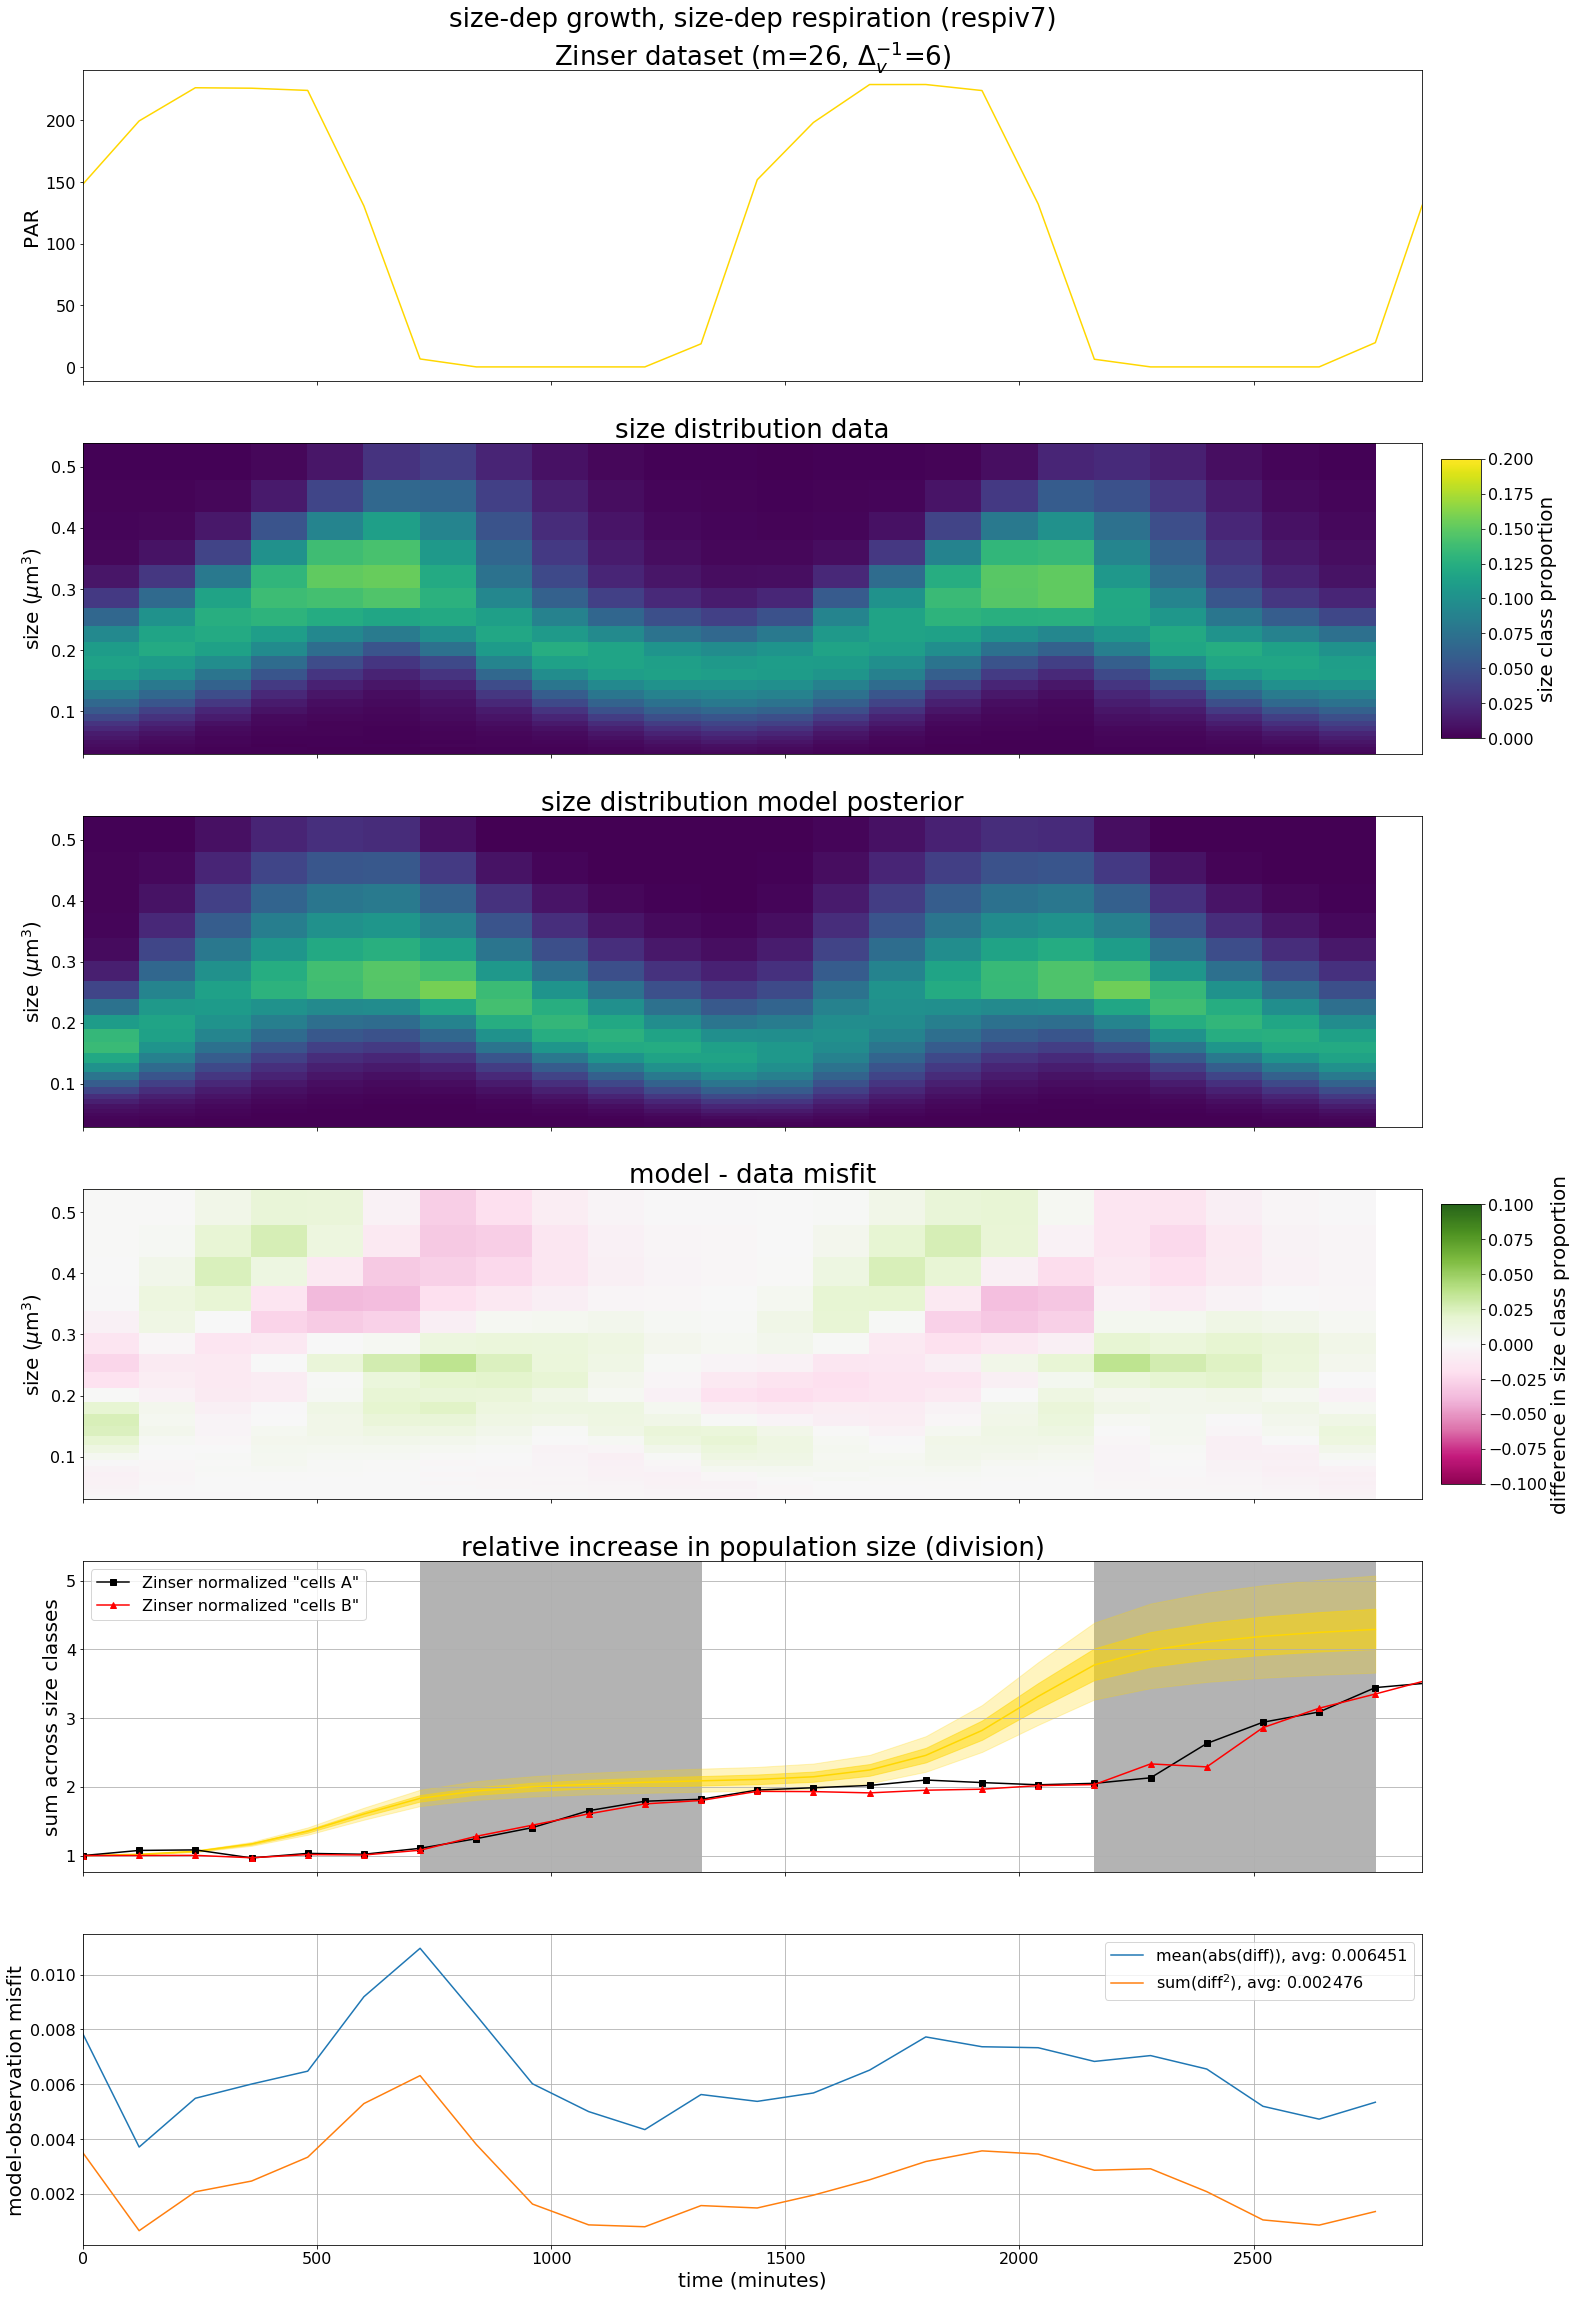

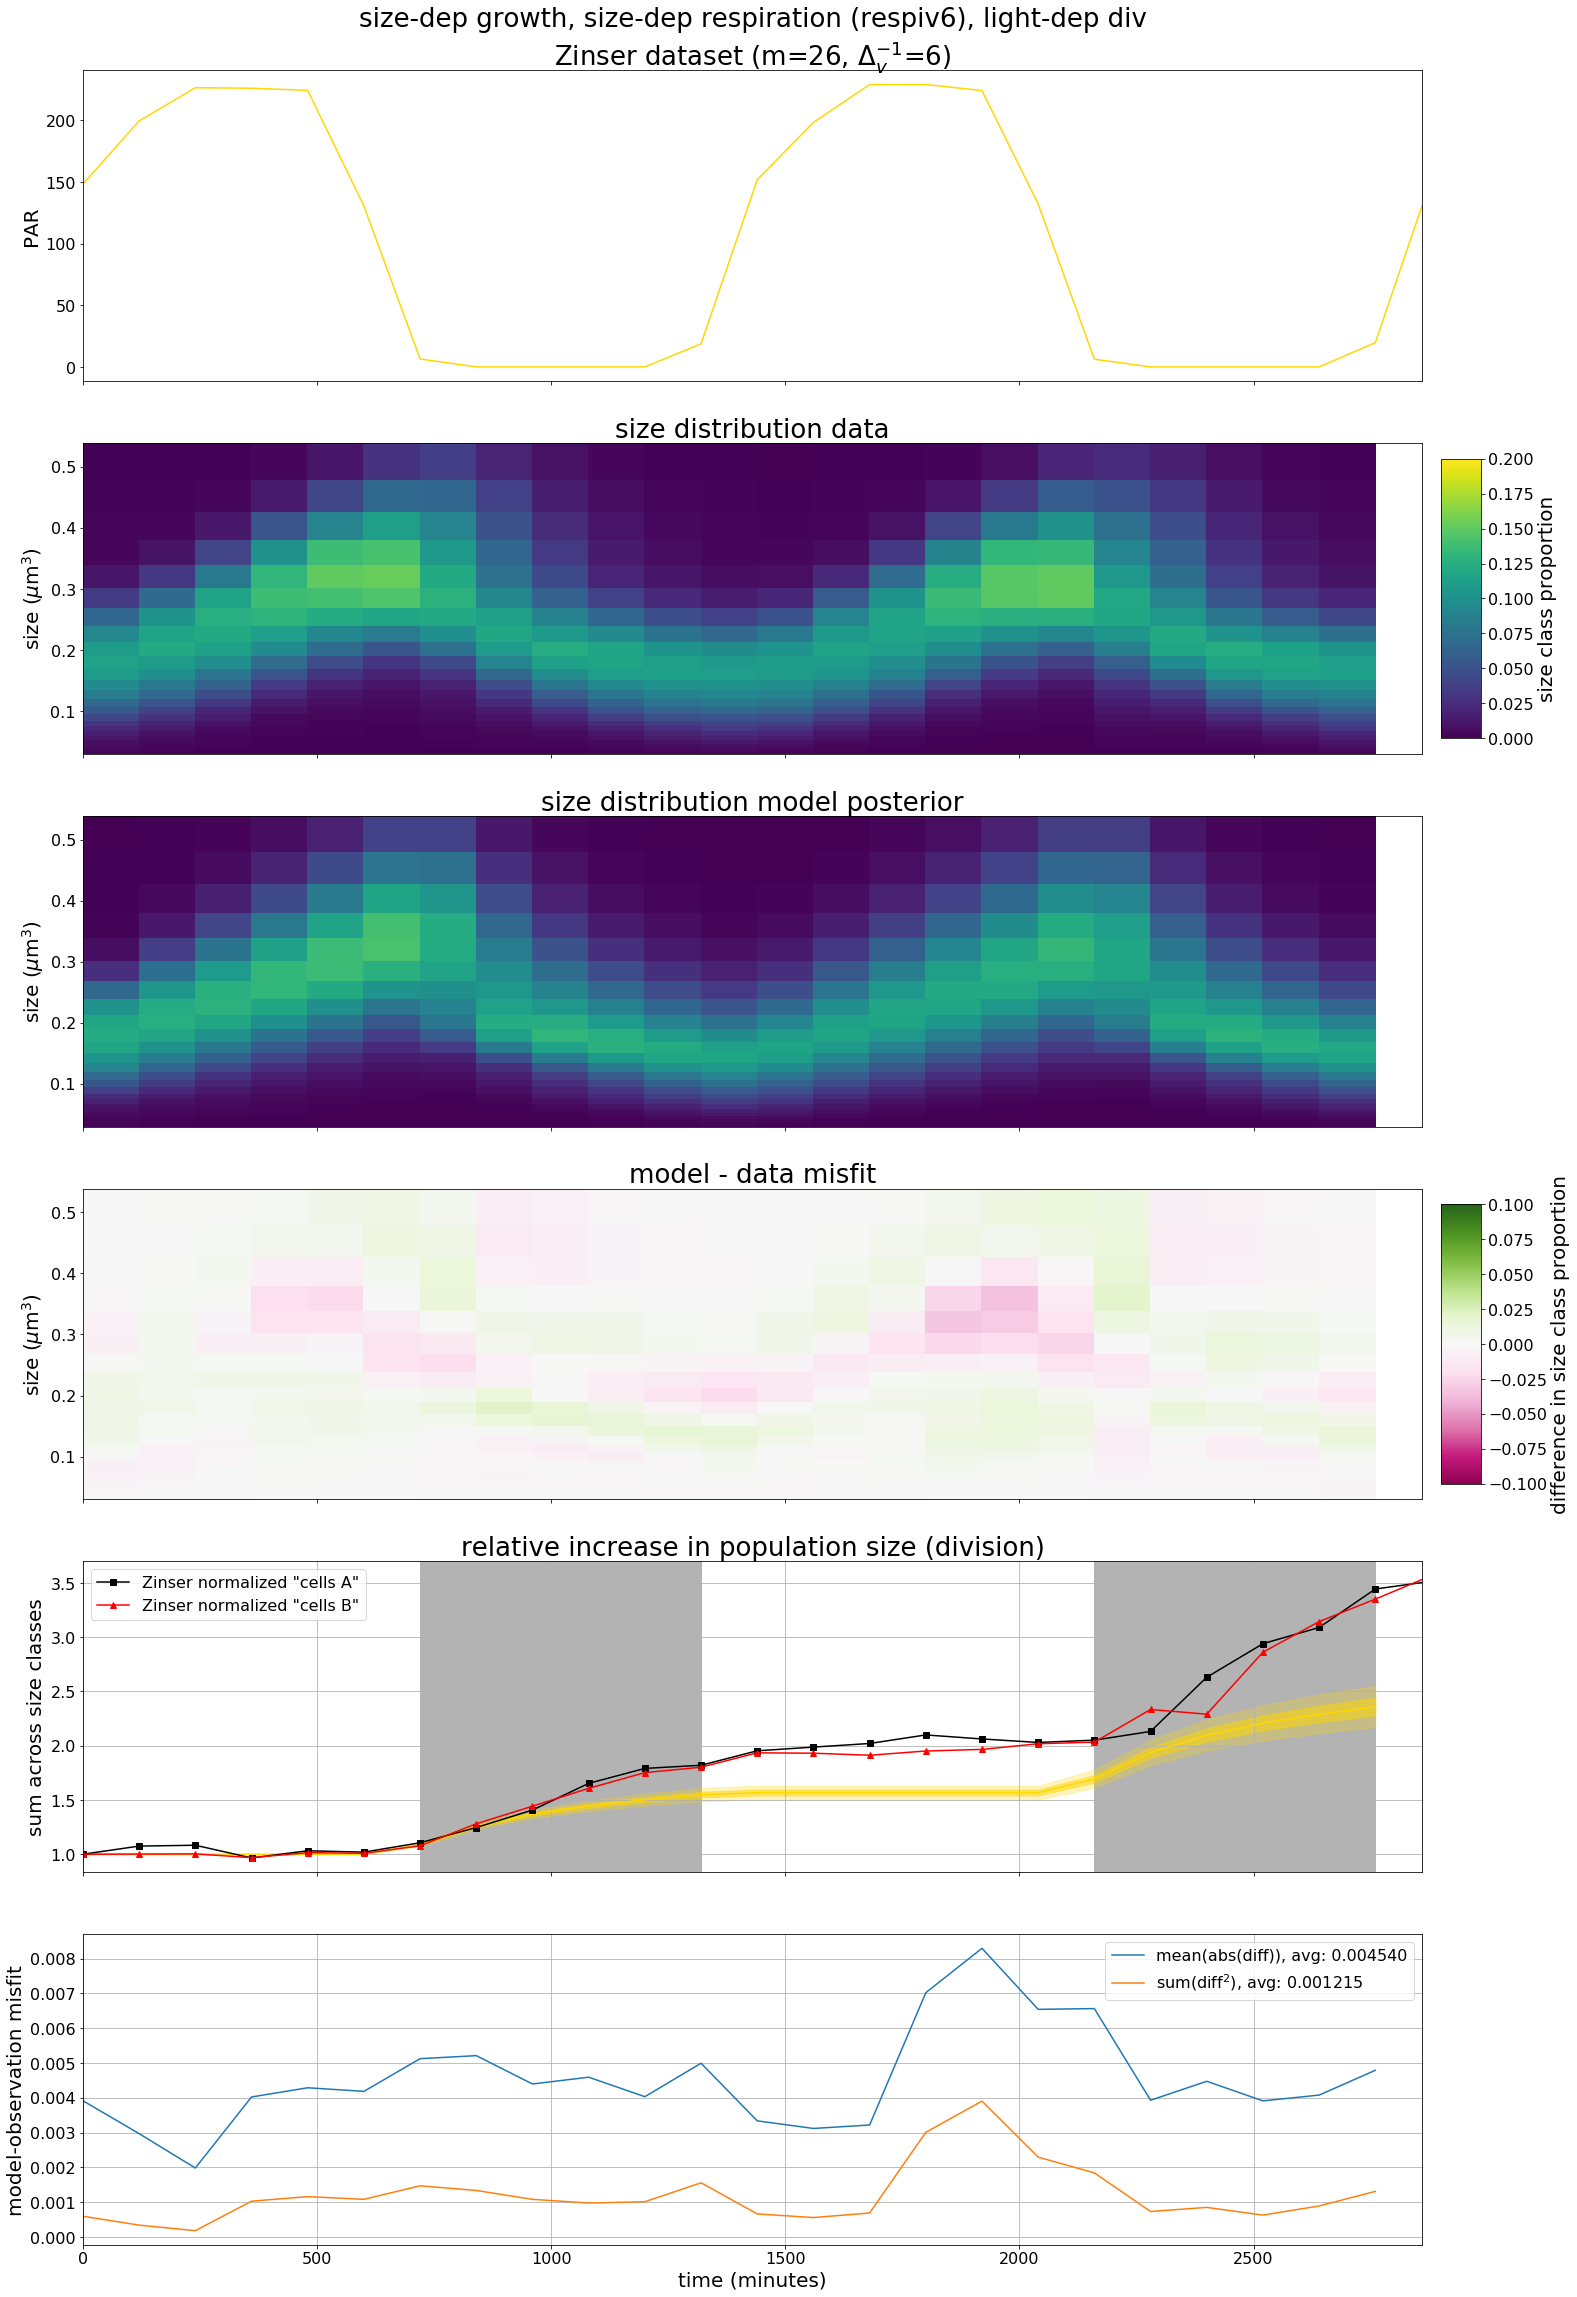

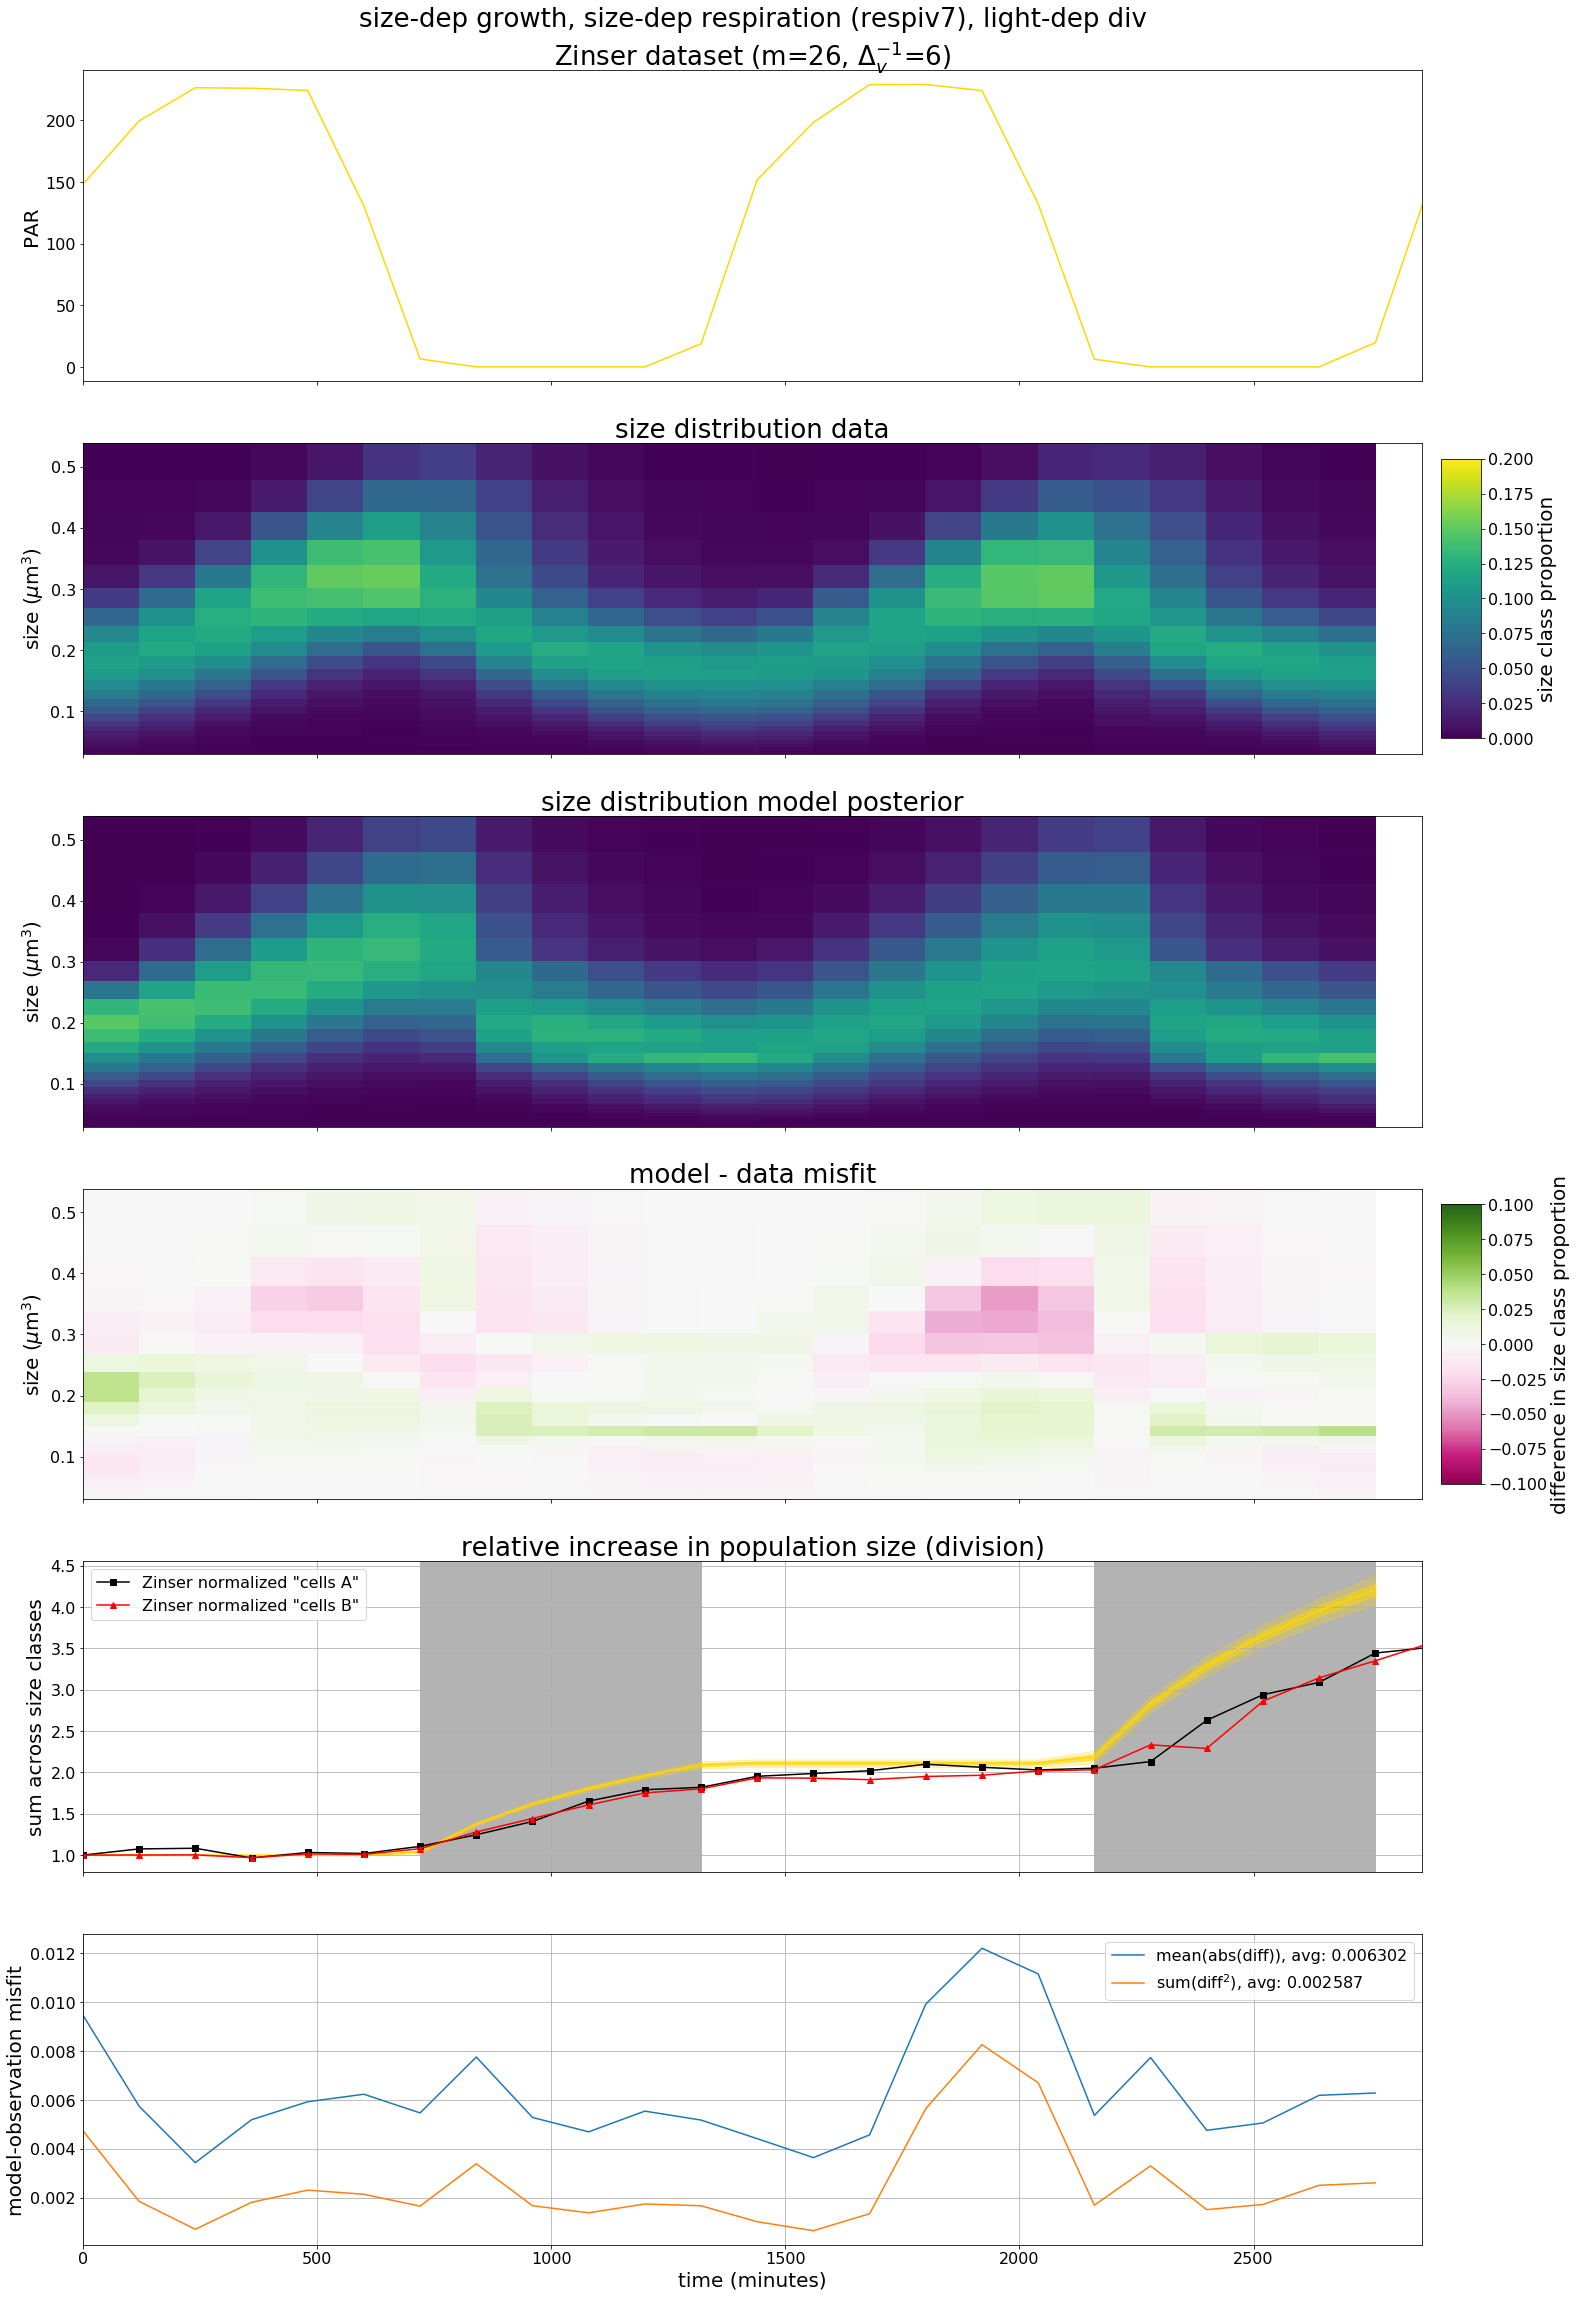

In [12]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [14]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200624_gallery2_test_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,name in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[name][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[name][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[name][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[name][dataname][v]
'''
None